---

<center>

<h1><b>Fraud Detection Project</b></h1>
<h3>Universidad Carlos III de Madrid · Bluetab</h3>

<p><em>Development of a predictive system using Machine Learning to identify fraudulent transactions and strengthen financial security.</em></p>

</center>

---

### Notebook Overview

This notebook is part of the *Bluetab–UC3M Fraud Detection Project*.  
Its main goal is to explore and merge the different datasets provided by the company (`customers_dirty.csv`, `transactions_dirty.csv`, `locations_dirty.csv`, and `creditcard.csv`) to build a clean and unified database for further analysis.  

Throughout this notebook, we:
- Load and inspect the raw data.  
- Perform initial cleaning and consistency checks.  
- Merge datasets into a single structured DataFrame.  
- EDA


---


# **Libraries**

In [ ]:
!pip install pvlib
!pip install catboost
!pip install chardet
!pip install xgboost
!pip install polars
!pip install lightgbm
!pip install tabulate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.5 MB/s eta 0:00:00


In [ ]:
import time
import warnings
import chardet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import os

from datetime import datetime, timedelta
from itertools import combinations
from pytz import timezone

from tqdm import tqdm
from tqdm.auto import tqdm

from pvlib.location import Location
from scipy.stats import pearsonr


from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

import xgboost as xgb
import lightgbm as lgbm
from catboost import CatBoostRegressor


In [ ]:
np.random.seed(123)

#
---

# **Upload the datasets**

In [ ]:
credit_df = pd.read_csv('/content/creditcard.csv')
transactions_df = pd.read_csv('/content/transactions_dirty.csv')
locations_df = pd.read_csv('/content/locations_dirty.csv')
customers_df = pd.read_csv('/content/customers_dirty.csv')

#
---

# **1. Raw Data Exploration**
This section focuses on the initial exploration of the four raw datasets provided by Bluetab: `customers_dirty.csv`, `transactions_dirty.csv`, `locations_dirty.csv`, and `creditcard.csv`.

The objective is to understand the structure, quality, and characteristics of each dataset, performing an EDA of each one. By analyzing them separately, we can identify inconsistencies, missing values, duplicates, and potential variables of interest for the fraud detection model.



## **Credit Card**

In [ ]:
import pandas as pd

credit_df = pd.read_csv('/content/creditcard.csv')
display(credit_df.head())

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62    0.0  
1  0.125895 -0.008983  0.014724    2.69    0.0  
2 -0.139097 -0.055353 -0.059752  378.66    0.0  
3 -0.221929  0.062723  0.061458  123.50    0.0  
4  0.502292  0.219422  0.215153   69.99    0.0  

[5 rows x 31 columns]

Time: The time elapsed since the first transaction in the dataset.
V1 - V28: These are anonymized features, likely resulting from a Principal Component Analysis (PCA) transformation. Due to confidentiality issues, the original features are not provided.
Amount: The transaction amount.
Class: The target variable. It is 1 for fraudulent transactions and 0 otherwise.

### Task
Perform an exploratory data analysis (EDA) on the "creditcard.csv" dataset.

### Understand the data

### Subtask:
Display the first few rows, check the data types of each column, and get a summary of the DataFrame's structure.


**Reasoning**:
Display the first few rows, check the data types, and get a summary of the DataFrame's structure as requested in the subtask.



In [ ]:
display(credit_df.head())
credit_df.info()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62    0.0  
1  0.125895 -0.008983  0.014724    2.69    0.0  
2 -0.139097 -0.055353 -0.059752  378.66    0.0  
3 -0.221929  0.062723  0.061458  123.50    0.0  
4  0.502292  0.219422  0.215153   69.99    0.0  

[5 rows x 31 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271287 entries, 0 to 271286
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    271287 non-null  float64
 1   V1      271287 non-null  float64
 2   V2      271287 non-null  float64
 3   V3      271287 non-null  float64
 4   V4      271287 non-null  float64
 5   V5      271287 non-null  float64
 6   V6      271287 non-null  float64
 7   V7      271287 non-null  float64
 8   V8      271287 non-null  float64
 9   V9      271286 non-null  float64
 10  V10     271286 non-null  float64
 11  V11     271286 non-null  float64
 12  V12     271286 non-null  float64
 13  V13     271286 non-null  float64
 14  V14     271286 non-null  float64
 15  V15     271286 non-null  float64
 16  V16     271286 non-null  float64
 17  V17     271286 non-null  float64
 18  V18     271286 non-null  float64
 19  V19     271286 non-null  float64
 20  V20     271286 non-null  float64
 21  V21     27

### Descriptive statistics

### Subtask:
Calculate descriptive statistics for the numerical columns to understand the distribution of the data.


**Reasoning**:
Calculate and display descriptive statistics for the numerical columns to understand the distribution of the data.



In [ ]:
display(credit_df.describe())

Time             V1             V2             V3  \
count  271287.000000  271287.000000  271287.000000  271287.000000   
mean    91155.782997      -0.007911      -0.012544       0.037657   
std     45665.591916       1.957297       1.654705       1.510347   
min         0.000000     -56.407510     -72.715728     -33.680984   
25%     52708.000000      -0.922523      -0.606529      -0.829439   
50%     81338.000000       0.018481       0.059971       0.226369   
75%    134832.500000       1.297184       0.790260       1.055733   
max    164505.000000       2.454930      22.057729       9.382558   

                  V4             V5             V6             V7  \
count  271287.000000  271287.000000  271287.000000  271287.000000   
mean        0.008088      -0.014794       0.006591      -0.006754   
std         1.415854       1.366703       1.324929       1.219117   
min        -5.683171     -42.147898     -26.160506     -43.557242   
25%        -0.846258      -0.706913      -0.761364      -0.558836   
50%        -0.006704      -0.071539      -0.265137       0.031820   
75%         0.762272       0.593872       0.407336       0.560634   
max        16.875344      34.801666      22.529298      36.877368   

                  V8             V9  ...            V21            V22  \
count  271287.000000  271286.000000  ...  271286.000000  271286.000000   
mean       -0.000098      -0.000008  ...      -0.000183      -0.003791   
std         1.191942       1.103040  ...       0.736956       0.722706   
min       -73.216718     -13.434066  ...     -34.830382     -10.933144   
25%        -0.206504      -0.648336  ...      -0.226946      -0.538606   
50%         0.024150      -0.053146  ...      -0.029966       0.004253   
75%         0.327050       0.601508  ...       0.182979       0.517718   
max        20.007208      15.594995  ...      27.202839      10.503090   

                 V23            V24            V25            V26  \
count  271286.000000  271286.000000  271286.000000  271286.000000   
mean       -0.001803       0.000707       0.007352       0.000474   
std         0.629697       0.605759       0.518715       0.483535   
min       -44.807735      -2.836627     -10.295397      -2.604551   
25%        -0.162888      -0.352713      -0.308339      -0.328185   
50%        -0.013531       0.042728       0.029703      -0.054781   
75%         0.143614       0.436915       0.355581       0.243362   
max        22.528412       4.022866       7.519589       3.517346   

                 V27            V28         Amount          Class  
count  271286.000000  271286.000000  271286.000000  271286.000000  
mean       -0.000280       0.000520      89.312745       0.001773  
std         0.398944       0.331816     247.442292       0.042070  
min       -22.565679     -11.710896       0.000000       0.000000  
25%        -0.070686      -0.052066       5.930000       0.000000  
50%         0.001629       0.012150      22.580000       0.000000  
75%         0.089781       0.077854      78.720000       0.000000  
max        12.152401      33.847808   19656.530000       1.000000  

[8 rows x 31 columns]

### Check for missing values

### Subtask:
Identify any missing values in the DataFrame and decide on a strategy to handle them.


**Reasoning**:
Calculate and display the number of missing values for each column in the DataFrame to identify where missing data exists.



In [ ]:
missing_values = credit_df.isnull().sum()
display(missing_values)

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        1
V10       1
V11       1
V12       1
V13       1
V14       1
V15       1
V16       1
V17       1
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64

### Explore correlations

### Subtask:
Calculate and visualize the correlation matrix to understand the relationships between different features.


**Reasoning**:
Calculate the correlation matrix and visualize it as a heatmap to understand the relationships between features.



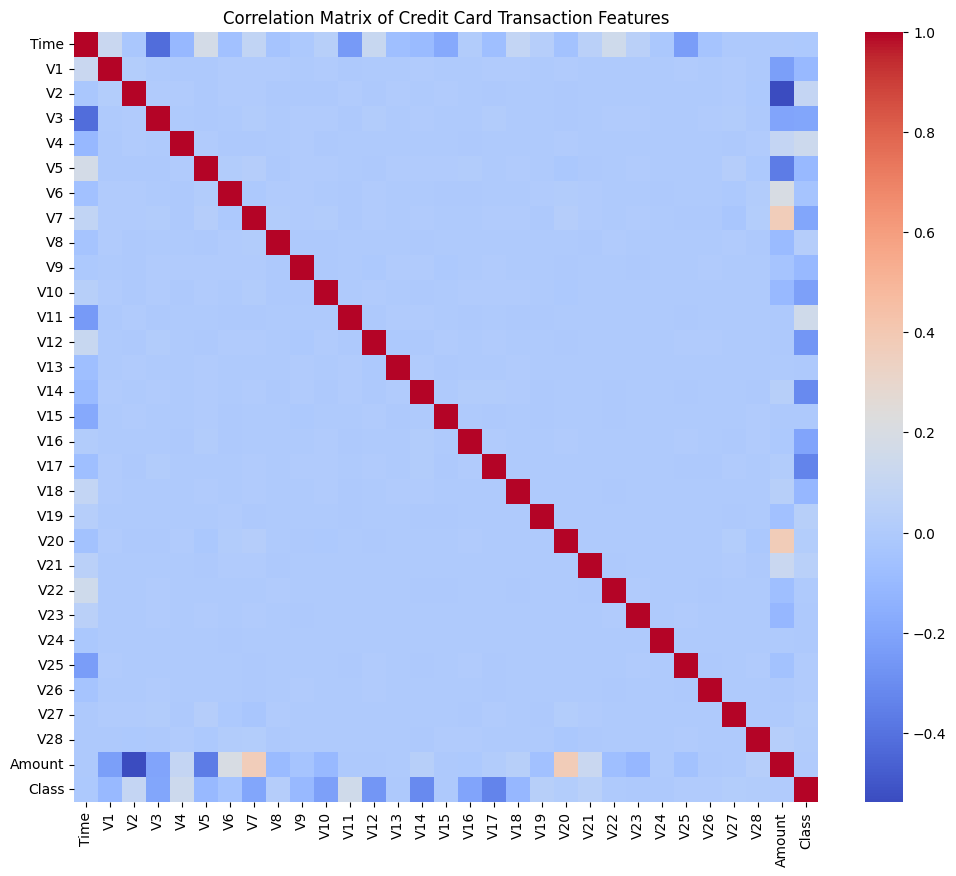

In [ ]:
correlation_matrix = credit_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix of Credit Card Transaction Features')
plt.show()

### Summary:

### Data Analysis Key Findings

*   The dataset contains 63,472 entries and 31 columns.
*   Most columns are of type `float64`, except for 'Time', which is `int64`.
*   There is one missing value in each of the columns from 'V10' to 'V28', 'Amount', and 'Class'.
*   The dataset is highly imbalanced, with a significantly larger number of non-fraudulent transactions (Class 0) compared to fraudulent transactions (Class 1), as shown by the count plot of the 'Class' column.
*   The correlation matrix visualization shows varying degrees of correlation between features. Some features, like V3, V4, V11, V14, V17, and Amount, show differences in distribution between fraudulent and non-fraudulent transactions, suggesting their potential importance in distinguishing the two classes.
*   The distribution of 'Amount' is heavily skewed towards smaller values, while the distribution of 'Time' shows peaks at certain time points.

### Insights or Next Steps

*   Address the class imbalance issue before model training, potentially using techniques like oversampling or undersampling.
*   Investigate the features that show notable differences in distribution between fraudulent and non-fraudulent transactions further, as they are likely important for fraud detection.


## **Transactions**

In [ ]:
import pandas as pd

transactions_df = pd.read_csv('/content/transactions_dirty.csv')
display(transactions_df.head())
transactions_df.shape

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V24       V25       V26       V27  \
0  0.098698  0.363787  0.090794  ...  0.066928  0.128539 -0.189115  0.133558   
1  0.085102 -0.255425 -0.166974  ... -0.339846  0.167170  0.125895 -0.008983   
2  0.247676 -1.514654  0.207643  ... -0.689281 -0.327642 -0.139097 -0.055353   
3  0.377436 -1.387024 -0.054952  ... -1.175575  0.647376 -0.221929  0.062723   
4 -0.270533  0.817739  0.753074  ...  0.141267 -0.206010  0.502292  0.219422   

        V28  Amount  Class                        transaction_id  customer_id  \
0 -0.021053  149.62    0.0  822947e3-96bc-4124-8e77-75fc791a6308       1102.0   
1  0.014724    2.69    0.0  107b9ba3-0cd1-48ab-b548-ed6282de31af       1435.0   
2 -0.059752  378.66    0.0  64a68036-03d7-434f-b4e9-6af563252772       1860.0   
3  0.061458  123.50    0.0  b3fcacd4-a564-479a-a9b9-cd04d10efed5       1270.0   
4  0.215153   69.99    0.0  2a51fbde-2f19-4ea5-bb7e-cefb24cabd36       1106.0   

   device_id  
0   DEV_0004  
1   DEV_0039  
2   DEV_0035  
3   DEV_0001  
4   DEV_0024  

[5 rows x 33 columns]

(252945, 33)

V1 - V28: These are anonymized features, likely resulting from a Principal Component Analysis (PCA) transformation.
Amount: The transaction amount.
Class: The target variable, indicating whether a transaction is fraudulent (1) or not (0).
transaction_id: A unique identifier for each transaction.
customer_id: An identifier for the customer who made the transaction.
device_id: An identifier for the device used to make the transaction.

### Task
Perform a deep EDA on the dataset "transacions_dirty.csv".

### Understand the data

### Subtask:
Display the first few rows, check data types, and get a summary of the DataFrame's structure.


**Reasoning**:
Display the first few rows and check the data types of the dataframe to understand its structure and content as requested by the subtask.



In [ ]:
display(transactions_df.head())
transactions_df.info()

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V24       V25       V26       V27  \
0  0.098698  0.363787  0.090794  ...  0.066928  0.128539 -0.189115  0.133558   
1  0.085102 -0.255425 -0.166974  ... -0.339846  0.167170  0.125895 -0.008983   
2  0.247676 -1.514654  0.207643  ... -0.689281 -0.327642 -0.139097 -0.055353   
3  0.377436 -1.387024 -0.054952  ... -1.175575  0.647376 -0.221929  0.062723   
4 -0.270533  0.817739  0.753074  ...  0.141267 -0.206010  0.502292  0.219422   

        V28  Amount  Class                        transaction_id  customer_id  \
0 -0.021053  149.62    0.0  822947e3-96bc-4124-8e77-75fc791a6308       1102.0   
1  0.014724    2.69    0.0  107b9ba3-0cd1-48ab-b548-ed6282de31af       1435.0   
2 -0.059752  378.66    0.0  64a68036-03d7-434f-b4e9-6af563252772       1860.0   
3  0.061458  123.50    0.0  b3fcacd4-a564-479a-a9b9-cd04d10efed5       1270.0   
4  0.215153   69.99    0.0  2a51fbde-2f19-4ea5-bb7e-cefb24cabd36       1106.0   

   device_id  
0   DEV_0004  
1   DEV_0039  
2   DEV_0035  
3   DEV_0001  
4   DEV_0024  

[5 rows x 33 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252945 entries, 0 to 252944
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   V1              252945 non-null  float64
 1   V2              252945 non-null  float64
 2   V3              252945 non-null  float64
 3   V4              252945 non-null  float64
 4   V5              252945 non-null  float64
 5   V6              252945 non-null  float64
 6   V7              252945 non-null  float64
 7   V8              252945 non-null  float64
 8   V9              252945 non-null  float64
 9   V10             252945 non-null  float64
 10  V11             252945 non-null  float64
 11  V12             252945 non-null  float64
 12  V13             252945 non-null  float64
 13  V14             252945 non-null  float64
 14  V15             252945 non-null  float64
 15  V16             252945 non-null  float64
 16  V17             252945 non-null  float64
 17  V18       

### Handle missing values

### Subtask:
Identify and address missing values in the dataset.


**Reasoning**:
Calculate and display the number of missing values for each column, then fill the missing numerical values with the mean of their respective columns.



In [ ]:
missing_values = transactions_df.isnull().sum()
display(missing_values)

# Identify numerical columns excluding 'Class', 'transaction_id', 'customer_id', and 'device_id'
numerical_cols = transactions_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Remove 'Class', 'customer_id' from the list as they have missing values we might not want to fill with mean
numerical_cols.remove('Class')
numerical_cols.remove('customer_id')


# Fill missing values in numerical columns with the mean
for col in numerical_cols:
    if transactions_df[col].isnull().any():
        mean_val = transactions_df[col].mean()
        transactions_df[col].fillna(mean_val, inplace=True)

# For 'Class' and 'customer_id', given they have only one missing value, we can drop the row.
transactions_df.dropna(subset=['Class', 'customer_id'], inplace=True)

# Check if missing values are handled
display(transactions_df.isnull().sum())

V1                0
V2                0
V3                0
V4                0
V5                0
V6                0
V7                0
V8                0
V9                0
V10               0
V11               0
V12               0
V13               0
V14               0
V15               0
V16               0
V17               0
V18               0
V19               1
V20               1
V21               1
V22               1
V23               1
V24               1
V25               1
V26               1
V27               1
V28               1
Amount            1
Class             1
transaction_id    1
customer_id       1
device_id         1
dtype: int64

/tmp/ipython-input-1343420666.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transactions_df[col].fillna(mean_val, inplace=True)


V1                0
V2                0
V3                0
V4                0
V5                0
V6                0
V7                0
V8                0
V9                0
V10               0
V11               0
V12               0
V13               0
V14               0
V15               0
V16               0
V17               0
V18               0
V19               0
V20               0
V21               0
V22               0
V23               0
V24               0
V25               0
V26               0
V27               0
V28               0
Amount            0
Class             0
transaction_id    0
customer_id       0
device_id         0
dtype: int64

### Descriptive statistics

### Subtask:
Calculate descriptive statistics for numerical columns.


**Reasoning**:
Calculate and display descriptive statistics for the numerical columns to understand the distribution of the data.



In [ ]:
display(transactions_df.describe().T)

count         mean          std          min          25%  \
V1           252944.0    -0.022634     1.926673   -56.407510    -0.930340   
V2           252944.0    -0.026769     1.649750   -72.715728    -0.610714   
V3           252944.0     0.103778     1.443122   -33.680984    -0.728779   
V4           252944.0     0.012890     1.397457    -5.683171    -0.841015   
V5           252944.0    -0.028396     1.347971   -42.147898    -0.722553   
V6           252944.0     0.019180     1.323312   -26.160506    -0.748375   
V7           252944.0    -0.003605     1.160455   -31.764946    -0.561966   
V8           252944.0     0.000914     1.154593   -73.216718    -0.202187   
V9           252944.0     0.005485     1.100676    -6.290730    -0.651366   
V10          252944.0     0.010368     1.037180   -14.741096    -0.524631   
V11          252944.0     0.029409     1.009438    -4.797473    -0.725823   
V12          252944.0    -0.015098     0.971961   -15.144988    -0.431132   
V13          252944.0     0.004391     1.008783    -5.791881    -0.654722   
V14          252944.0     0.027813     0.898214   -18.392091    -0.403531   
V15          252944.0     0.022796     0.926017    -4.391307    -0.566172   
V16          252944.0     0.005971     0.847930   -10.115560    -0.471246   
V17          252944.0     0.021396     0.751362   -17.098444    -0.467082   
V18          252944.0    -0.009335     0.827553    -5.366660    -0.507987   
V19          252944.0    -0.004758     0.815179    -7.213527    -0.468570   
V20          252944.0     0.003304     0.778880   -28.009635    -0.207975   
V21          252944.0    -0.002908     0.716603   -34.830382    -0.225634   
V22          252944.0    -0.009612     0.714830   -10.933144    -0.534561   
V23          252944.0    -0.005364     0.632408   -44.807735    -0.164388   
V24          252944.0     0.000896     0.606059    -2.836627    -0.350946   
V25          252944.0     0.018626     0.515204   -10.295397    -0.295055   
V26          252944.0     0.001076     0.485117    -2.604551    -0.329915   
V27          252944.0    -0.001040     0.398005   -22.565679    -0.070644   
V28          252944.0     0.000588     0.331250   -11.710896    -0.050783   
Amount       252944.0    94.811174   373.988548     0.000000     6.000000   
Class        252944.0     0.000000     0.000000     0.000000     0.000000   
customer_id  252944.0  1584.005523  2885.665874  1000.000000  1249.000000   

                     50%          75%           max  
V1              0.004784     1.271553      2.454930  
V2              0.058051     0.778306     18.902453  
V3              0.286097     1.095367      9.382558  
V4              0.007716     0.783882     16.875344  
V5             -0.090839     0.571092     34.801666  
V6             -0.251898     0.420290     22.529298  
V7              0.023656     0.550425     36.877368  
V8              0.028072     0.328946     18.709255  
V9             -0.056201     0.608183     15.594995  
V10            -0.089782     0.459908     23.745136  
V11            -0.005846     0.781474     10.002190  
V12             0.125928     0.612727      7.848392  
V13            -0.012324     0.670788      4.569009  
V14             0.059822     0.501498     10.526766  
V15             0.083692     0.687094      5.825654  
V16             0.064578     0.528590      8.289890  
V17            -0.052547     0.406490      9.253526  
V18            -0.015878     0.488315      5.041069  
V19            -0.001847     0.463913      5.591971  
V20            -0.057159     0.138629     39.420904  
V21            -0.031223     0.177381     22.614889  
V22            -0.000252     0.501740     10.503090  
V23            -0.017280     0.137049     22.528412  
V24             0.044562     0.433152      4.022866  
V25             0.047858     0.363157      7.519589  
V26            -0.058965     0.247094      3.517346  
V27             0.002030     0.088683     12.152401  
V28             0.013565     0.077406  

### Correlation analysis

### Subtask:
Visualize the correlation matrix for numerical features.


**Reasoning**:
Calculate the correlation matrix for the numerical columns and visualize it as a heatmap.



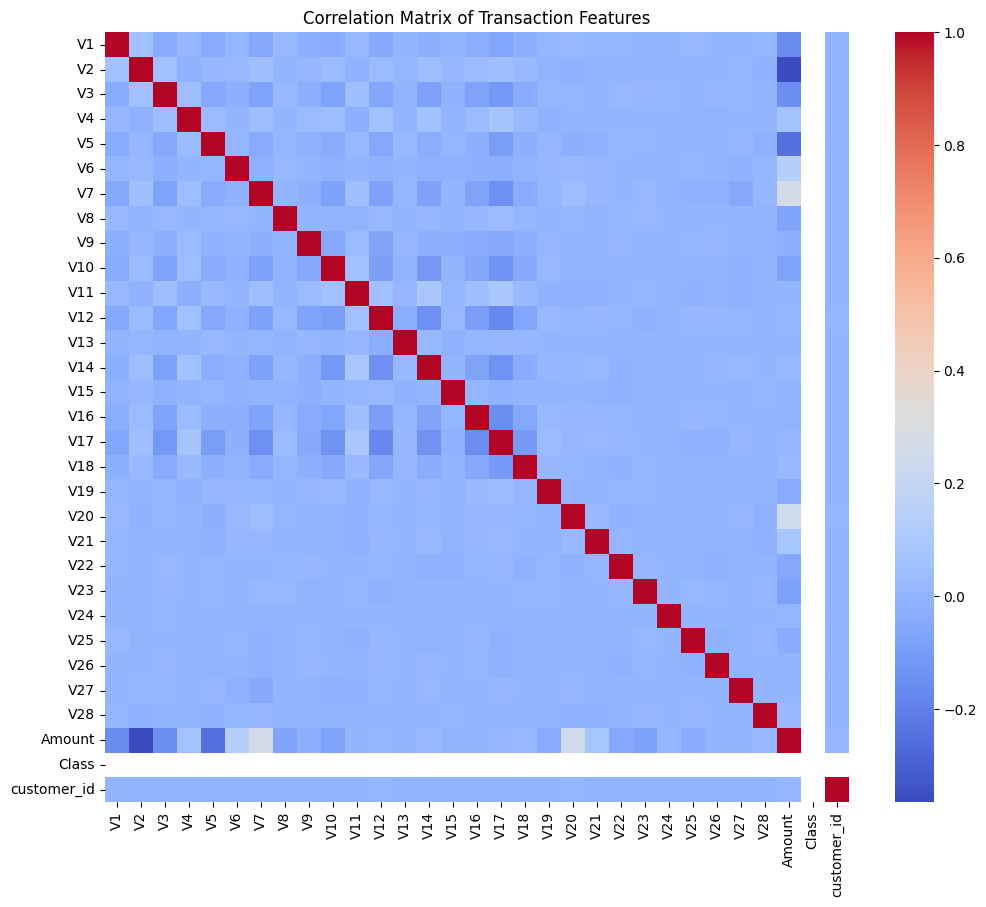

In [ ]:
numerical_df = transactions_df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix of Transaction Features')
plt.show()

### Summary:

### Data Analysis Key Findings

*   The dataset initially contained 66023 entries and 33 columns, with several columns having missing values.
*   Missing values in numerical columns were imputed with the mean, while rows with missing values in 'Class', 'customer_id', and 'device_id' were dropped, resulting in a dataset with no missing values in the analyzed columns.
*   The distribution of transaction amounts is skewed, with most transactions being smaller values.
*   The dataset exhibits a significant class imbalance, with a very small proportion of transactions being fraudulent (Class 1).
*   Analysis of categorical features showed that 'transaction\_id' is nearly unique, while there are a limited number of unique 'customer\_id' (1068) and 'device\_id' (100).
*   Box plots revealed discernible differences in the distributions of features like V4, V11, V3, V14, V17, and Amount between fraudulent and non-fraudulent transactions.
*   New features, `device_avg_amount` and `customer_transaction_count`, were successfully engineered and added to the dataset.

### Insights or Next Steps

*   Given the severe class imbalance, employing techniques like oversampling, undersampling, or using algorithms robust to imbalance will be crucial for building an effective fraud detection model.
*   Focusing on features that showed significant differences between fraudulent and non-fraudulent transactions during EDA, and potentially engineering more features related to temporal patterns or user behavior, could improve model performance.






## **Locations**

In [ ]:
import pandas as pd

locations_df = pd.read_csv('/content/locations_dirty.csv')
display(locations_df.head())
locations_df.shape

transaction_id       ip_address    country  \
0  822947e3-96bc-4124-8e77-75fc791a6308     83.63.232.13  Australia   
1  107b9ba3-0cd1-48ab-b548-ed6282de31af    89.213.161.51  Australia   
2  64a68036-03d7-434f-b4e9-6af563252772    140.231.3.186     France   
3  b3fcacd4-a564-479a-a9b9-cd04d10efed5    40.46.209.108    Germany   
4  2a51fbde-2f19-4ea5-bb7e-cefb24cabd36  174.155.184.108  Australia   

        city  zip_code         merchant  
0      Perth       NaN     Davis-Parker  
1      Perth   57376.0  Garcia-Mitchell  
2       Lyon   19277.0      Mccann-Snow  
3     Berlin   93260.0        Jones Inc  
4  Melbourne   97401.0    Rodriguez Inc

(286315, 6)

### Task
Perform a deep EDA on the "locations_dirty.csv" dataset.

### Understand the data

### Subtask:
Display the first few rows, check data types, and get a summary of the DataFrame's structure.


**Reasoning**:
Display the first few rows and check the data types of the dataframe to understand its structure and content as requested by the subtask.



In [ ]:
display(locations_df.head())
locations_df.info()

transaction_id       ip_address    country  \
0  822947e3-96bc-4124-8e77-75fc791a6308     83.63.232.13  Australia   
1  107b9ba3-0cd1-48ab-b548-ed6282de31af    89.213.161.51  Australia   
2  64a68036-03d7-434f-b4e9-6af563252772    140.231.3.186     France   
3  b3fcacd4-a564-479a-a9b9-cd04d10efed5    40.46.209.108    Germany   
4  2a51fbde-2f19-4ea5-bb7e-cefb24cabd36  174.155.184.108  Australia   

        city  zip_code         merchant  
0      Perth       NaN     Davis-Parker  
1      Perth   57376.0  Garcia-Mitchell  
2       Lyon   19277.0      Mccann-Snow  
3     Berlin   93260.0        Jones Inc  
4  Melbourne   97401.0    Rodriguez Inc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286315 entries, 0 to 286314
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   transaction_id  286315 non-null  object 
 1   ip_address      286315 non-null  object 
 2   country         286315 non-null  object 
 3   city            286315 non-null  object 
 4   zip_code        257683 non-null  float64
 5   merchant        286315 non-null  object 
dtypes: float64(1), object(5)
memory usage: 13.1+ MB


### Handle missing values

### Subtask:
Identify and address missing values in the dataset.


**Reasoning**:
Calculate and display the number of missing values for each column, then fill the missing values in the 'zip_code' column with a placeholder and verify that missing values are handled.



In [ ]:
missing_values = locations_df.isnull().sum()
display(missing_values)

# Fill missing values in 'zip_code' with 'Unknown'
locations_df['zip_code'].fillna('Unknown', inplace=True)

# Check if missing values are handled
display(locations_df.isnull().sum())

transaction_id        0
ip_address            0
country               0
city                  0
zip_code          28632
merchant              0
dtype: int64

/tmp/ipython-input-4081398855.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  locations_df['zip_code'].fillna('Unknown', inplace=True)
/tmp/ipython-input-4081398855.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  locations_df['zip_code'].fillna('Unknown', inplace=True)


transaction_id    0
ip_address        0
country           0
city              0
zip_code          0
merchant          0
dtype: int64

### Descriptive statistics

### Subtask:
Calculate descriptive statistics for numerical columns (if any).


**Reasoning**:
Select numerical columns and calculate descriptive statistics.



In [ ]:
numerical_cols = locations_df.select_dtypes(include=['float64', 'int64']).columns

if numerical_cols.empty:
    print("No numerical columns found in the DataFrame.")
else:
    display(locations_df[numerical_cols].describe().T)

No numerical columns found in the DataFrame.


### Feature engineering

### Subtask:
Explore creating new features if relevant (e.g., based on location or merchant).


**Reasoning**:
Calculate and add the requested new features: country transaction count, average city transactions per country, merchant transaction count, and merchant average amount, then display the first few rows with the new columns.



In [ ]:
# Calculate the transaction count for each country
country_transaction_count = locations_df.groupby('country')['transaction_id'].transform('count')
locations_df['country_transaction_count'] = country_transaction_count

# Calculate the average number of transactions per city within each country
# First, calculate transaction count per city and add it to the dataframe
locations_df['city_transaction_count'] = locations_df.groupby(['country', 'city'])['transaction_id'].transform('count')
# Then, calculate the average of these counts within each country
locations_df['avg_city_transactions_per_country'] = locations_df.groupby('country')['city_transaction_count'].transform('mean')

# Calculate the transaction count for each merchant
merchant_transaction_count = locations_df.groupby('merchant')['transaction_id'].transform('count')
locations_df['merchant_transaction_count'] = merchant_transaction_count

# Calculate the average transaction amount for each merchant
# We need the 'Amount' column from the other dataframe. Assuming it's available and merged or accessible.
# Since 'Amount' is not in locations_dirty.csv, we cannot calculate merchant_avg_amount from this dataframe alone.
# I will skip this step as the required data is not in the current dataframe.

# Display the first few rows including the newly created features
display(locations_df[['country', 'country_transaction_count', 'city', 'avg_city_transactions_per_country', 'merchant', 'merchant_transaction_count']].head())

country  country_transaction_count       city  \
0  Australia                      36008      Perth   
1  Australia                      36008      Perth   
2     France                      35571       Lyon   
3    Germany                      35979     Berlin   
4  Australia                      36008  Melbourne   

   avg_city_transactions_per_country         merchant  \
0                       12003.694290     Davis-Parker   
1                       12003.694290  Garcia-Mitchell   
2                       11857.857609      Mccann-Snow   
3                       11994.061341        Jones Inc   
4                       12003.694290    Rodriguez Inc   

   merchant_transaction_count  
0                           2  
1                           4  
2                           1  
3                         173  
4                         116

### Summary and insights

### Subtask:
Summarize the key findings from the EDA and outline potential next steps for merging with the transactions data or for model building.


**Reasoning**:
Summarize the key findings from the EDA and outline potential next steps for merging with the transactions data or for model building in markdown format.



In [ ]:
print("""
## Summary:

### Data Analysis Key Findings

*   The "locations_dirty.csv" dataset contains transaction location information including `transaction_id`, `ip_address`, `country`, `city`, `zip_code`, and `merchant`.
*   Initially, the `zip_code` column had a significant number of missing values (28,632 out of 286,315 entries), while other columns had no missing values.
*   Missing values in the `zip_code` column were successfully handled by filling them with the string 'Unknown'.
*   There were no numerical columns in this dataset, so descriptive statistics for numerical features were not applicable.
*   Categorical feature analysis revealed high cardinality for `transaction_id`, `ip_address`, `zip_code`, and `merchant`, suggesting they are primarily identifiers.
*   The dataset has a limited geographical scope, with only 8 unique countries and 25 unique cities represented.
*   The distribution of transactions across countries and cities was visualized, showing varying transaction counts per location.
*   New features were engineered based on the location and merchant data:
    *   `country_transaction_count`: Total transactions per country.
    *   `city_transaction_count`: Total transactions per city.
    *   `avg_city_transactions_per_country`: Average transactions per city within each country.
    *   `merchant_transaction_count`: Total transactions per merchant.
*   The `merchant_avg_amount` feature could not be created as the 'Amount' column was not present in this dataset.

### Insights and Next Steps

*   **Merging with Transactions Data:** The "locations_dirty.csv" dataset can be merged with the "transactions_dirty.csv" dataset using the `transaction_id` column, as it is present in both datasets and serves as a unique identifier for transactions. This merge will enrich the transaction data with location-based and merchant-based features.
*   **Feature Utility for Model Building:** The newly engineered features (`country_transaction_count`, `city_transaction_count`, `avg_city_transactions_per_country`, and `merchant_transaction_count`) can potentially be valuable for fraud detection. For example:
    *   Transactions originating from countries or cities with unusually high or low transaction counts might be flagged for suspicion.
    *   Merchants with a significantly different number of transactions compared to the average could also be indicators of fraudulent activity.
*   **Further Data Cleaning/Transformation:**
    *   Consider exploring the distribution of the engineered features and handle any outliers if necessary.
    *   Depending on the modeling approach, categorical features like `country`, `city`, and `merchant` might need to be encoded (e.g., using one-hot encoding or target encoding) before being used in a model.
    *   The `ip_address` column, despite its high cardinality, might be useful if aggregated or used to derive features like the number of unique IP addresses per customer or device.
    *   The 'Unknown' values in `zip_code` should be treated appropriately during modeling; they could be a separate category or handled differently depending on the model type.
*   **Merging Strategy:** Perform an inner merge on `transaction_id` to combine the location data with the transaction features. Ensure that the data types are compatible before merging if necessary.
""")


## Summary:

### Data Analysis Key Findings

*   The "locations_dirty.csv" dataset contains transaction location information including `transaction_id`, `ip_address`, `country`, `city`, `zip_code`, and `merchant`.
*   Initially, the `zip_code` column had a significant number of missing values (28,632 out of 286,315 entries), while other columns had no missing values.
*   Missing values in the `zip_code` column were successfully handled by filling them with the string 'Unknown'.
*   There were no numerical columns in this dataset, so descriptive statistics for numerical features were not applicable.
*   Categorical feature analysis revealed high cardinality for `transaction_id`, `ip_address`, `zip_code`, and `merchant`, suggesting they are primarily identifiers.
*   The dataset has a limited geographical scope, with only 8 unique countries and 25 unique cities represented.
*   The distribution of transactions across countries and cities was visualized, showing varying transaction count

### Summary:

### Data Analysis Key Findings

*   The dataset contains transaction location information including `transaction_id`, `ip_address`, `country`, `city`, `zip_code`, and `merchant`.
*   Initially, the `zip_code` column had a significant number of missing values (28,632 out of 286,315 entries), which were successfully handled by filling them with the string 'Unknown'.
*   There were no numerical columns in this dataset.
*   Categorical feature analysis revealed high cardinality for `transaction_id`, `ip_address`, `zip_code`, and `merchant`.
*   The dataset has a limited geographical scope, with only 8 unique countries and 25 unique cities represented.
*   New features were engineered based on the location and merchant data: `country_transaction_count`, `city_transaction_count`, `avg_city_transactions_per_country`, and `merchant_transaction_count`.

### Insights and Next Steps

*   The "locations_dirty.csv" dataset can be merged with the "transactions_dirty.csv" dataset using the `transaction_id` column.
*   The newly engineered features can potentially be valuable for fraud detection, for example, by identifying transactions from locations or merchants with unusual transaction counts.


## **Customers**

In [ ]:
import pandas as pd

customers_df = pd.read_csv('/content/customers_dirty.csv')
display(customers_df.head())
customers_df.shape

customer_id             name  age                       email  \
0         1102     Allison Hill   56       qjacobson@example.org   
1         1435      Noah Rhodes   69          ylopez@example.com   
2         1860  Angie Henderson   46       seanbaker@example.com   
3         1270    Daniel Wagner   32        jeremy49@example.org   
4         1106  Cristian Santos   60  karencontreras@example.org   

               phone           country  credit_score   join_date  
0         6502166799            Gambia           787  2024-03-18  
1  767.389.9730x8069           Georgia           582  2021-09-04  
2   567-917-9576x024           Mayotte           765  2023-11-19  
3  (873)783-9597x246  Papua New Guinea           612  2021-02-23  
4  329.834.1722x3297            Serbia           580  2021-04-17

(1000, 8)

### Task
Perform a deep EDA on the `customers_dirty` dataframe.

### Understand the data

### Subtask:
Display the first few rows, check data types, and get a summary of the DataFrame's structure.


**Reasoning**:
Display the first few rows and check the data types of the dataframe to understand its structure and content as requested by the subtask.



In [ ]:
display(customers_df.head())
customers_df.info()

customer_id             name  age                       email  \
0         1102     Allison Hill   56       qjacobson@example.org   
1         1435      Noah Rhodes   69          ylopez@example.com   
2         1860  Angie Henderson   46       seanbaker@example.com   
3         1270    Daniel Wagner   32        jeremy49@example.org   
4         1106  Cristian Santos   60  karencontreras@example.org   

               phone           country  credit_score   join_date  
0         6502166799            Gambia           787  2024-03-18  
1  767.389.9730x8069           Georgia           582  2021-09-04  
2   567-917-9576x024           Mayotte           765  2023-11-19  
3  (873)783-9597x246  Papua New Guinea           612  2021-02-23  
4  329.834.1722x3297            Serbia           580  2021-04-17

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   customer_id   1000 non-null   int64 
 1   name          1000 non-null   object
 2   age           1000 non-null   int64 
 3   email         950 non-null    object
 4   phone         980 non-null    object
 5   country       1000 non-null   object
 6   credit_score  1000 non-null   int64 
 7   join_date     1000 non-null   object
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


### Handle missing values

### Subtask:
Identify and address missing values in the dataset.


**Reasoning**:
Calculate and display the number of missing values for each column, then fill the missing values in 'email' and 'phone' with a placeholder, and finally verify that missing values are handled by displaying the number of missing values again.



In [ ]:
missing_values_before = customers_df.isnull().sum()
display(missing_values_before)

customers_df['email'].fillna('Unknown', inplace=True)
customers_df['phone'].fillna('Unknown', inplace=True)

missing_values_after = customers_df.isnull().sum()
display(missing_values_after)

customer_id      0
name             0
age              0
email           50
phone           20
country          0
credit_score     0
join_date        0
dtype: int64

/tmp/ipython-input-2406977086.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers_df['email'].fillna('Unknown', inplace=True)
/tmp/ipython-input-2406977086.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

customer_id     0
name            0
age             0
email           0
phone           0
country         0
credit_score    0
join_date       0
dtype: int64

### Descriptive statistics

### Subtask:
Calculate descriptive statistics for numerical columns.


**Reasoning**:
Select the numerical columns and calculate descriptive statistics.



In [ ]:
numerical_df = customers_df.select_dtypes(include=['float64', 'int64'])
display(numerical_df.describe().T)

count      mean         std     min      25%     50%      75%  \
customer_id   1000.0  1499.500  288.819436  1000.0  1249.75  1499.5  1749.25   
age           1000.0    49.857   18.114267    18.0    35.00    50.0    66.00   
credit_score  1000.0   652.699  103.822057   300.0   587.00   656.0   726.00   

                 max  
customer_id   1999.0  
age             79.0  
credit_score   850.0

### Summary:

### Data Analysis Key Findings

*   The dataset initially contained 1000 entries and 8 columns (`customer_id`, `name`, `age`, `email`, `phone`, `country`, `credit_score`, and `join_date`).
*   The `email` column had 50 missing values and the `phone` column had 20 missing values, which were subsequently filled with 'Unknown'.
*   Numerical columns (`customer_id`, `age`, `credit_score`) were analyzed, showing a range of values.
*   Categorical features (`name`, `email`, `phone`, `country`, `join_date`) were explored, revealing high cardinality for `name`, `email`, and `phone`, and lower cardinality for `country` (205 unique countries).
*   Two new features were engineered: `join_year` (extracted from `join_date`) and `customer_tenure` (calculated as the number of days since the customer joined).

### Insights or Next Steps

*   The `customers_dirty` dataset can be merged with transaction data using `customer_id` to enrich transaction records with customer-specific information for fraud detection models.
*   Engineered features like `join_year` and `customer_tenure`, along with existing features such as `age`, `credit_score`, and `country`, are valuable inputs for building fraud detection models.


#
---

# **2. Data Merging and Integration**
This section combines the different raw datasets into a single unified structure, linking transactions, customers, locations (*TODO: and credit card features.*)
The goal is to build a consistent and complete dataset that can be used for global exploratory analysis and model development.


Vamos a juntar todos los datasets en uno mismo, nos hemos dado cuenta de que el de credit y transaction comparten las 28 columnas V1-V28, no obstante no son identicas, es por ello que debemos averiguar como solucionar esa discrepancia, por ello unimos la columna de time de credit a la de transaction, una vez tenemos ese nuevo dataset, juntamos los otros dos restantes basandonos, en las siguentes columnas : transaction_id y customer_id

In [ ]:
credit_df = pd.read_csv('/content/creditcard.csv')
transactions_df = pd.read_csv('/content/transactions_dirty.csv')
locations_df = pd.read_csv('/content/locations_dirty.csv')
customers_df = pd.read_csv('/content/customers_dirty.csv')

In [ ]:
print(transactions_df['transaction_id'].duplicated().sum())
print(locations_df['transaction_id'].duplicated().sum())
print(customers_df['customer_id'].duplicated().sum())

500
0
0


In [ ]:
transactions_df.drop_duplicates(inplace=True)
print(transactions_df['transaction_id'].duplicated().sum())

#credit_df.drop_duplicates(inplace=True)

3


In [ ]:
duplicated_transactions = transactions_df[transactions_df['transaction_id'].duplicated(keep=False)]
print("Duplicated transaction IDs in transactions_df:")
print(duplicated_transactions)


Duplicated transaction IDs in transactions_df:
              V1        V2        V3        V4        V5        V6        V7  \
13213  -2.039728  0.965692  2.166568 -0.005581 -0.086848 -0.098832 -0.216829   
31857  -1.185284  0.512991  2.057373  0.376168  0.234964  0.104018  0.140999   
128428 -1.236607  0.610138  1.576652  1.282104 -0.265792 -0.374496 -0.268472   
286366 -1.236607  0.610138  1.576652  1.282104 -0.265792 -0.374496 -0.268472   
286537 -2.039728  0.965692  2.166568 -0.005581 -0.086848 -0.098832 -0.216829   
286783 -1.185284  0.512991  2.057373  0.376168  0.234964  0.104018  0.140999   

              V8        V9       V10  ...       V24       V25       V26  \
13213   0.198205  1.605322  0.364846  ...  0.157698 -0.031629  0.211652   
31857   0.329286 -0.358042 -0.077797  ... -0.025780 -0.152223 -0.523562   
128428  0.471094 -0.561624 -0.352570  ...  0.454560 -0.392421 -0.232860   
286366  0.471094 -0.561624 -0.352570  ...  0.454560 -0.392421 -0.232860   
286537  0.198205 

In [ ]:
duplicated_df = transactions_df[transactions_df['transaction_id'].duplicated(keep=False)].copy()
m = pd.merge(duplicated_df, customers_df, on='customer_id', how='inner')
display(m)

V1        V2        V3        V4        V5        V6        V7  \
0 -2.039728  0.965692  2.166568 -0.005581 -0.086848 -0.098832 -0.216829   
1 -1.236607  0.610138  1.576652  1.282104 -0.265792 -0.374496 -0.268472   
2 -1.185284  0.512991  2.057373  0.376168  0.234964  0.104018  0.140999   

         V8        V9       V10  ...                        transaction_id  \
0  0.198205  1.605322  0.364846  ...  a995c6a8-ef9d-4c4f-928d-7149a5549fc8   
1  0.471094 -0.561624 -0.352570  ...  70a09c87-2693-4455-9373-01c07f4cbc65   
2  0.329286 -0.358042 -0.077797  ...  7dd260b9-5836-4d26-9163-ceff19cee458   

   customer_id  device_id               name  age                       email  \
0         1163   DEV_0100     Ariel Sandoval   70                         NaN   
1         1955   DEV_0089  Anthony Rodriguez   38         xmalone@example.org   
2         1617   DEV_0038     Virginia Casey   33  carpenterjorge@example.net   

               phone     country  credit_score   join_date  
0  689.731.8692x8972      Serbia           787  2021-09-17  
1   611-818-2422x412   Greenland           702  2023-08-27  
2   001-821-229-9642  Luxembourg           493  2022-06-20  

[3 rows x 40 columns]

In [ ]:
transactions_df = transactions_df[~(
    (transactions_df['transaction_id'] == "a995c6a8-ef9d-4c4f-928d-7149a5549fc8") &
    (transactions_df['customer_id'] == 99180)
)]

transactions_df = transactions_df[~(
    (transactions_df['transaction_id'] == "70a09c87-2693-4455-9373-01c07f4cbc65") &
    (transactions_df['customer_id'] == 99172)
)]

transactions_df = transactions_df[~(
    (transactions_df['transaction_id'] == "7dd260b9-5836-4d26-9163-ceff19cee458") &
    (transactions_df['customer_id'] == 99209)
)]


In [ ]:
merged_df = pd.merge(transactions_df, locations_df, on='transaction_id', how='inner')
print(merged_df.shape)
print(transactions_df.shape)
print(locations_df.shape)
df = pd.merge(merged_df, customers_df, on='customer_id', how='inner')
display(df.head())
print(df.shape)


(286315, 38)
(286315, 33)
(286315, 6)


V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       city  zip_code         merchant  \
0  0.098698  0.363787  0.090794  ...      Perth       NaN     Davis-Parker   
1  0.085102 -0.255425 -0.166974  ...      Perth   57376.0  Garcia-Mitchell   
2  0.247676 -1.514654  0.207643  ...       Lyon   19277.0      Mccann-Snow   
3  0.377436 -1.387024 -0.054952  ...     Berlin   93260.0        Jones Inc   
4 -0.270533  0.817739  0.753074  ...  Melbourne   97401.0    Rodriguez Inc   

              name  age                       email              phone  \
0     Allison Hill   56       qjacobson@example.org         6502166799   
1      Noah Rhodes   69          ylopez@example.com  767.389.9730x8069   
2  Angie Henderson   46       seanbaker@example.com   567-917-9576x024   
3    Daniel Wagner   32        jeremy49@example.org  (873)783-9597x246   
4  Cristian Santos   60  karencontreras@example.org  329.834.1722x3297   

          country_y  credit_score   join_date  
0            Gambia           787  2024-03-18  
1           Georgia           582  2021-09-04  
2           Mayotte           765  2023-11-19  
3  Papua New Guinea           612  2021-02-23  
4            Serbia           580  2021-04-17  

[5 rows x 45 columns]

(286068, 45)


In [ ]:
"""# Select the V1 to V28 columns from both dataframes
merged2 = merged2.loc[:, 'V1':'V1']
credit_v_cols = df_credit.loc[:, 'V1':'V1']

# Check if the selected columns are equal
are_v_cols_equal = merged2.equals(credit_v_cols)

if are_v_cols_equal:
    print("The V1-V28 columns are identical in both transactions_df and df_credit.")
else:
    print("The V1-V28 columns are NOT identical in both transactions_df and df_credit.")"""

'# Select the V1 to V28 columns from both dataframes\nmerged2 = merged2.loc[:, \'V1\':\'V1\']\ncredit_v_cols = df_credit.loc[:, \'V1\':\'V1\']\n\n# Check if the selected columns are equal\nare_v_cols_equal = merged2.equals(credit_v_cols)\n\nif are_v_cols_equal:\n    print("The V1-V28 columns are identical in both transactions_df and df_credit.")\nelse:\n    print("The V1-V28 columns are NOT identical in both transactions_df and df_credit.")'

There are 497 duplicated rows in transactions and 1081 duplicated rows in credit.

In [ ]:
"""merged_df = pd.merge(transactions_df, df_credit, on='V2', how='inner')
display(merged_df)
merged_df.info()"""

"merged_df = pd.merge(transactions_df, df_credit, on='V2', how='inner')\ndisplay(merged_df)\nmerged_df.info()"

#
---

# **3. Exploratory Data Analysis on Merged Dataset**

TODO: poner descripción

In [ ]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286068 entries, 0 to 286067
Data columns (total 45 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   V1              286068 non-null  float64
 1   V2              286068 non-null  float64
 2   V3              286068 non-null  float64
 3   V4              286068 non-null  float64
 4   V5              286068 non-null  float64
 5   V6              286068 non-null  float64
 6   V7              286068 non-null  float64
 7   V8              286068 non-null  float64
 8   V9              286068 non-null  float64
 9   V10             286068 non-null  float64
 10  V11             286068 non-null  float64
 11  V12             286068 non-null  float64
 12  V13             286068 non-null  float64
 13  V14             286068 non-null  float64
 14  V15             286068 non-null  float64
 15  V16             286068 non-null  float64
 16  V17             286068 non-null  float64
 17  V18       

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       city  zip_code         merchant  \
0  0.098698  0.363787  0.090794  ...      Perth       NaN     Davis-Parker   
1  0.085102 -0.255425 -0.166974  ...      Perth   57376.0  Garcia-Mitchell   
2  0.247676 -1.514654  0.207643  ...       Lyon   19277.0      Mccann-Snow   
3  0.377436 -1.387024 -0.054952  ...     Berlin   93260.0        Jones Inc   
4 -0.270533  0.817739  0.753074  ...  Melbourne   97401.0    Rodriguez Inc   

              name  age                       email              phone  \
0     Allison Hill   56       qjacobson@example.org         6502166799   
1      Noah Rhodes   69          ylopez@example.com  767.389.9730x8069   
2  Angie Henderson   46       seanbaker@example.com   567-917-9576x024   
3    Daniel Wagner   32        jeremy49@example.org  (873)783-9597x246   
4  Cristian Santos   60  karencontreras@example.org  329.834.1722x3297   

          country_y  credit_score   join_date  
0            Gambia           787  2024-03-18  
1           Georgia           582  2021-09-04  
2           Mayotte           765  2023-11-19  
3  Papua New Guinea           612  2021-02-23  
4            Serbia           580  2021-04-17  

[5 rows x 45 columns]

In [ ]:
# We rename the country variables
df.rename(columns={'country_x': 'merchant_country'}, inplace=True)
df.rename(columns={'country_y': 'customer_country'}, inplace=True)

In [ ]:
# We convert the variables we do not want as numeric
df["zip_code"] = df["zip_code"].astype("object")
df["customer_id"] = df["customer_id"].astype("object")
print(df.dtypes)

V1                  float64
V2                  float64
V3                  float64
V4                  float64
V5                  float64
V6                  float64
V7                  float64
V8                  float64
V9                  float64
V10                 float64
V11                 float64
V12                 float64
V13                 float64
V14                 float64
V15                 float64
V16                 float64
V17                 float64
V18                 float64
V19                 float64
V20                 float64
V21                 float64
V22                 float64
V23                 float64
V24                 float64
V25                 float64
V26                 float64
V27                 float64
V28                 float64
Amount              float64
Class                 int64
transaction_id       object
customer_id          object
device_id            object
ip_address           object
merchant_country     object
city                

Class
0    284068
1      2000
Name: count, dtype: int64


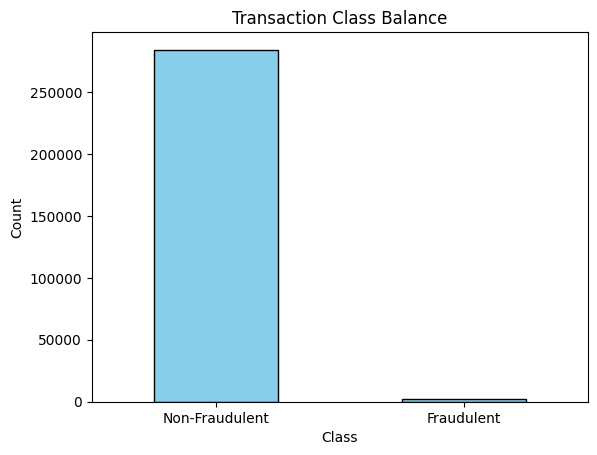

In [ ]:
# We check the Class balance between Fraudulent and Non Fraudulent transactions
print(df["Class"].value_counts())
df["Class"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Transaction Class Balance")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Non-Fraudulent", "Fraudulent"], rotation=0)
plt.show()

##Numeric Variables

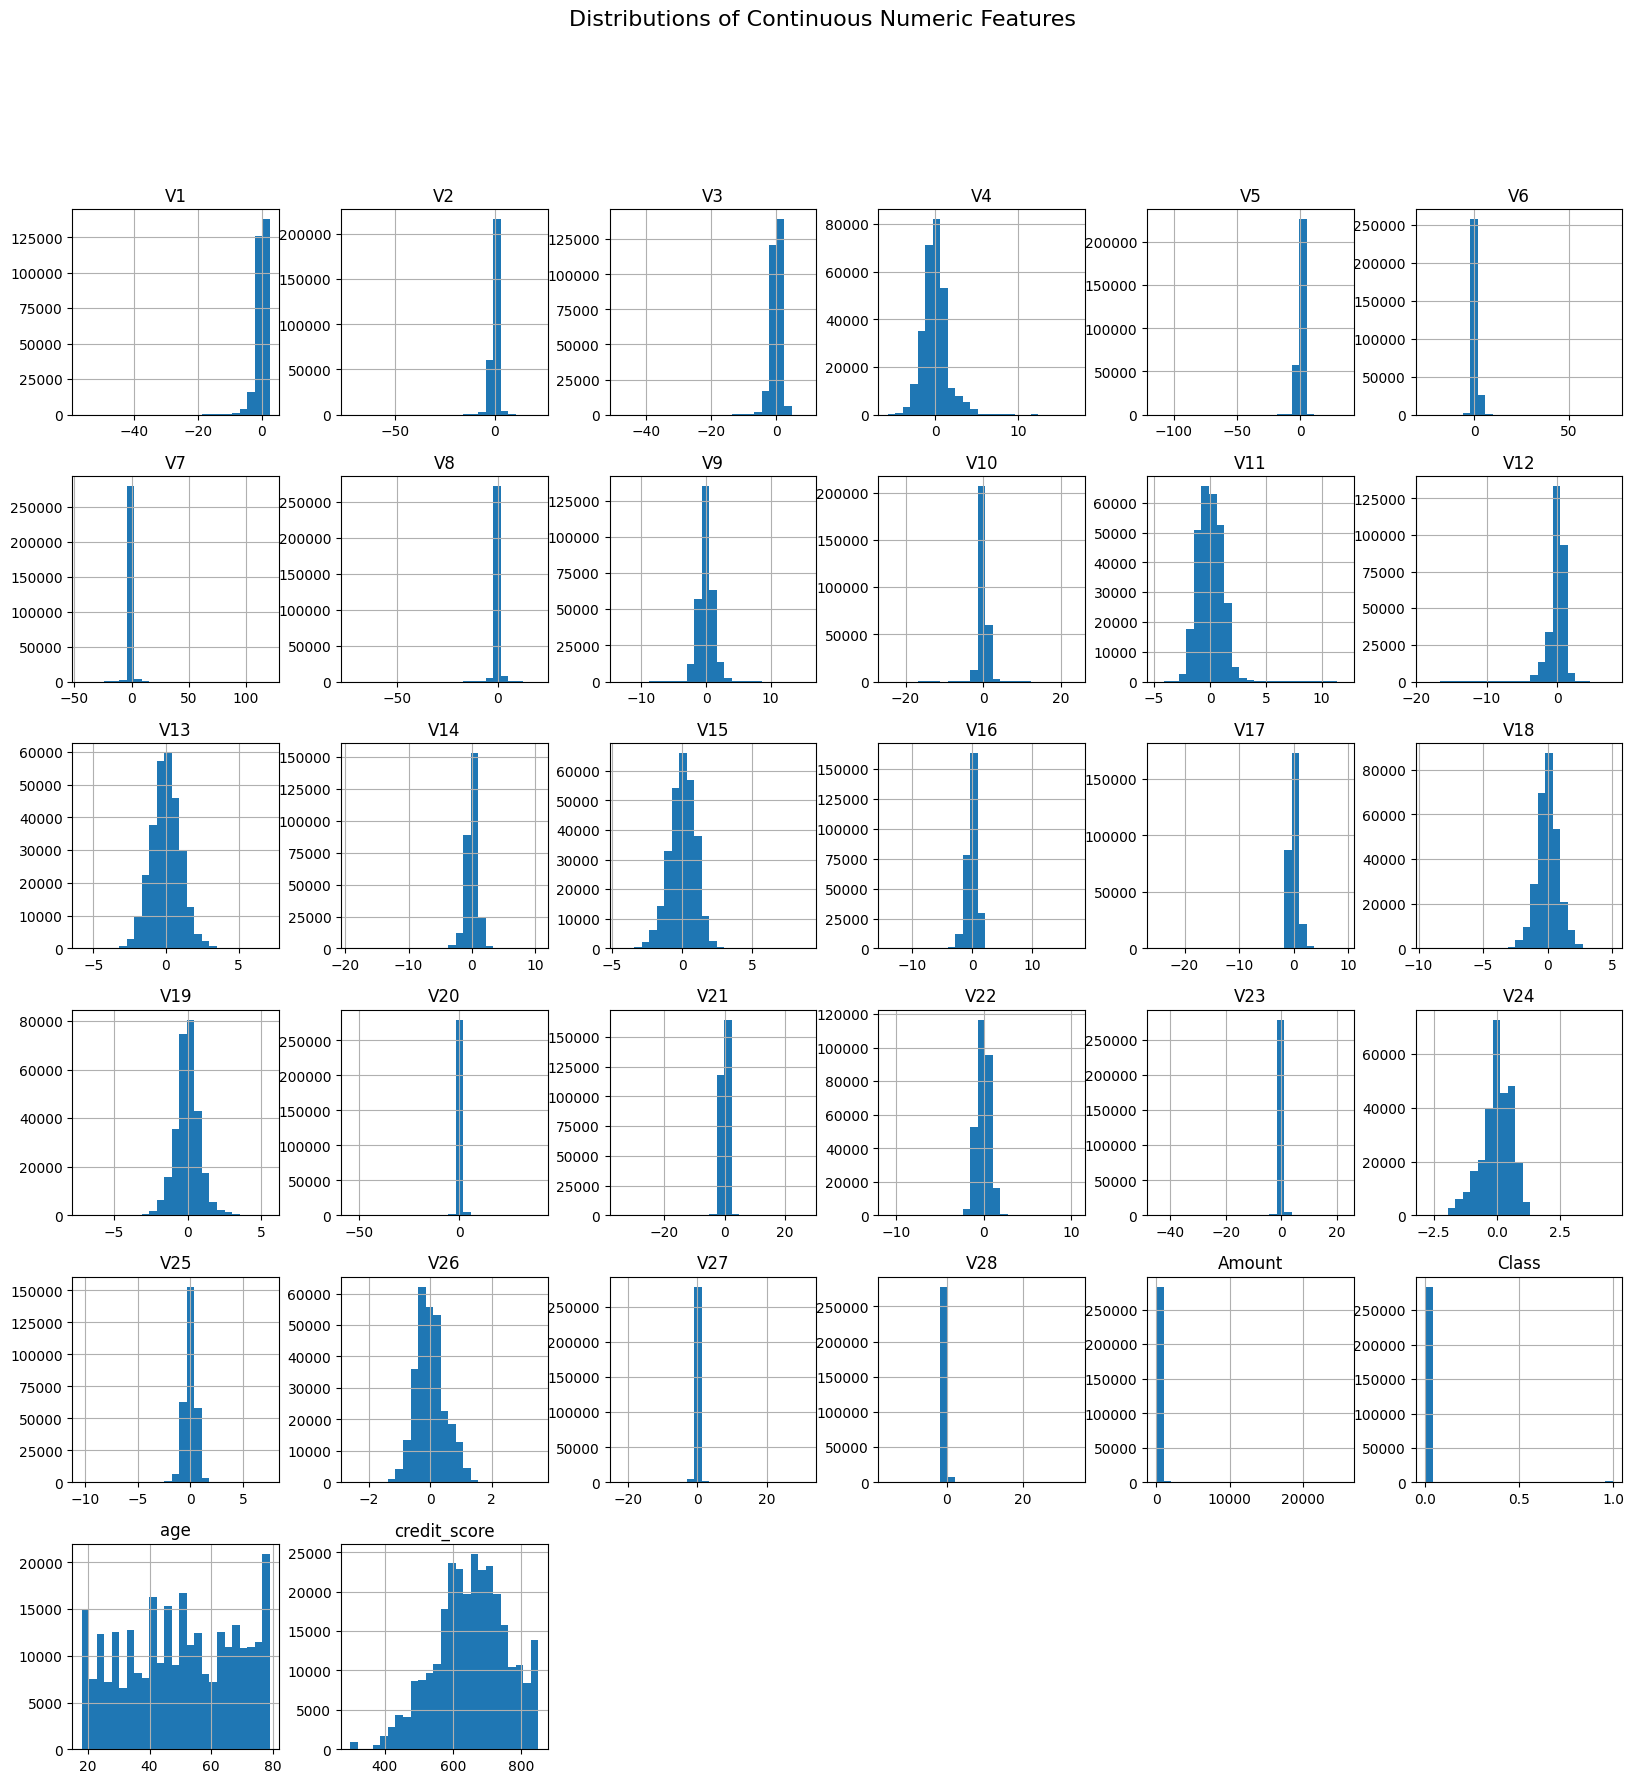

In [ ]:
numeric_df = df.select_dtypes(include="number")
# Plot histograms for continuous numeric features
numeric_df.hist(figsize=(20, 20), bins=25)
plt.suptitle("Distributions of Continuous Numeric Features", fontsize=16)
plt.show()

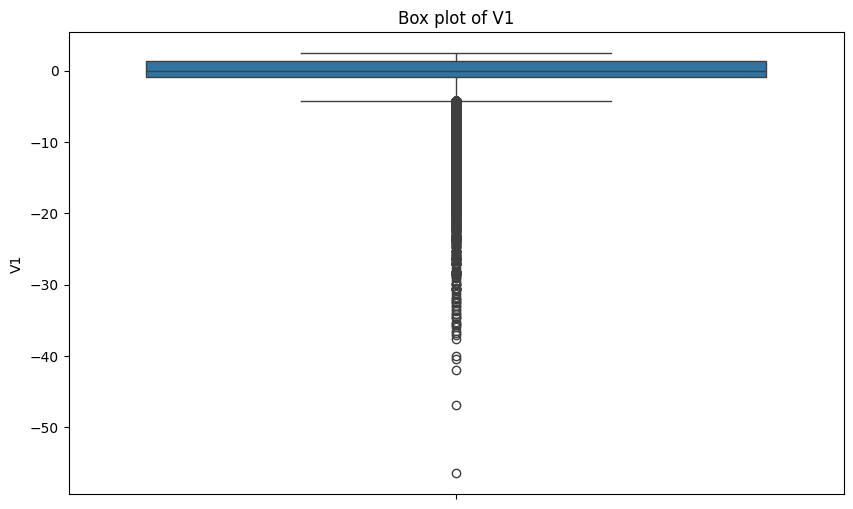

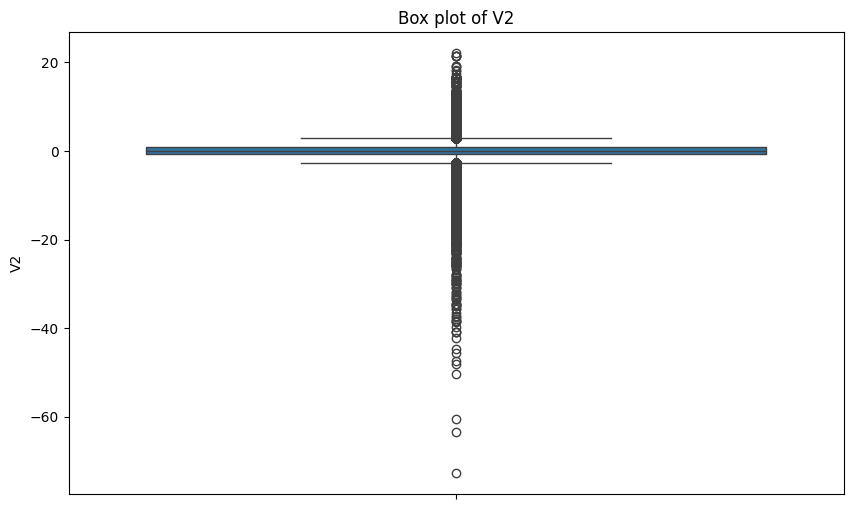

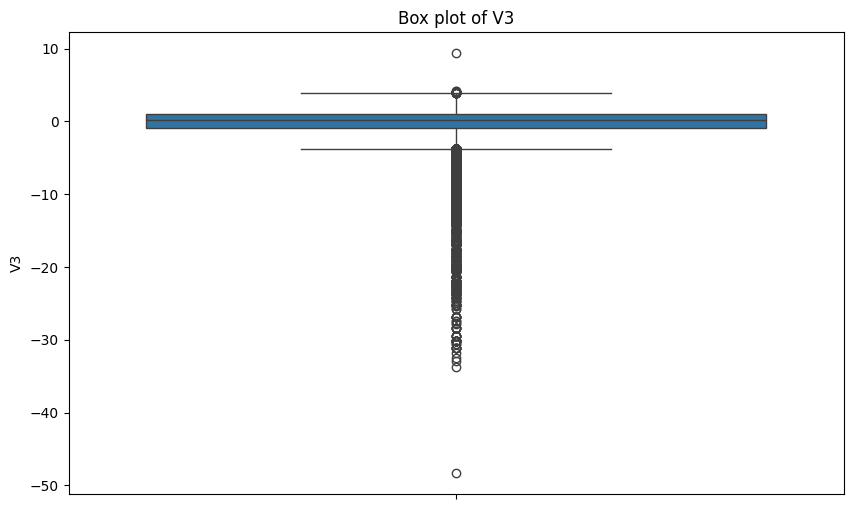

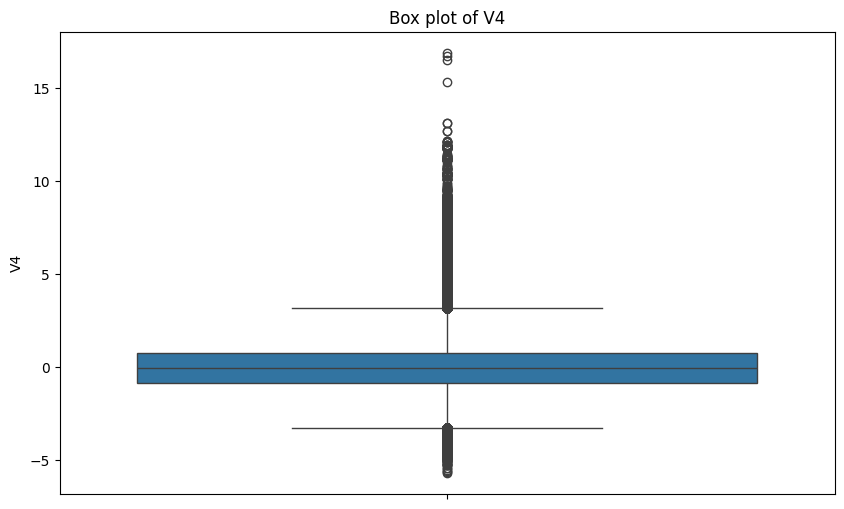

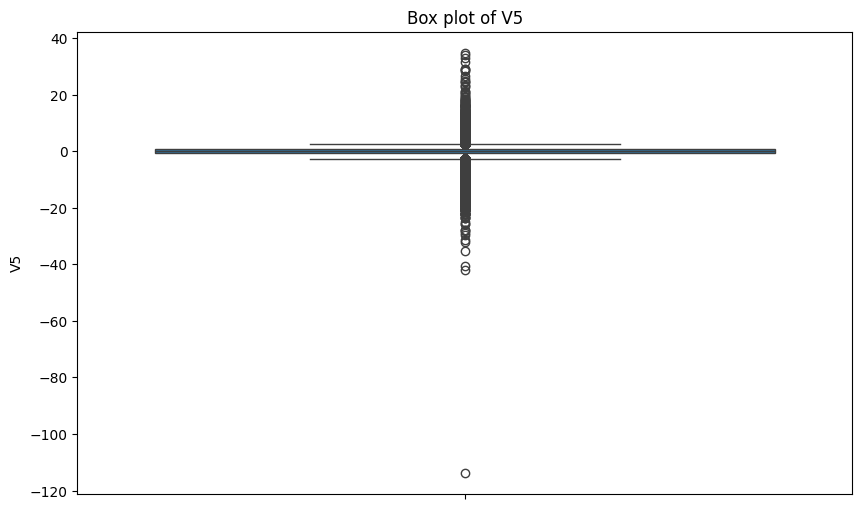

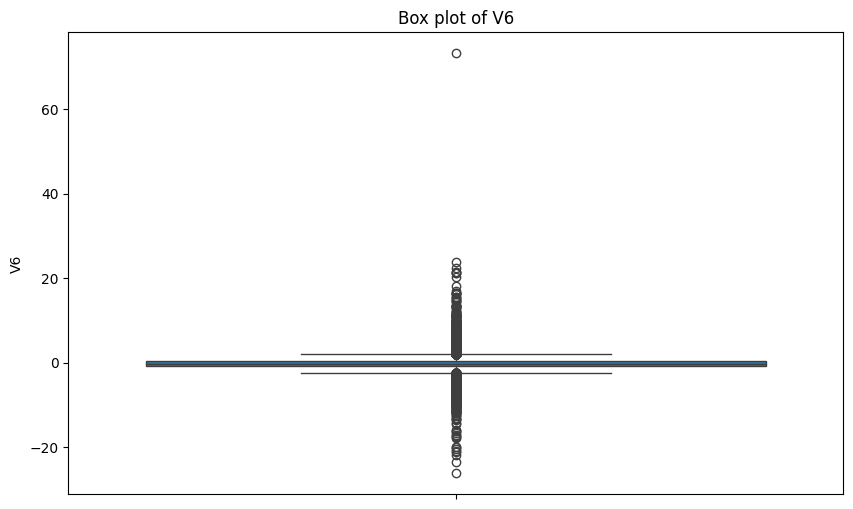

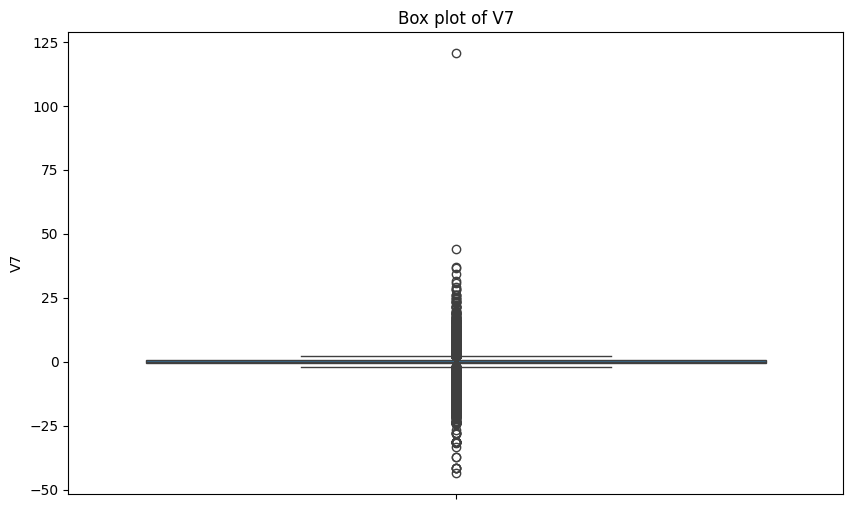

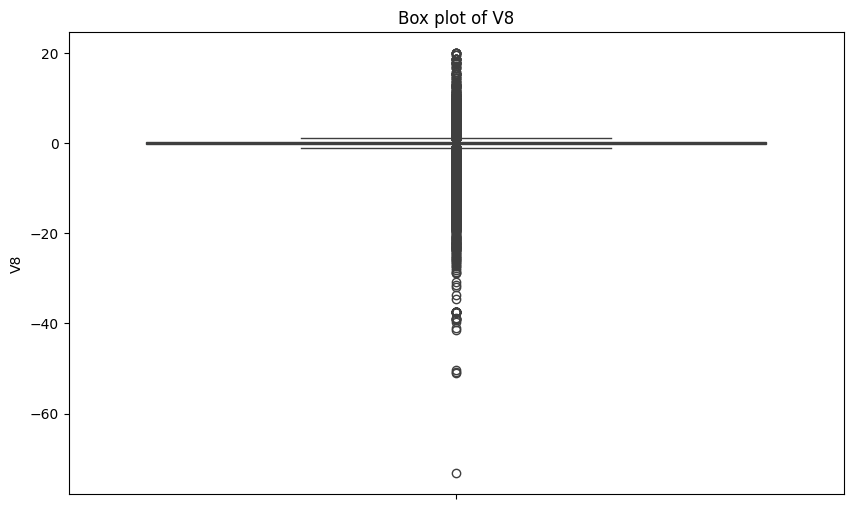

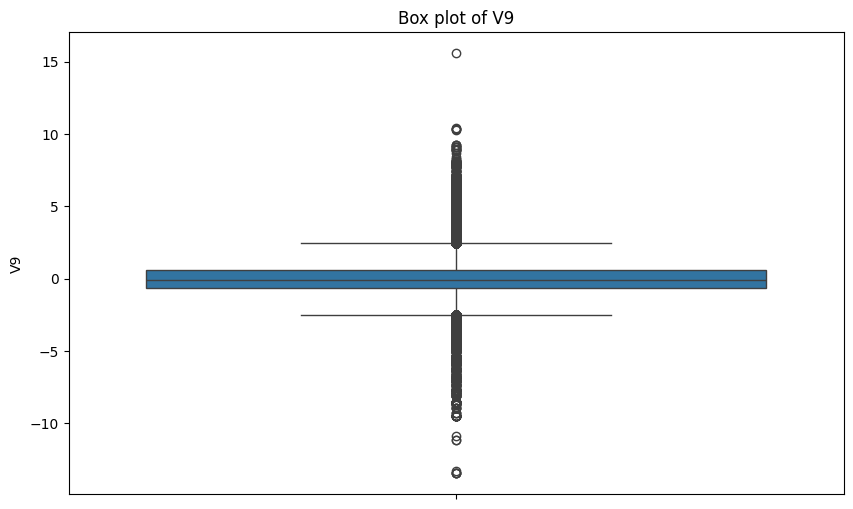

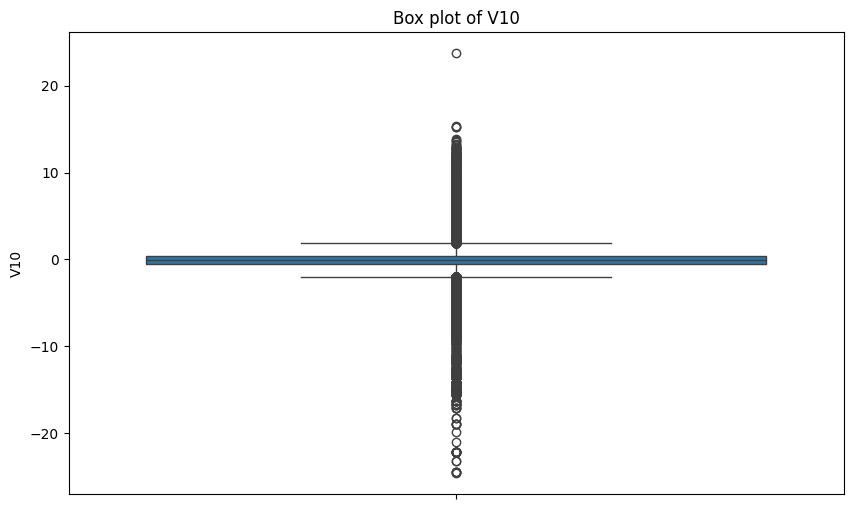

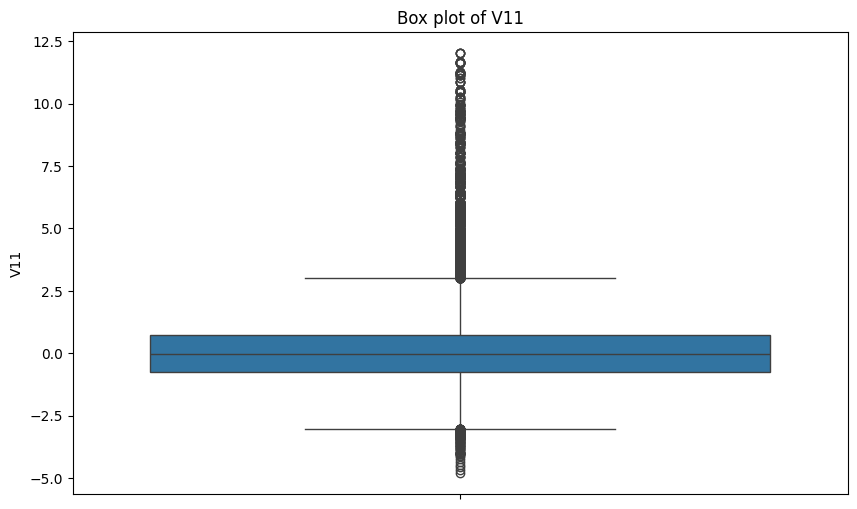

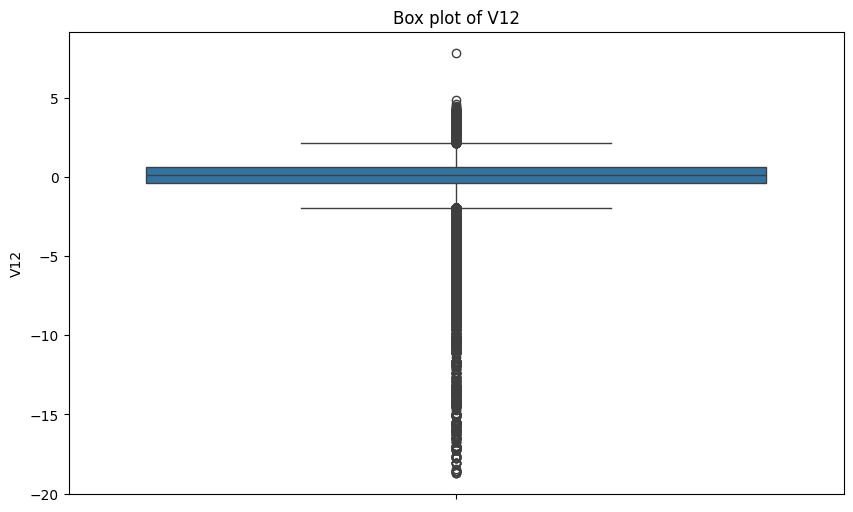

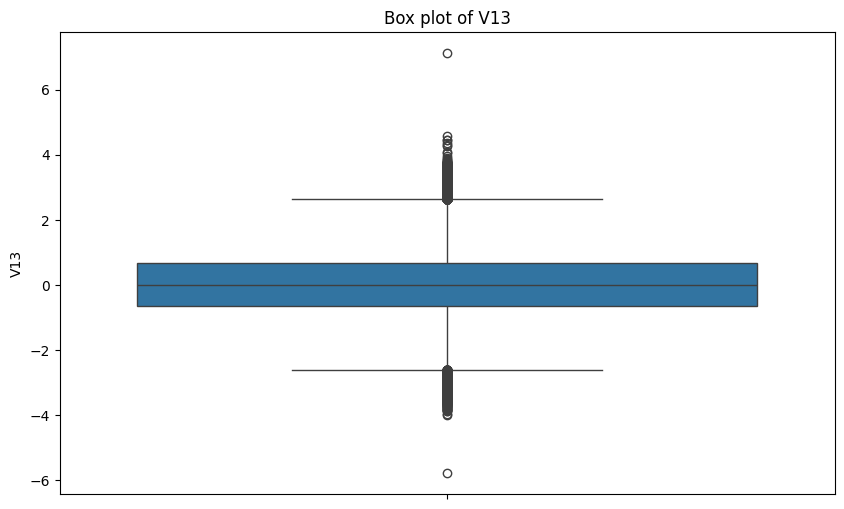

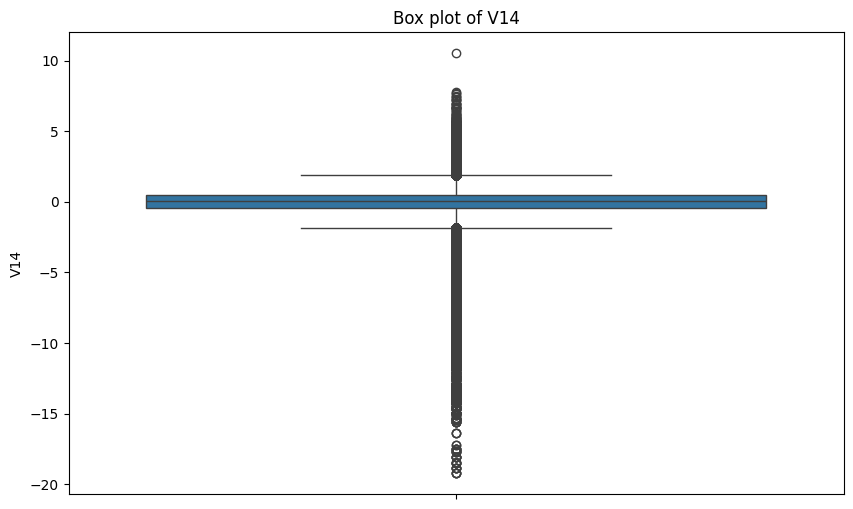

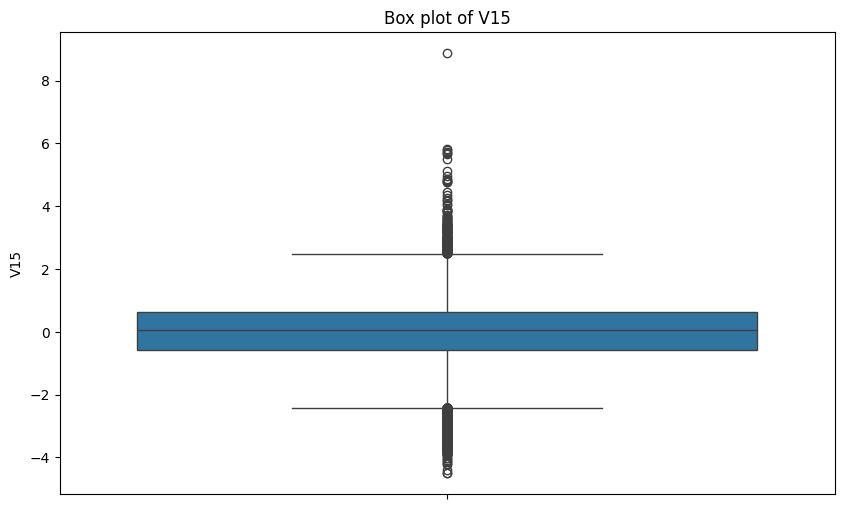

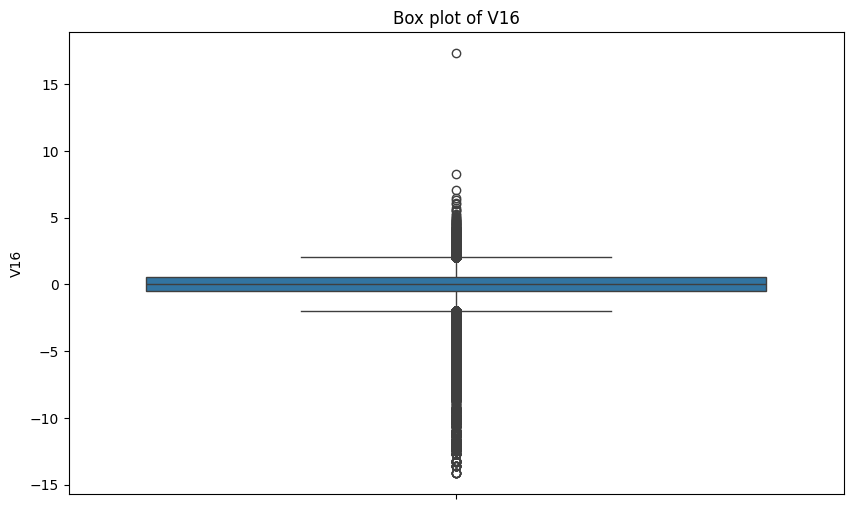

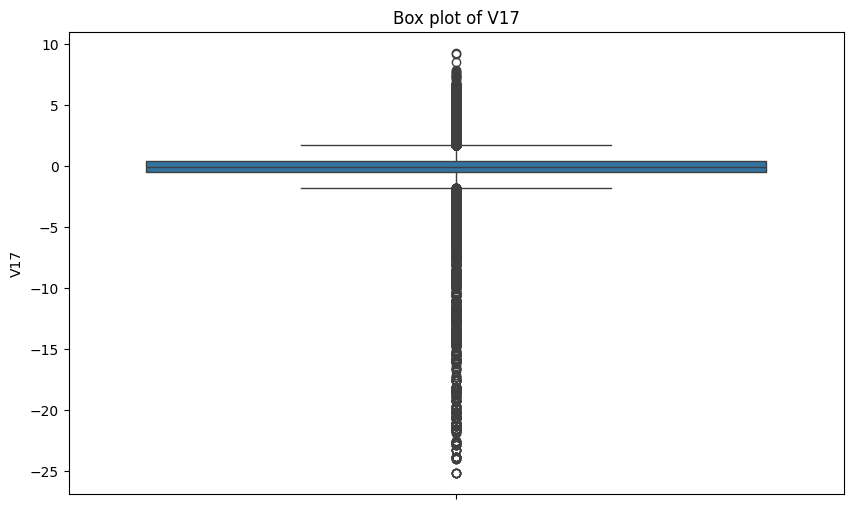

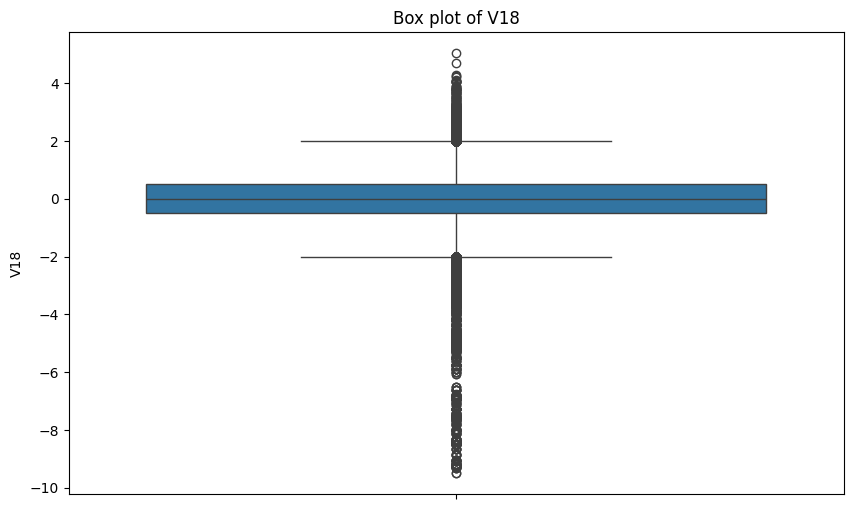

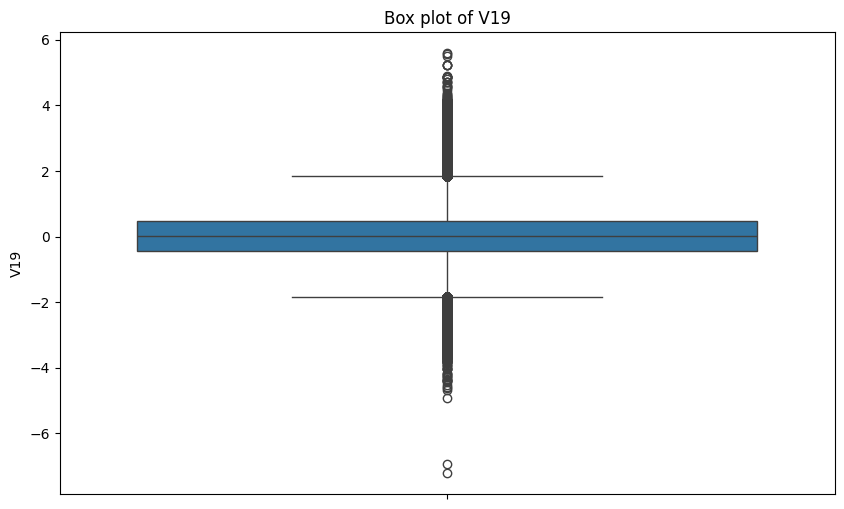

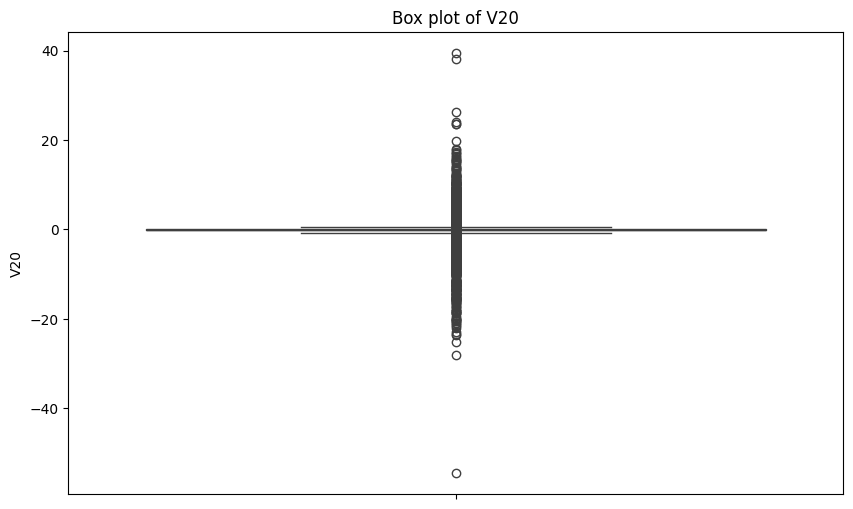

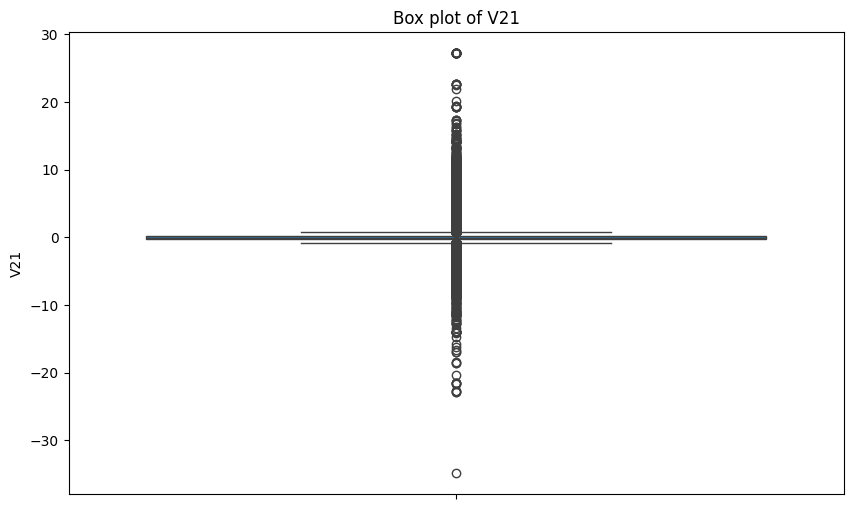

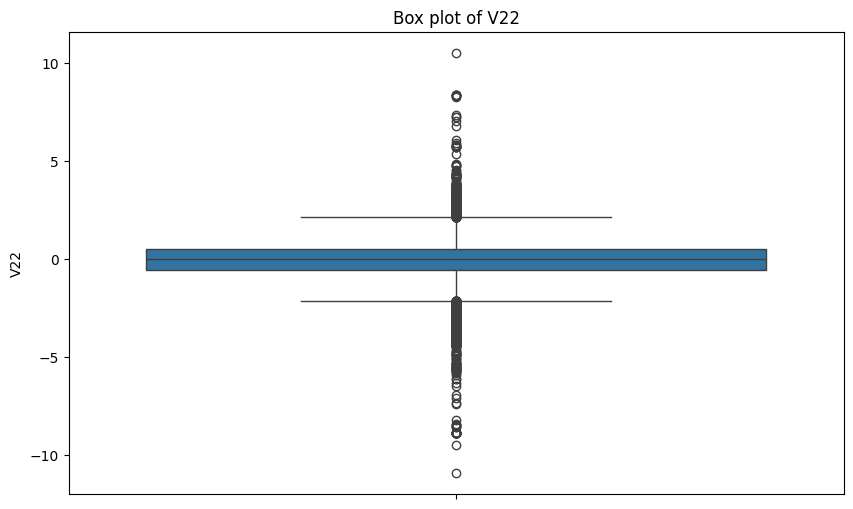

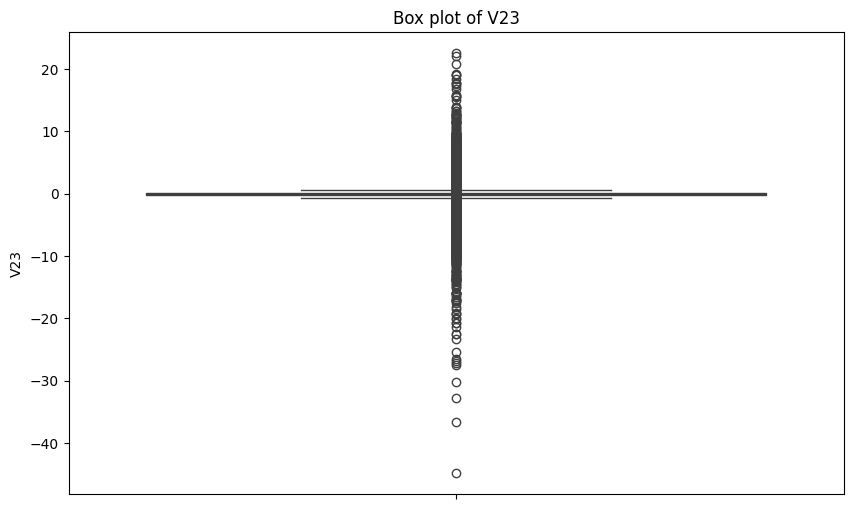

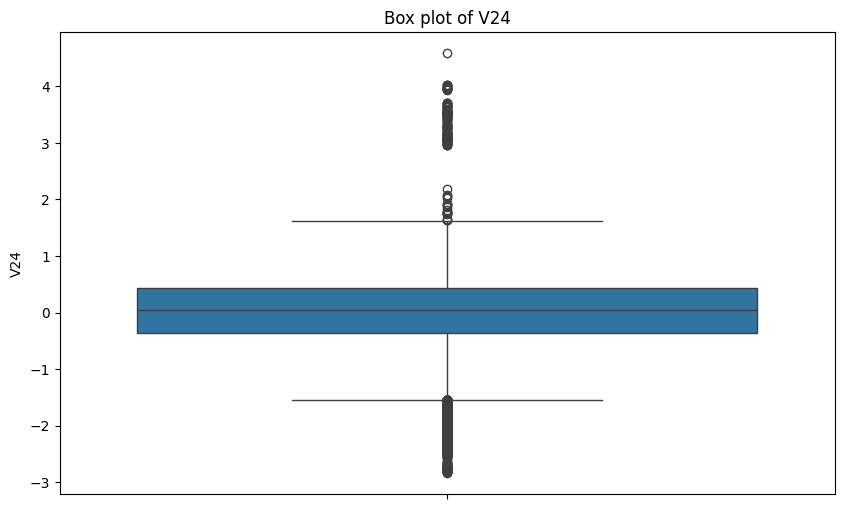

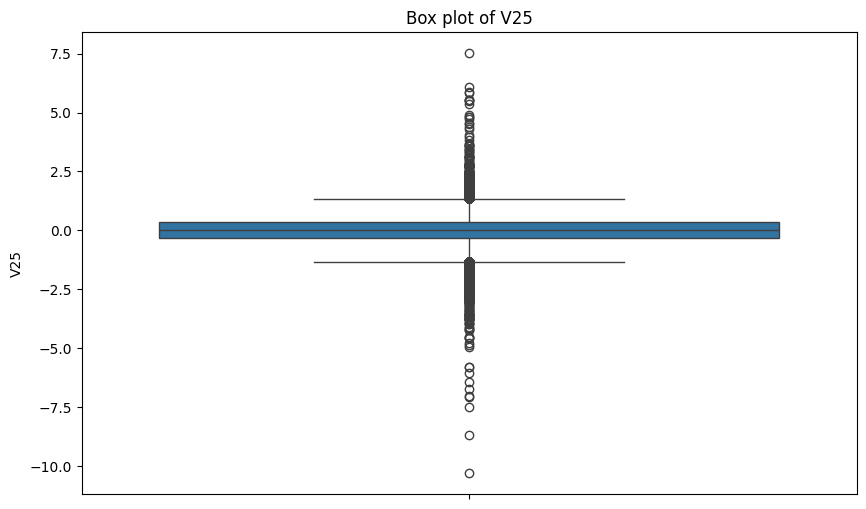

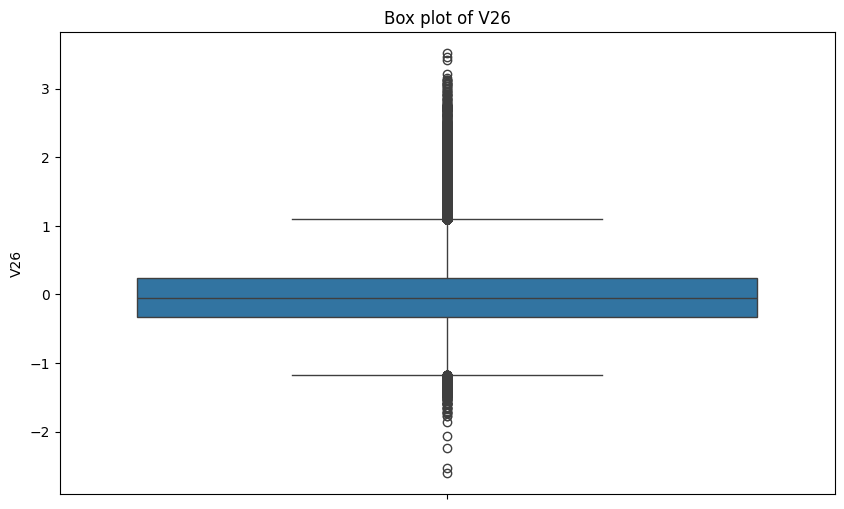

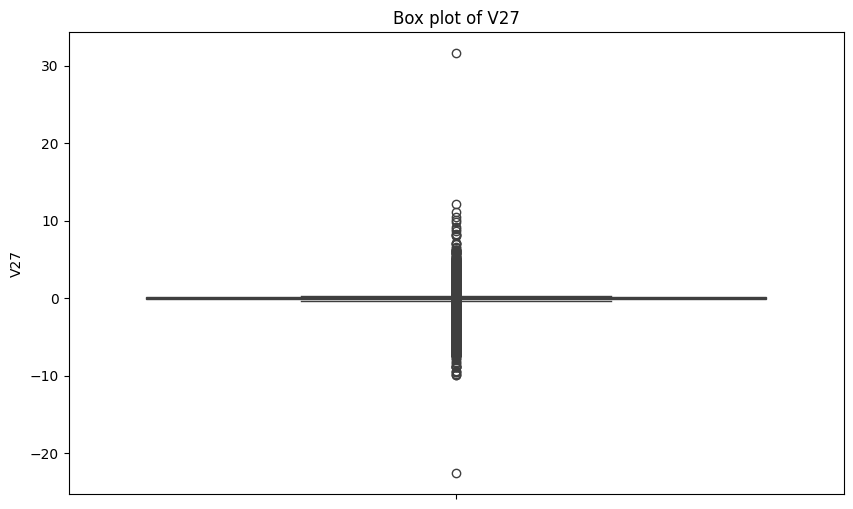

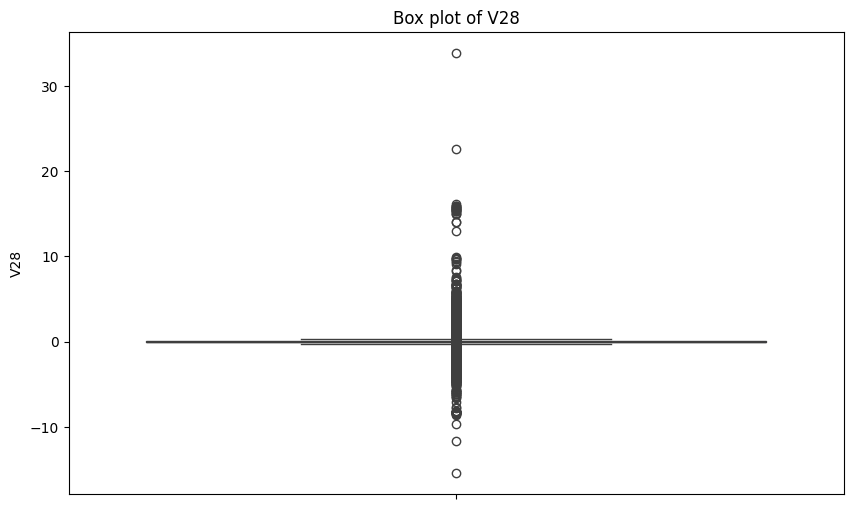

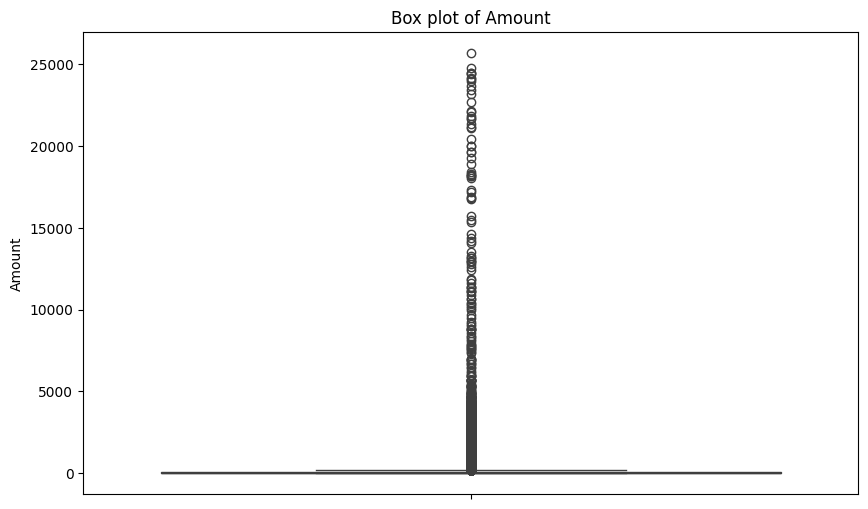

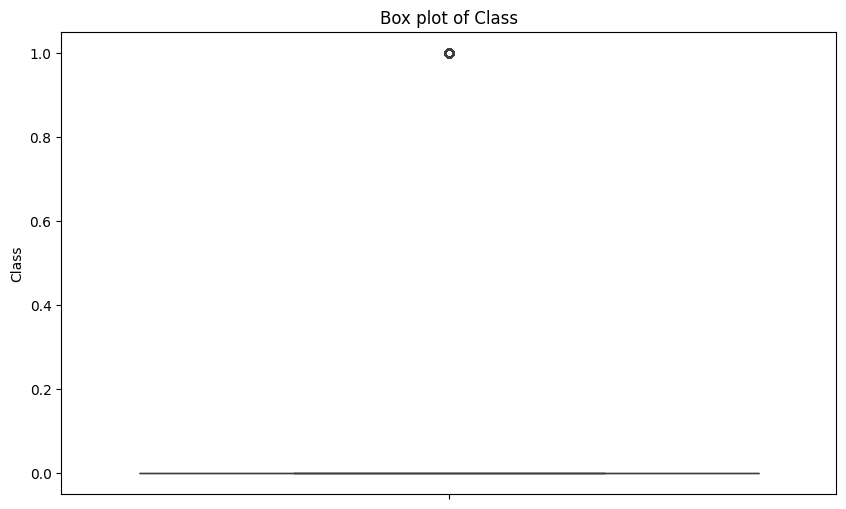

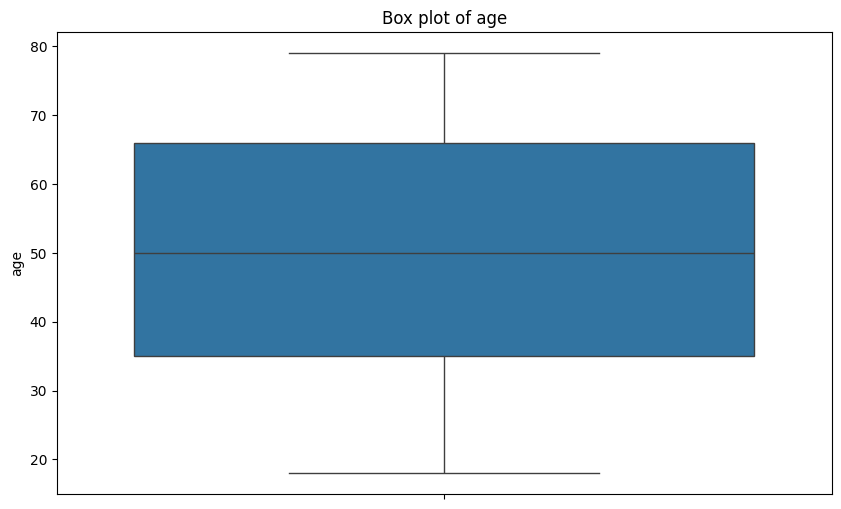

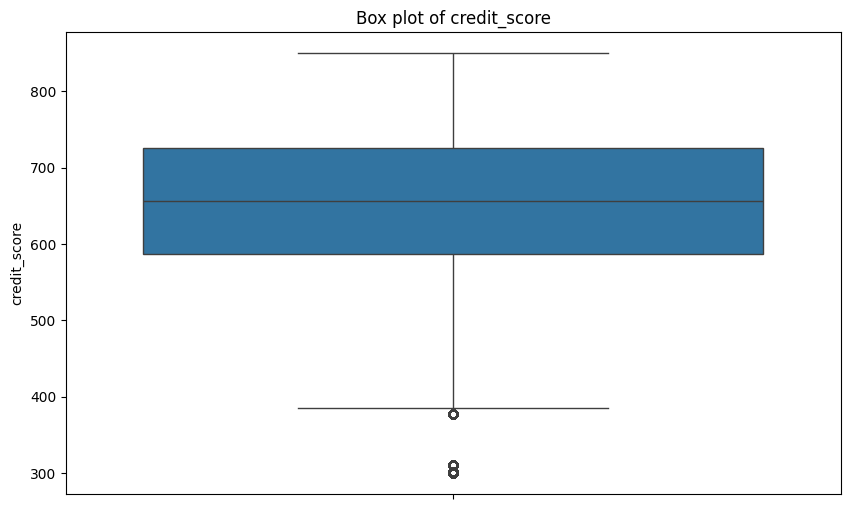

In [ ]:
for col in numeric_df:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, y=col)
    plt.title(f'Box plot of {col}')
    plt.ylabel(col)
    plt.show()


Analysis for column: V1

Descriptive statistics:


count    286068.000000
mean         -0.024078
std           2.033145
min         -56.407510
25%          -0.929249
50%           0.009588
75%           1.313415
max           2.454930
Name: V1, dtype: float64

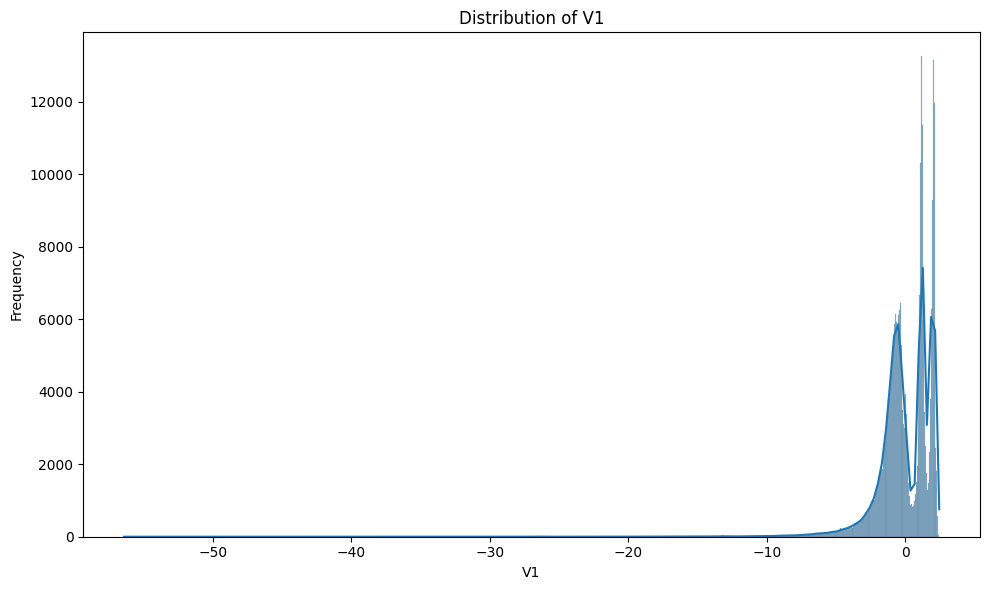

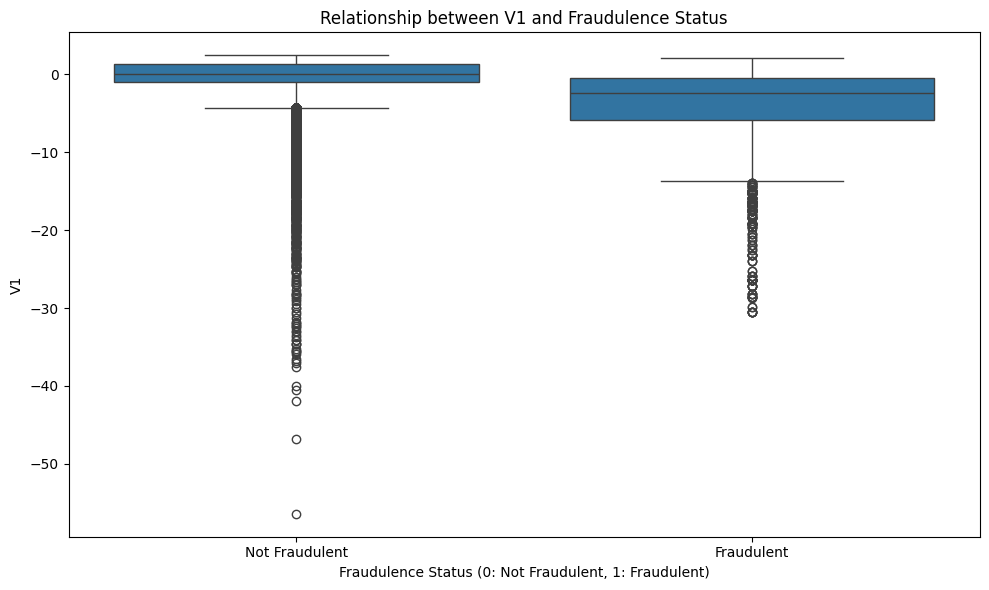


Analysis for column: V2

Descriptive statistics:


count    286068.000000
mean          0.018136
std           1.691758
min         -72.715728
25%          -0.595493
50%           0.070171
75%           0.813329
max          22.057729
Name: V2, dtype: float64

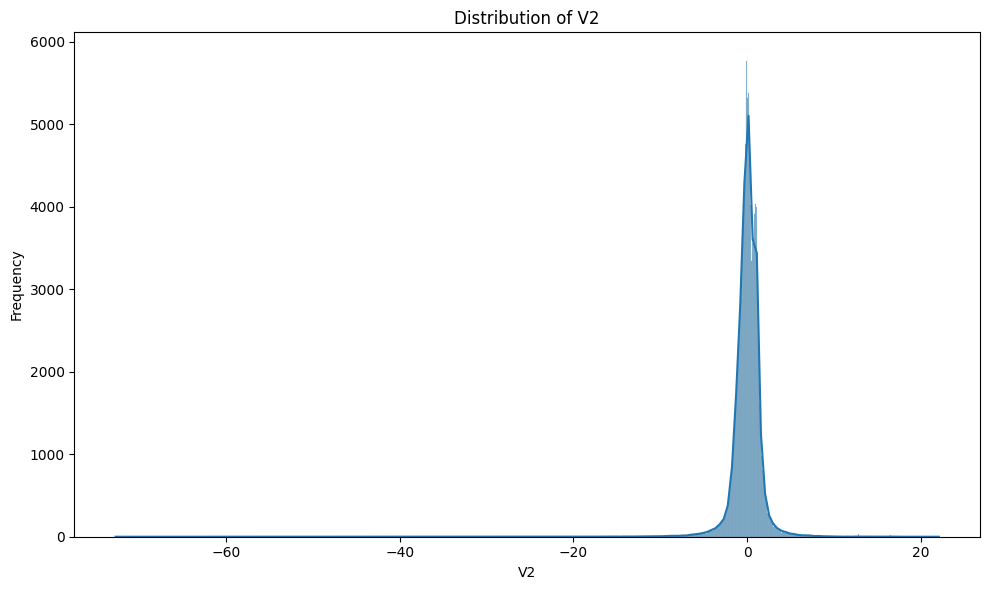

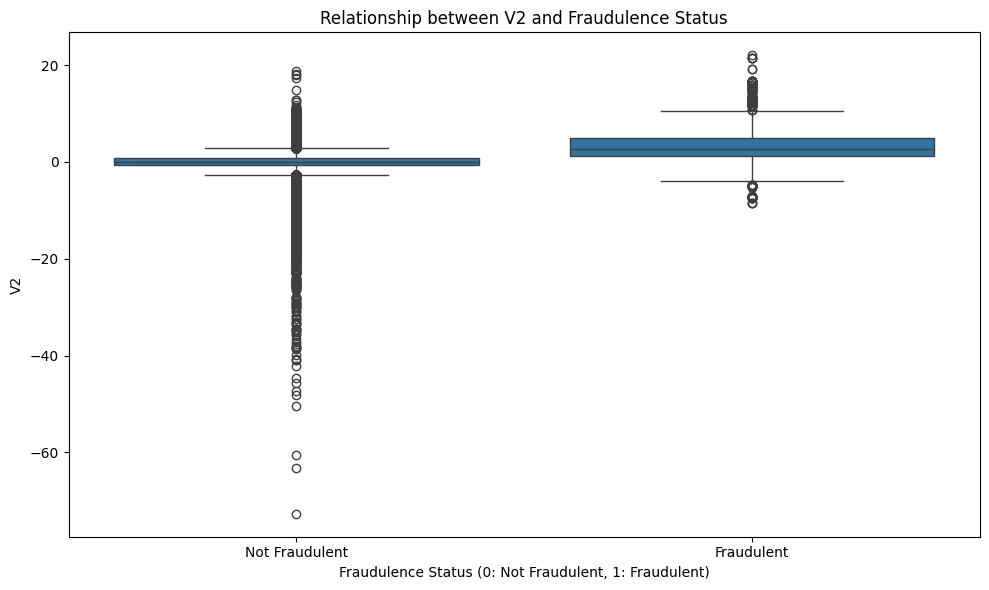


Analysis for column: V3

Descriptive statistics:


count    286068.000000
mean         -0.035556
std           1.664213
min         -48.325589
25%          -0.907538
50%           0.172895
75%           1.023143
max           9.382558
Name: V3, dtype: float64

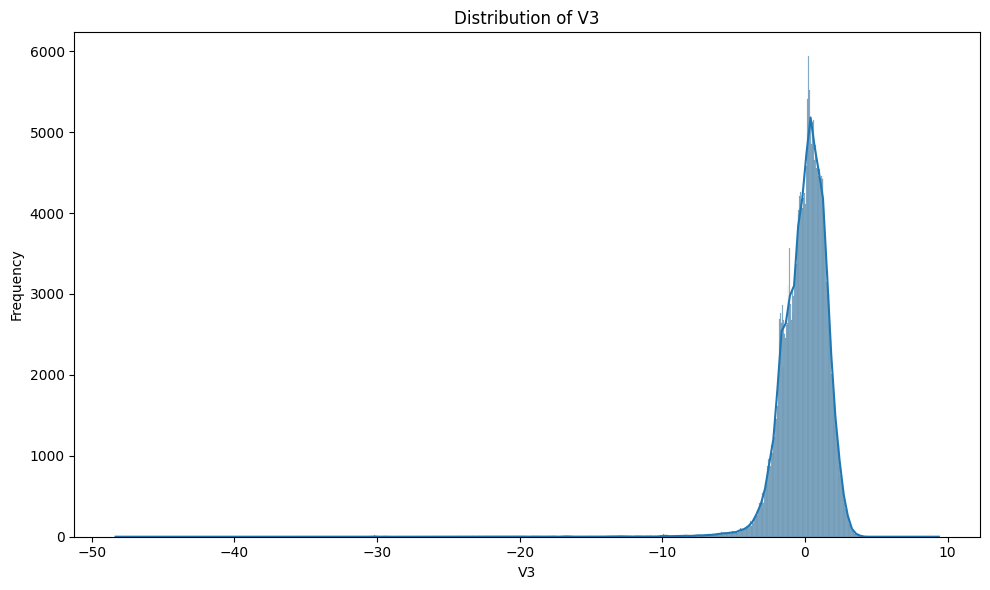

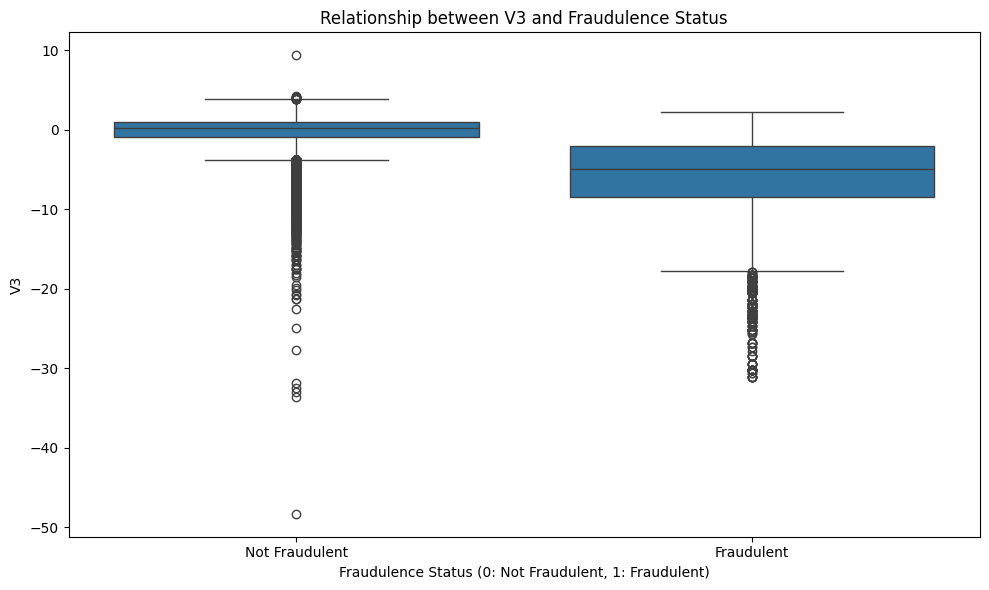


Analysis for column: V4

Descriptive statistics:


count    286068.000000
mean          0.023738
std           1.465148
min          -5.683171
25%          -0.843739
50%          -0.011542
75%           0.759185
max          16.875344
Name: V4, dtype: float64

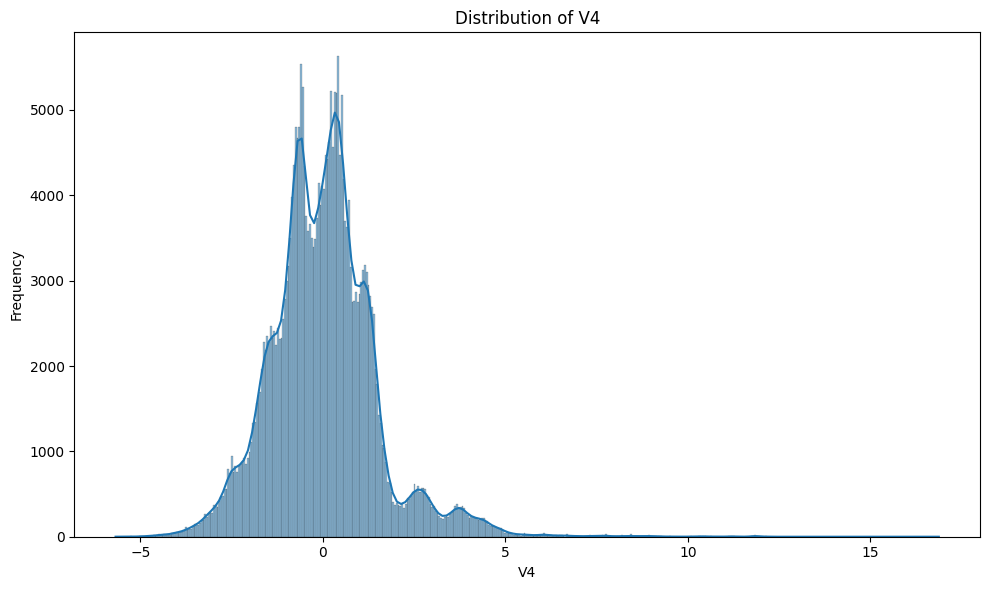

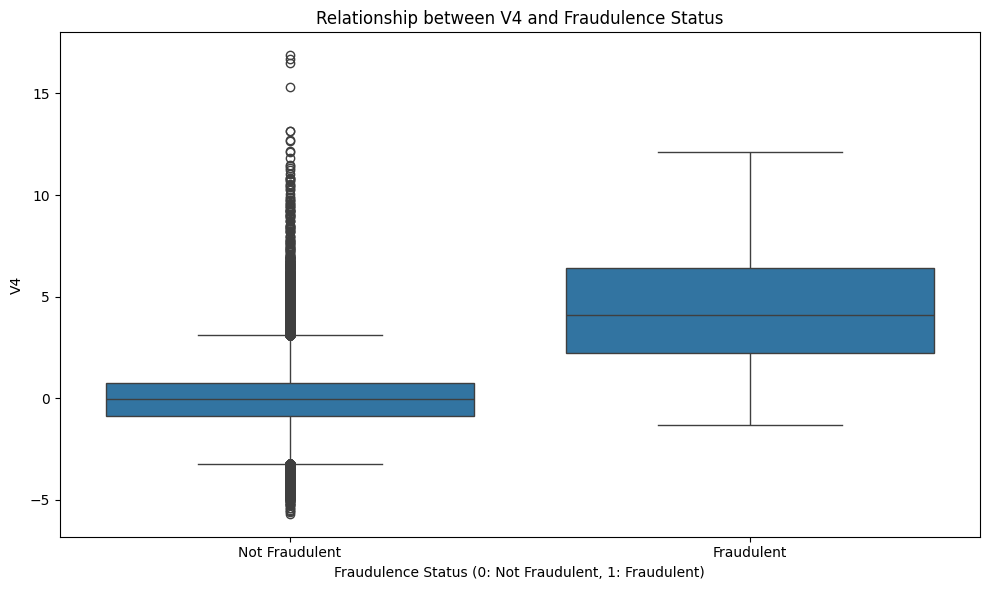


Analysis for column: V5

Descriptive statistics:


count    286068.000000
mean         -0.015413
std           1.439697
min        -113.743307
25%          -0.697567
50%          -0.057168
75%           0.610658
max          34.801666
Name: V5, dtype: float64

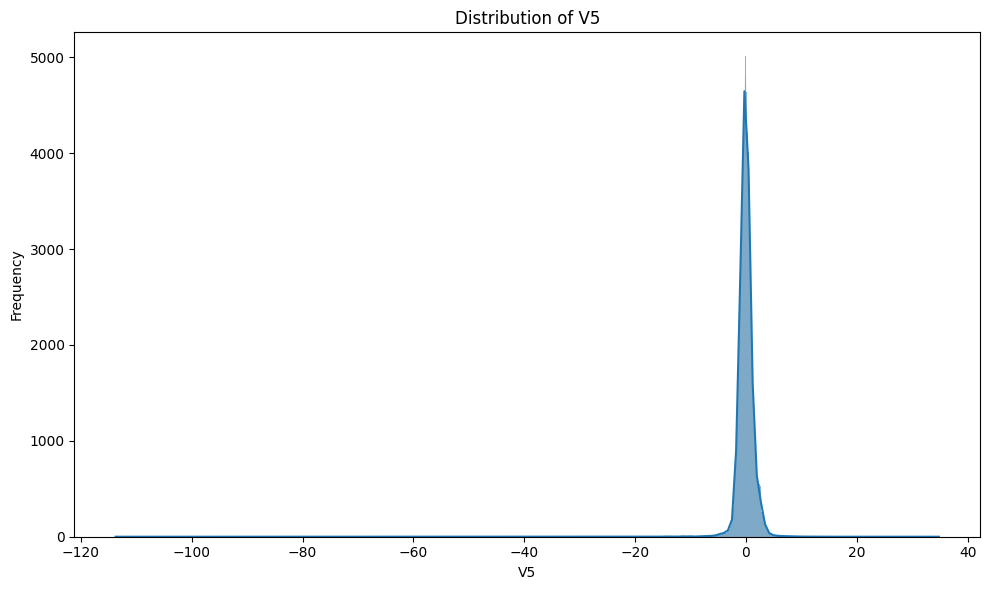

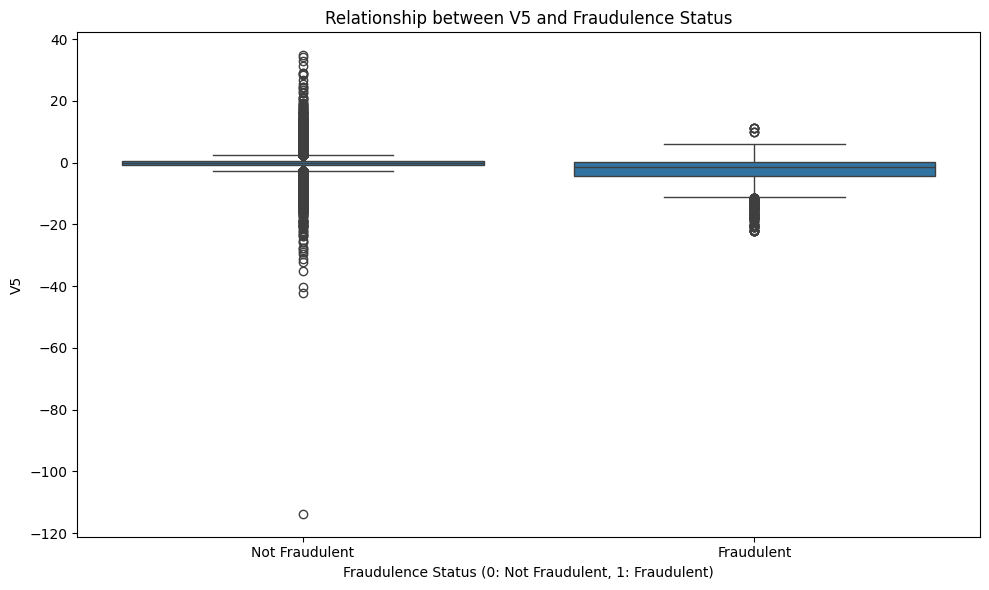


Analysis for column: V6

Descriptive statistics:


count    286068.000000
mean         -0.006977
std           1.338767
min         -26.160506
25%          -0.773016
50%          -0.277320
75%           0.395737
max          73.301626
Name: V6, dtype: float64

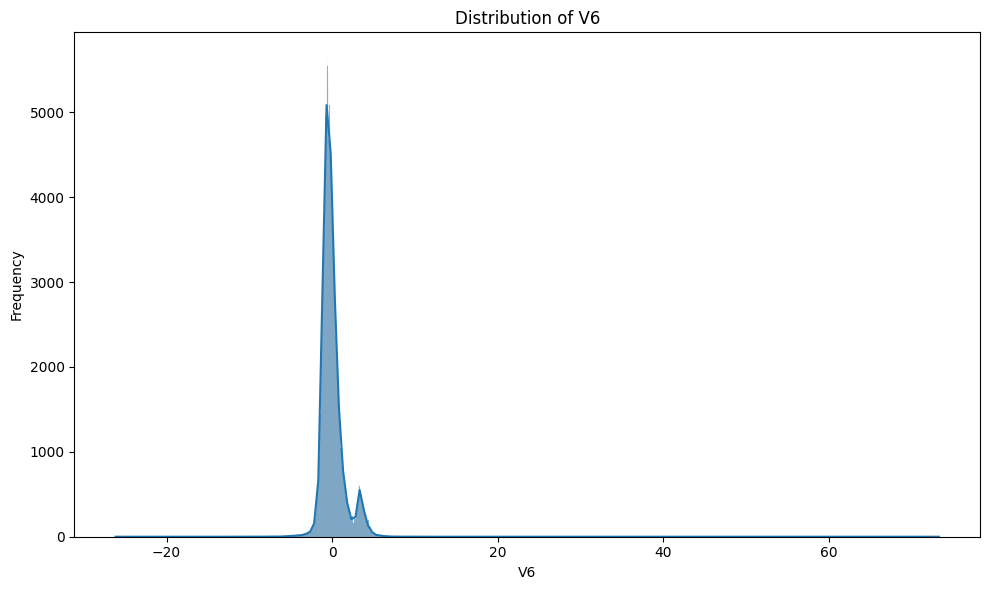

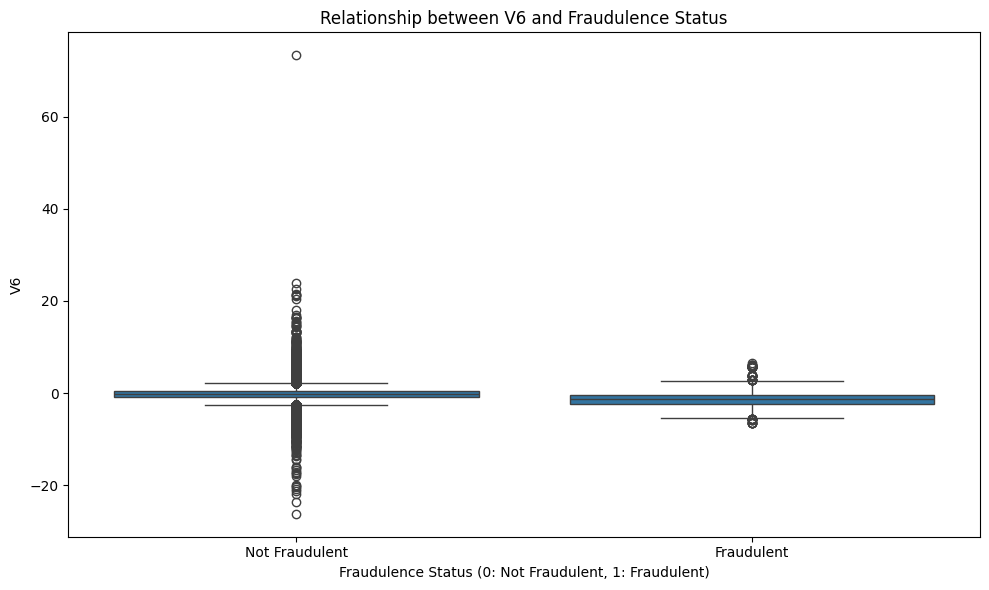


Analysis for column: V7

Descriptive statistics:


count    286068.000000
mean         -0.028241
std           1.383775
min         -43.557242
25%          -0.560966
50%           0.036978
75%           0.568443
max         120.589494
Name: V7, dtype: float64

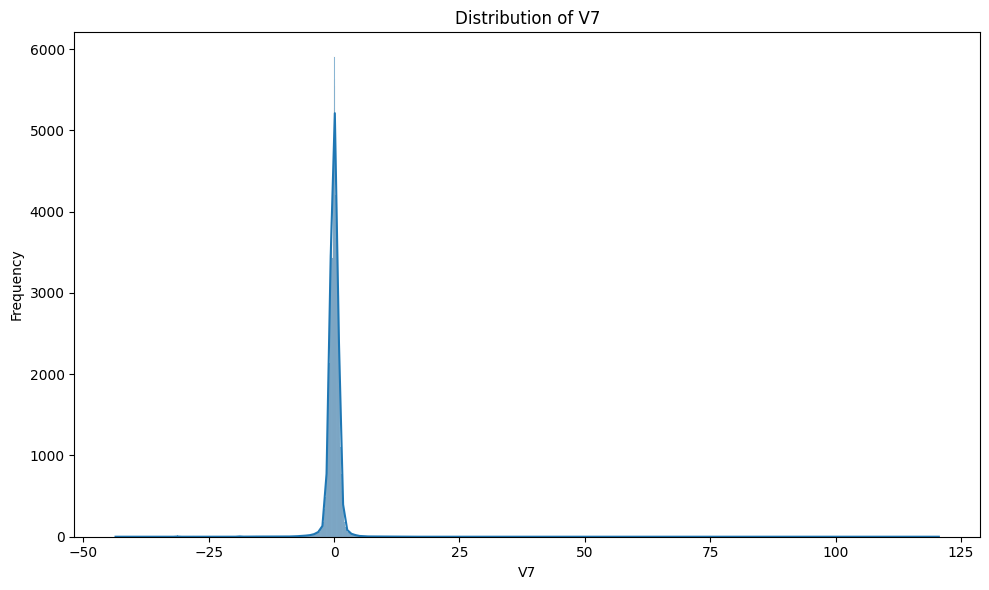

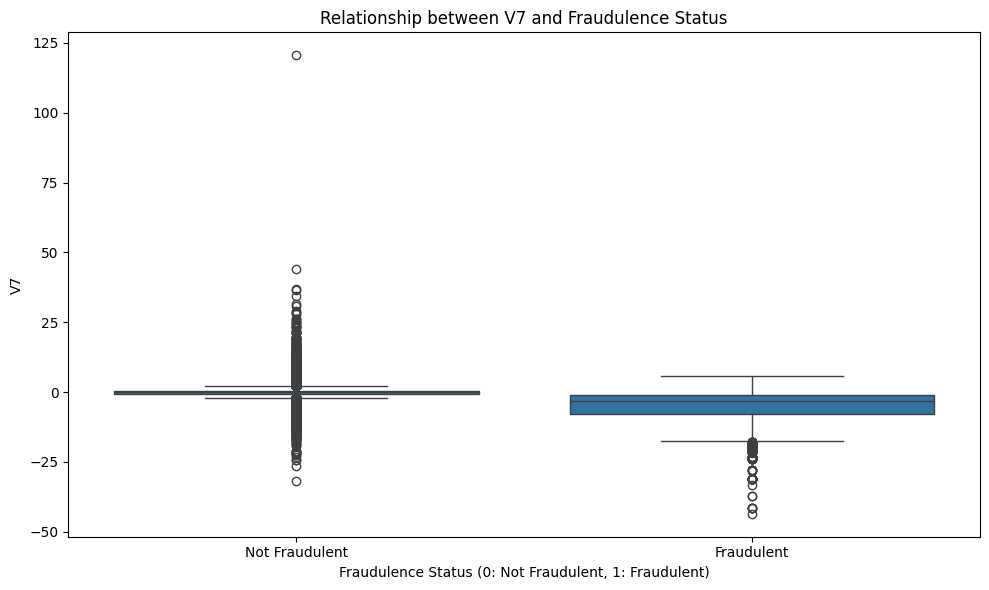


Analysis for column: V8

Descriptive statistics:


count    286068.000000
mean          0.001797
std           1.285618
min         -73.216718
25%          -0.208740
50%           0.023125
75%           0.330566
max          20.007208
Name: V8, dtype: float64

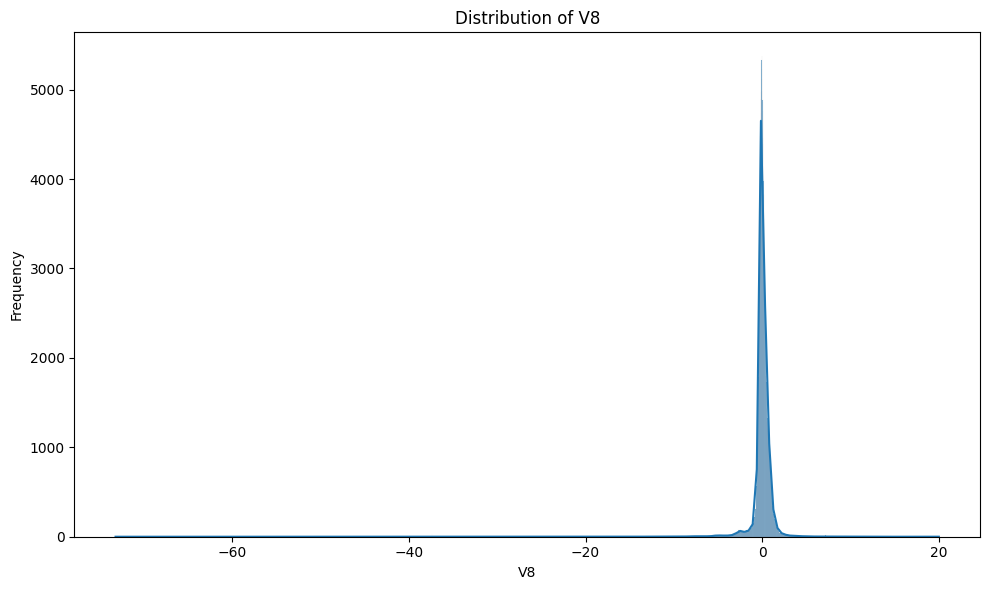

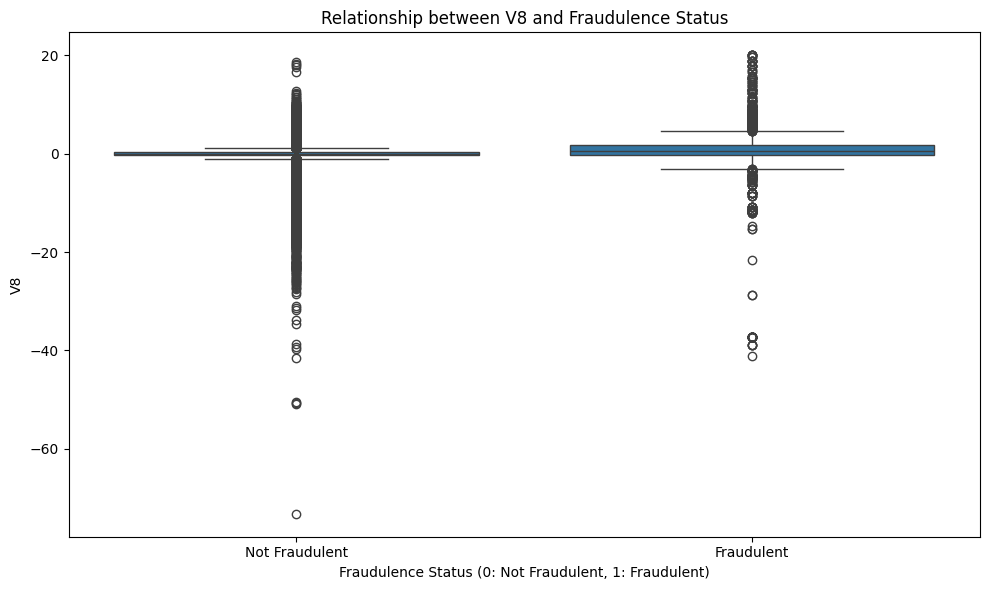


Analysis for column: V9

Descriptive statistics:


count    286068.000000
mean         -0.013032
std           1.124926
min         -13.434066
25%          -0.651261
50%          -0.054387
75%           0.594063
max          15.594995
Name: V9, dtype: float64

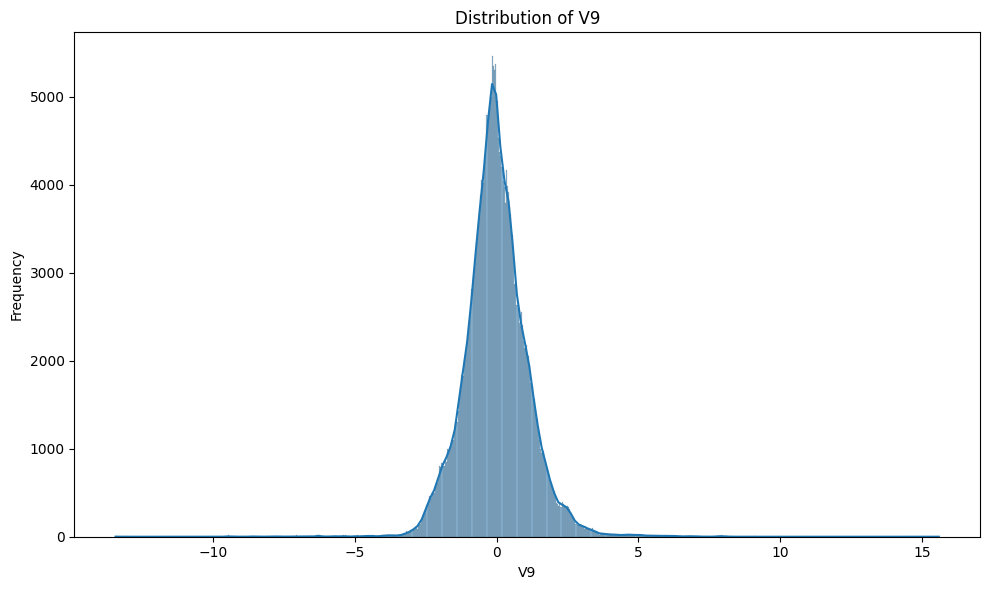

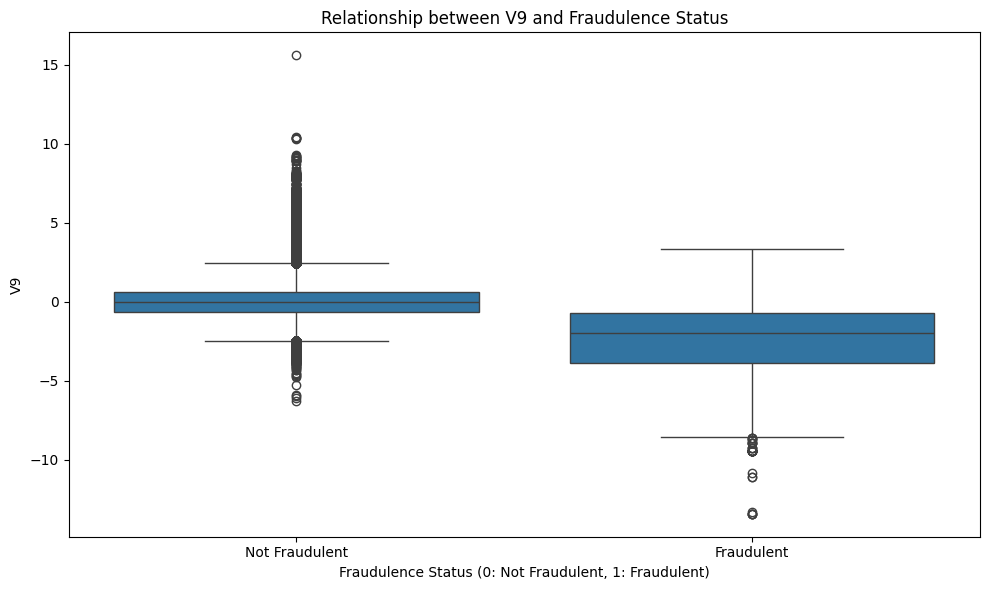


Analysis for column: V10

Descriptive statistics:


count    286068.000000
mean         -0.029219
std           1.209557
min         -24.588262
25%          -0.542023
50%          -0.096172
75%           0.449692
max          23.745136
Name: V10, dtype: float64

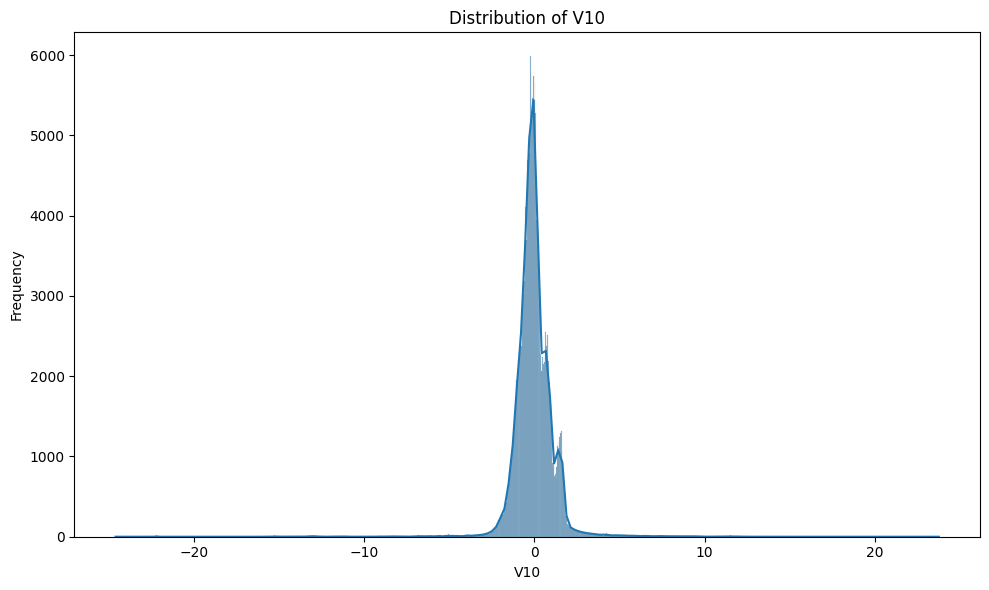

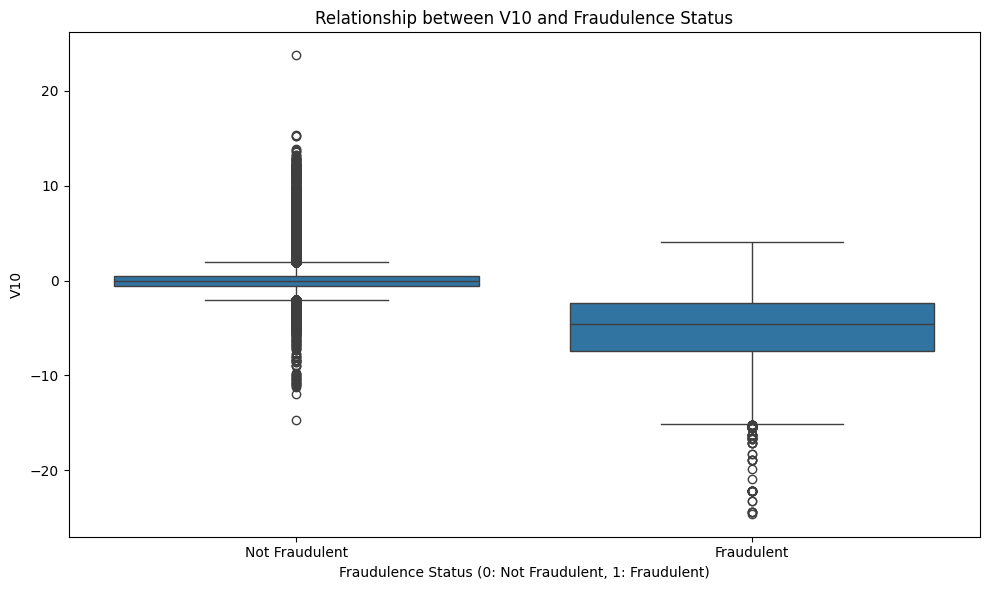


Analysis for column: V11

Descriptive statistics:


count    286068.000000
mean          0.020256
std           1.073431
min          -4.797473
25%          -0.758952
50%          -0.026328
75%           0.750799
max          12.018913
Name: V11, dtype: float64

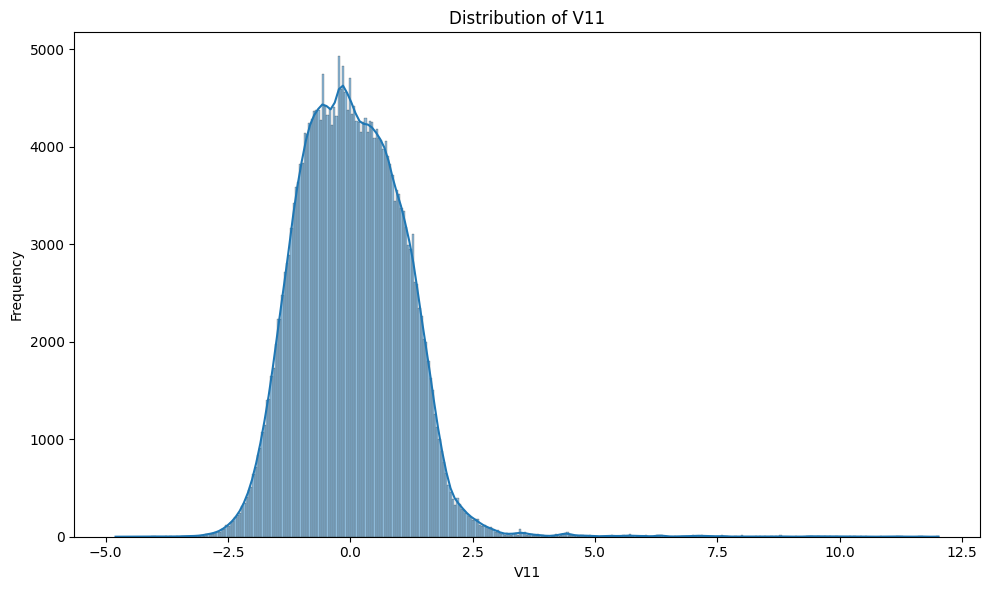

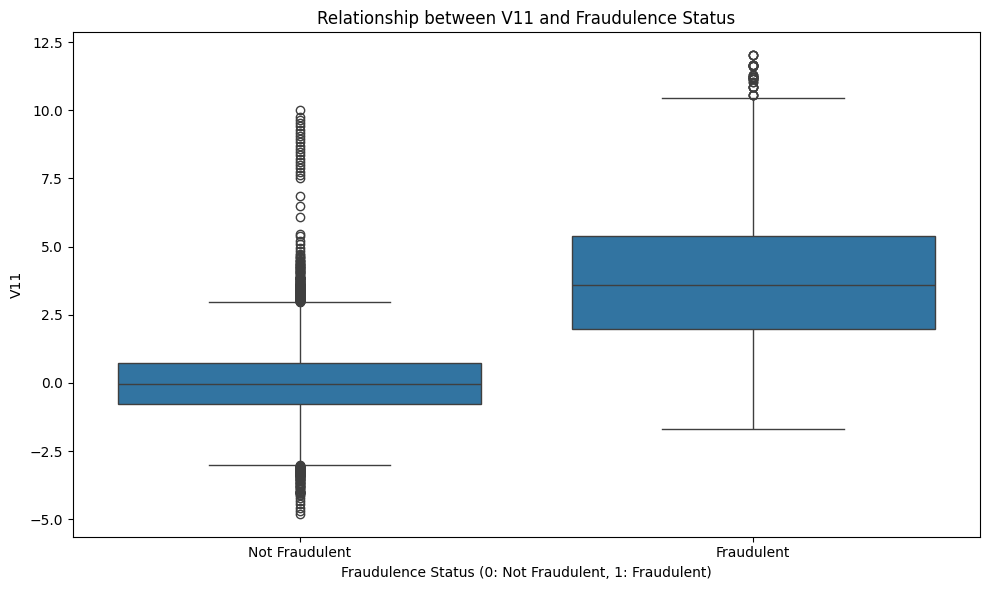


Analysis for column: V12

Descriptive statistics:


count    286068.000000
mean         -0.033178
std           1.148085
min         -18.683715
25%          -0.415247
50%           0.135208
75%           0.615595
max           7.848392
Name: V12, dtype: float64

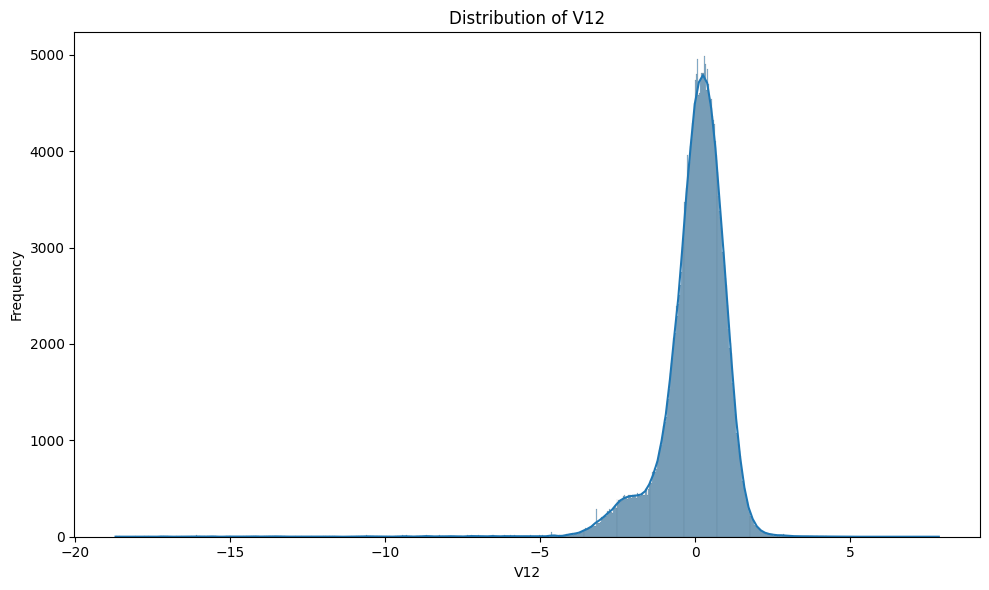

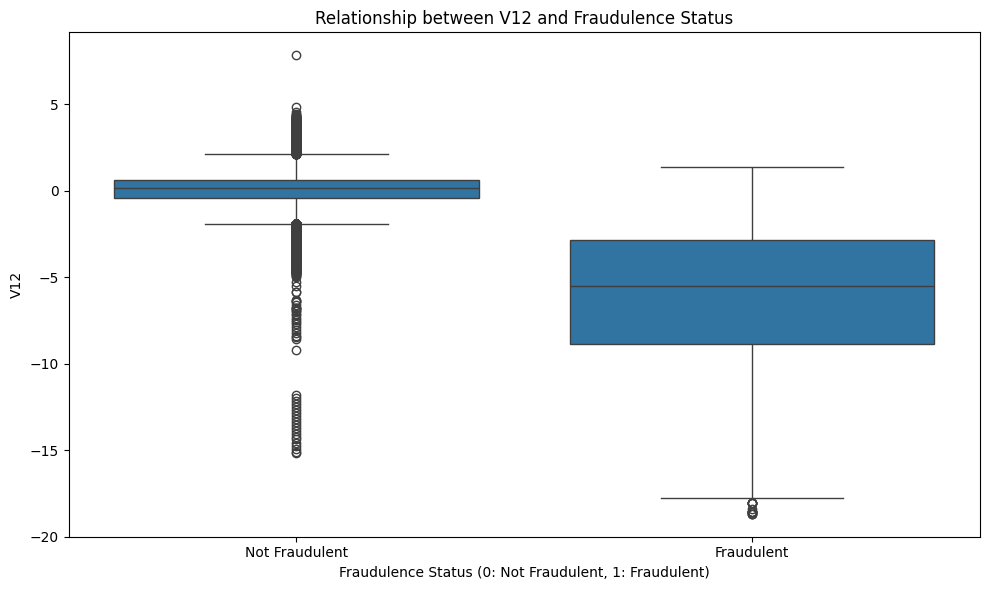


Analysis for column: V13

Descriptive statistics:


count    286068.000000
mean         -0.000297
std           0.996079
min          -5.791881
25%          -0.649792
50%          -0.013552
75%           0.663091
max           7.126883
Name: V13, dtype: float64

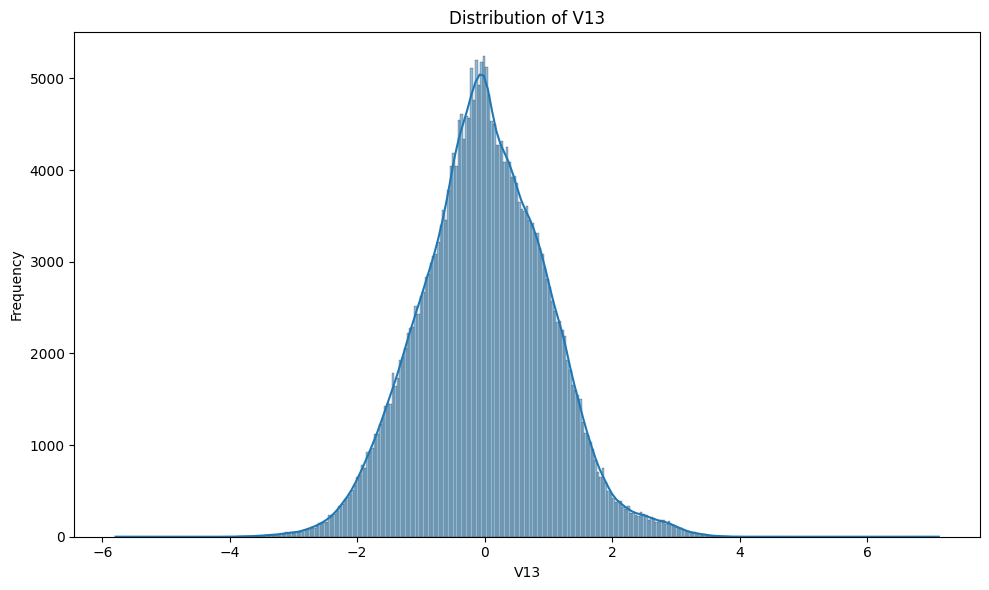

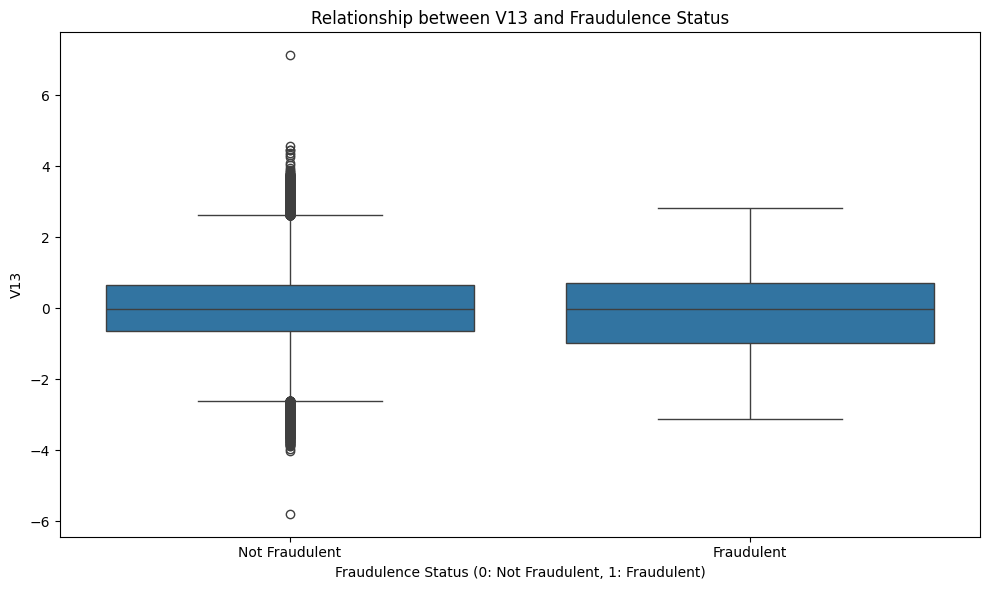


Analysis for column: V14

Descriptive statistics:


count    286068.000000
mean         -0.037345
std           1.130211
min         -19.214325
25%          -0.434167
50%           0.046806
75%           0.490607
max          10.526766
Name: V14, dtype: float64

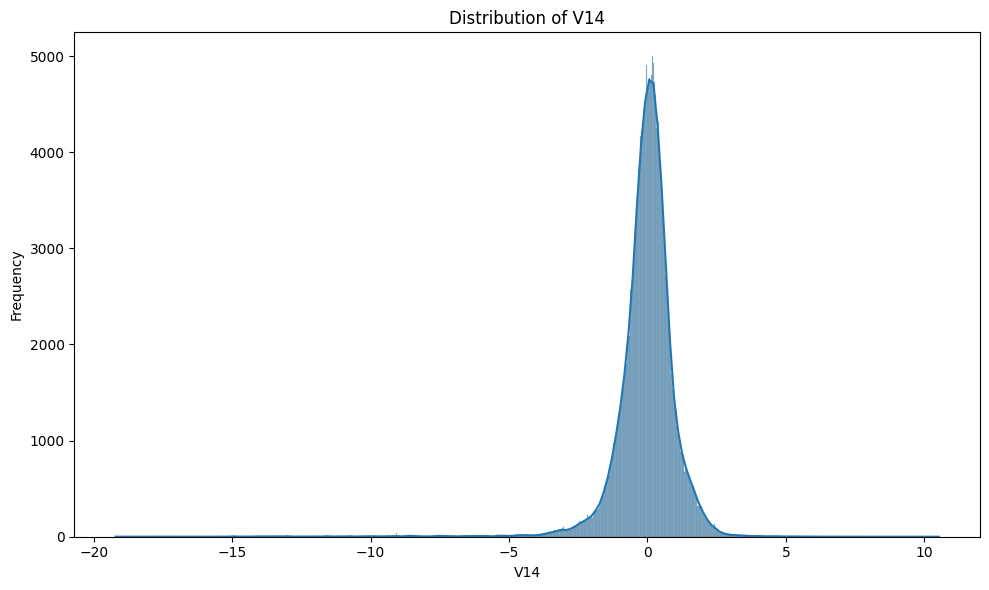

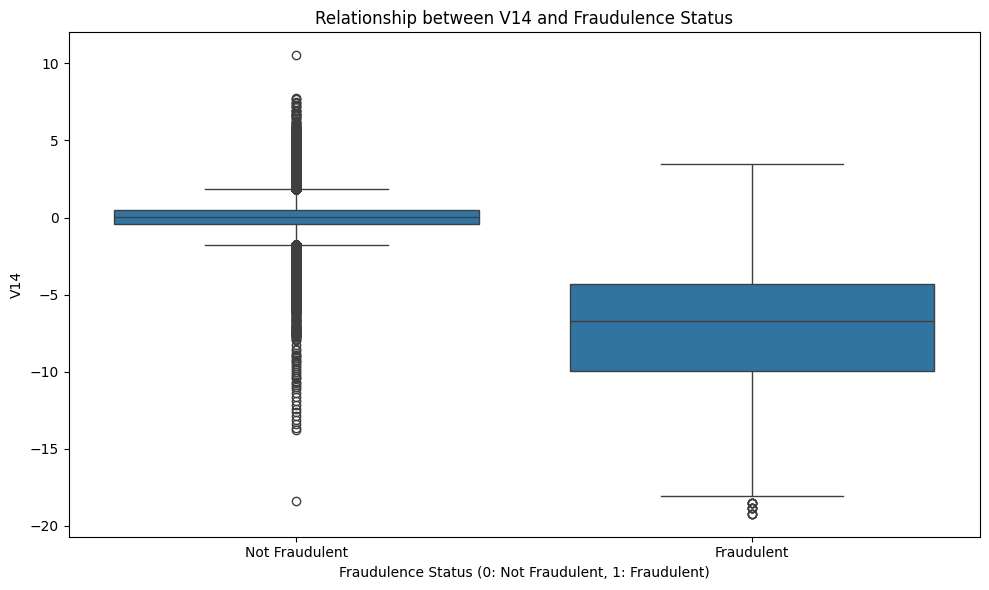


Analysis for column: V15

Descriptive statistics:


count    286068.000000
mean         -0.000442
std           0.916010
min          -4.498945
25%          -0.582895
50%           0.047534
75%           0.648550
max           8.877742
Name: V15, dtype: float64

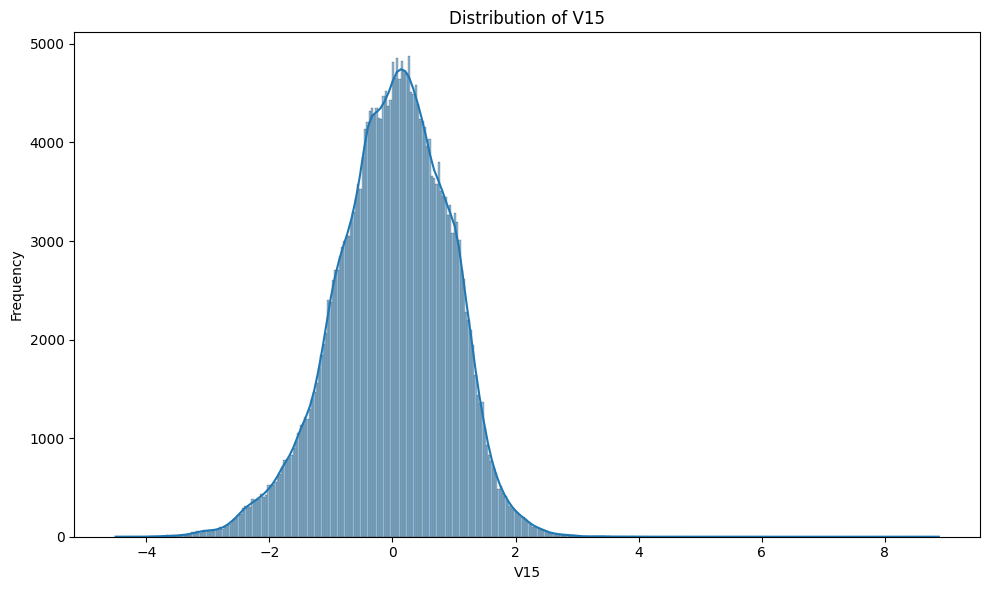

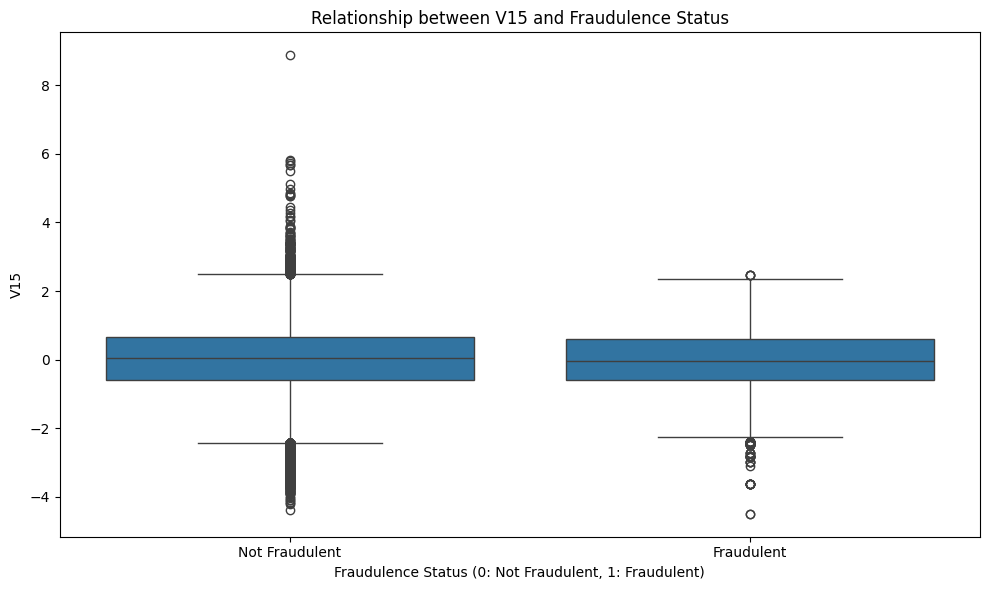


Analysis for column: V16

Descriptive statistics:


count    286068.000000
mean         -0.021957
std           0.967785
min         -14.129855
25%          -0.475832
50%           0.063201
75%           0.521633
max          17.315112
Name: V16, dtype: float64

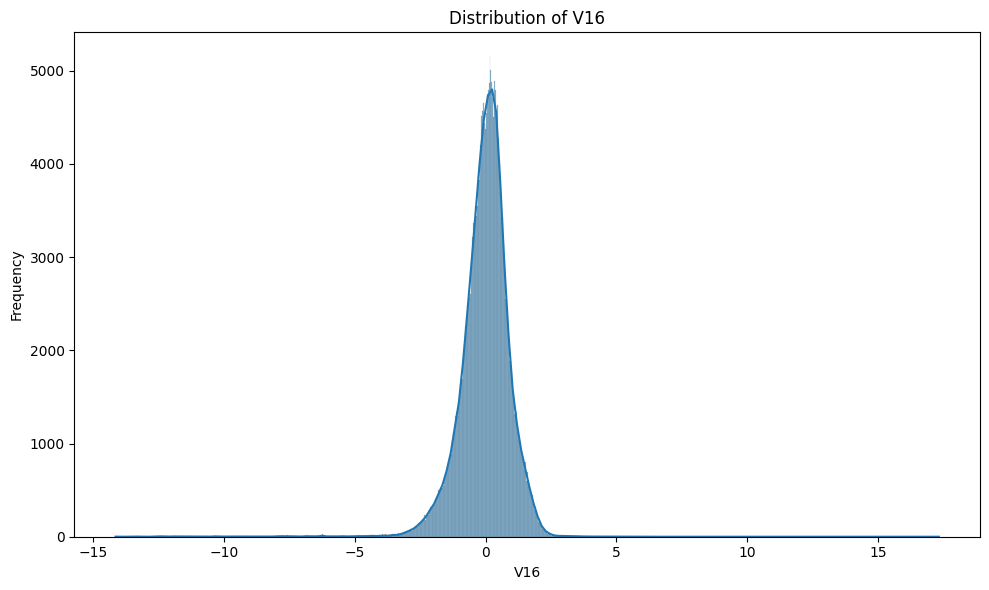

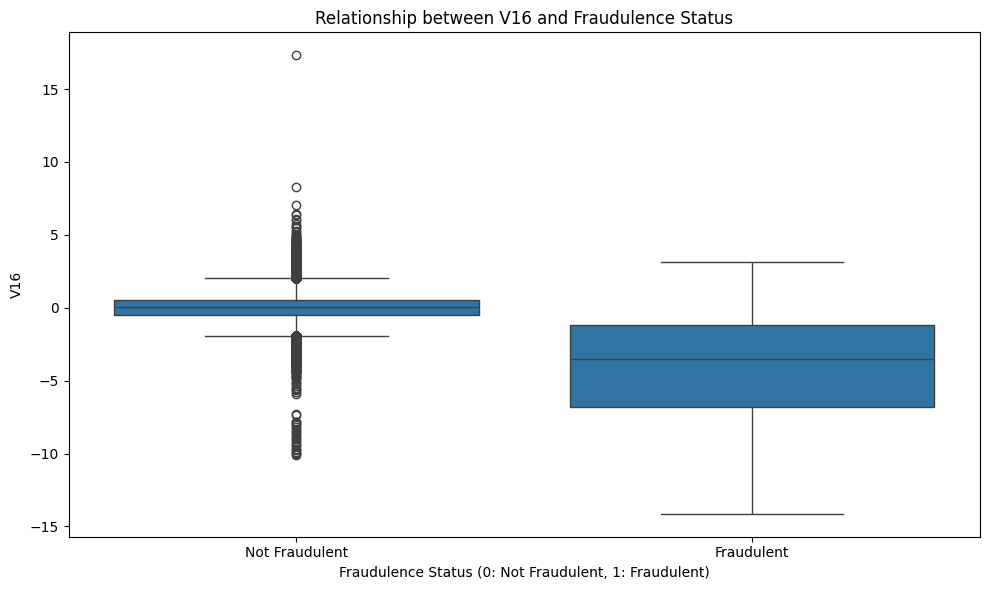


Analysis for column: V17

Descriptive statistics:


count    286068.000000
mean         -0.035171
std           1.100742
min         -25.162799
25%          -0.488648
50%          -0.068342
75%           0.398721
max           9.253526
Name: V17, dtype: float64

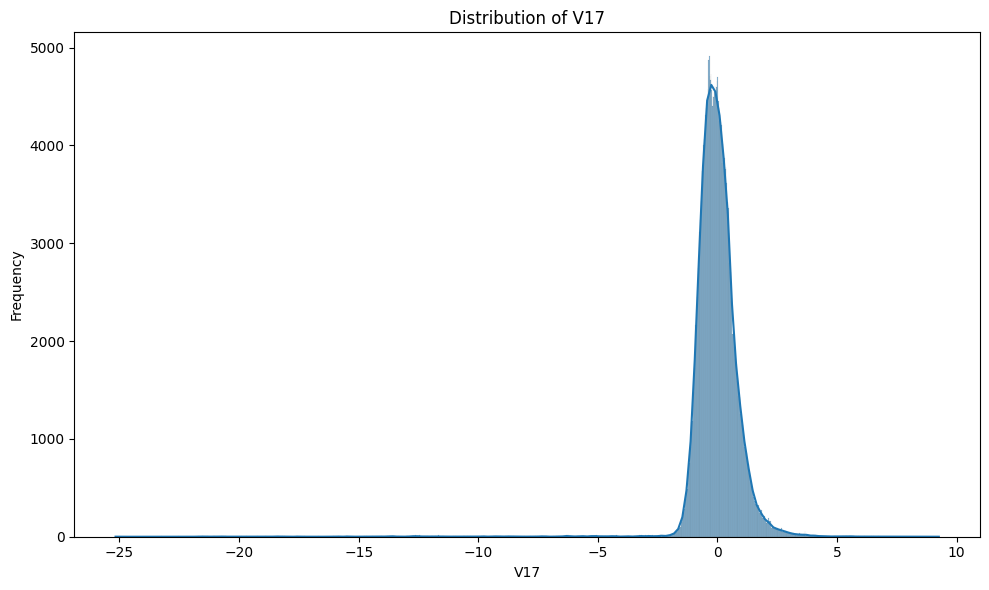

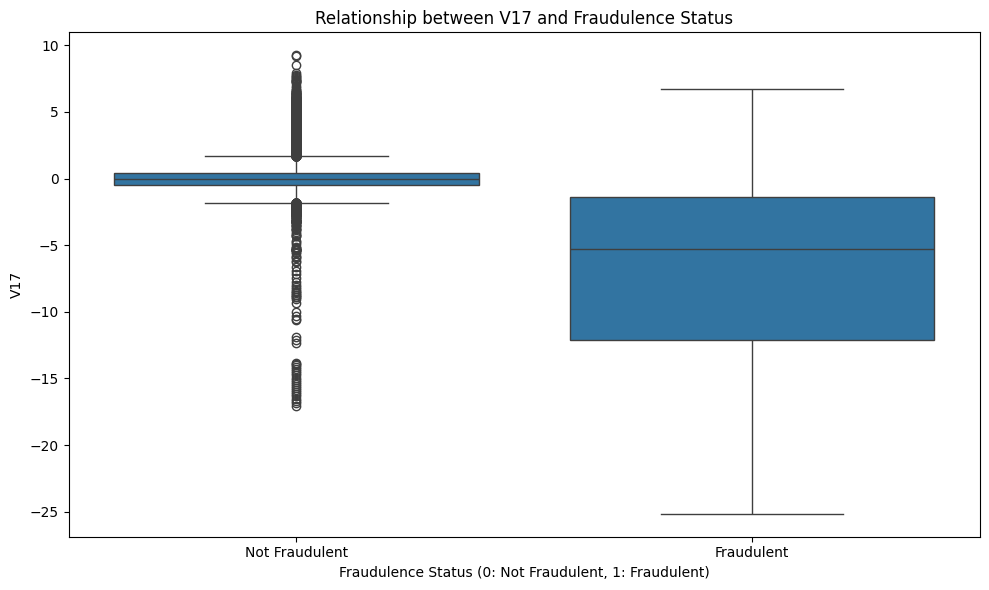


Analysis for column: V18

Descriptive statistics:


count    286068.000000
mean         -0.011837
std           0.877429
min          -9.498746
25%          -0.502948
50%          -0.006228
75%           0.499730
max           5.041069
Name: V18, dtype: float64

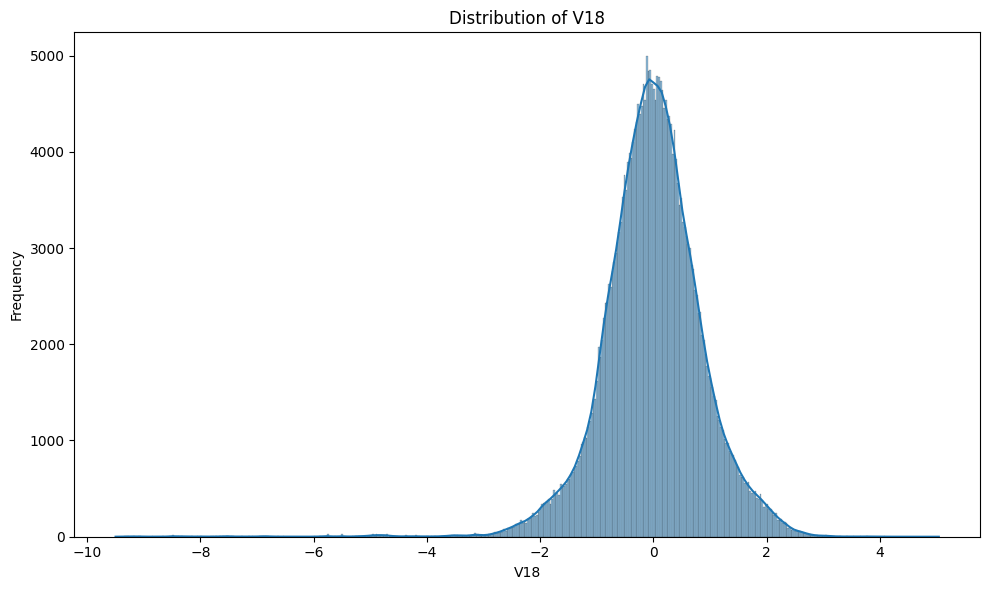

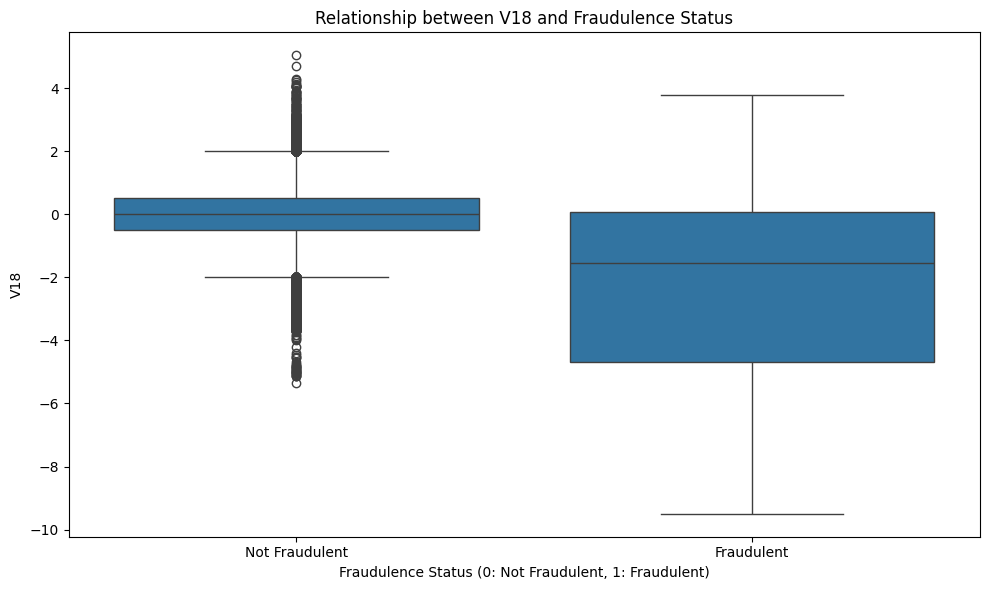


Analysis for column: V19

Descriptive statistics:


count    286068.000000
mean          0.003831
std           0.821034
min          -7.213527
25%          -0.455821
50%           0.005661
75%           0.462851
max           5.591971
Name: V19, dtype: float64

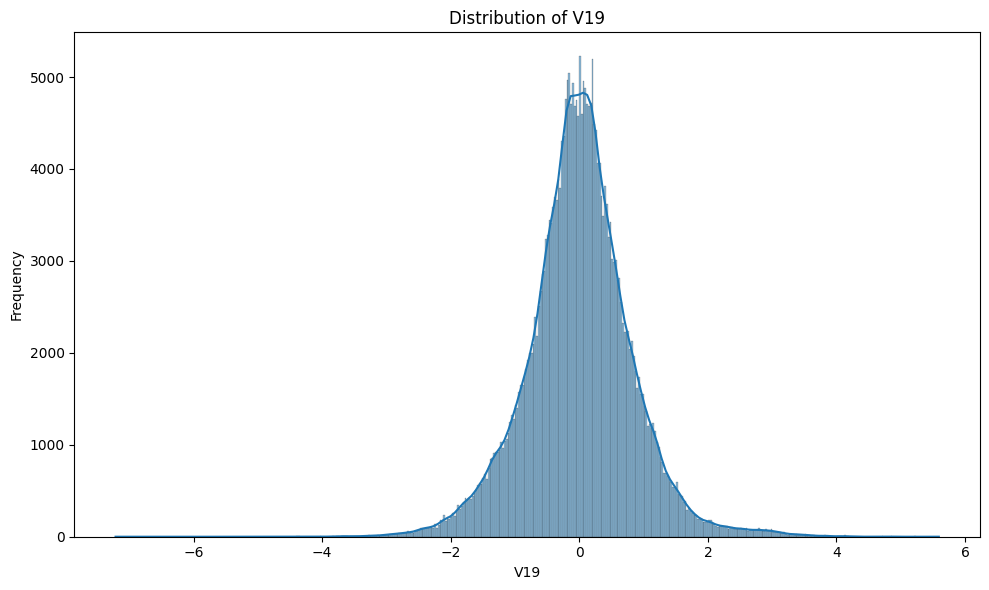

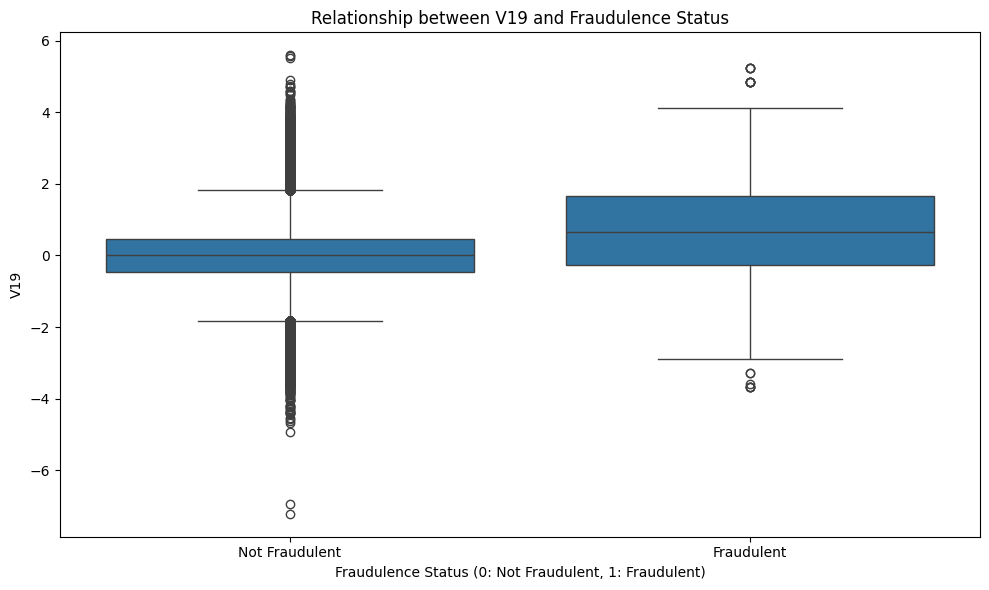


Analysis for column: V20

Descriptive statistics:


count    286068.000000
mean          0.001339
std           0.774567
min         -54.497720
25%          -0.211688
50%          -0.062041
75%           0.134734
max          39.420904
Name: V20, dtype: float64

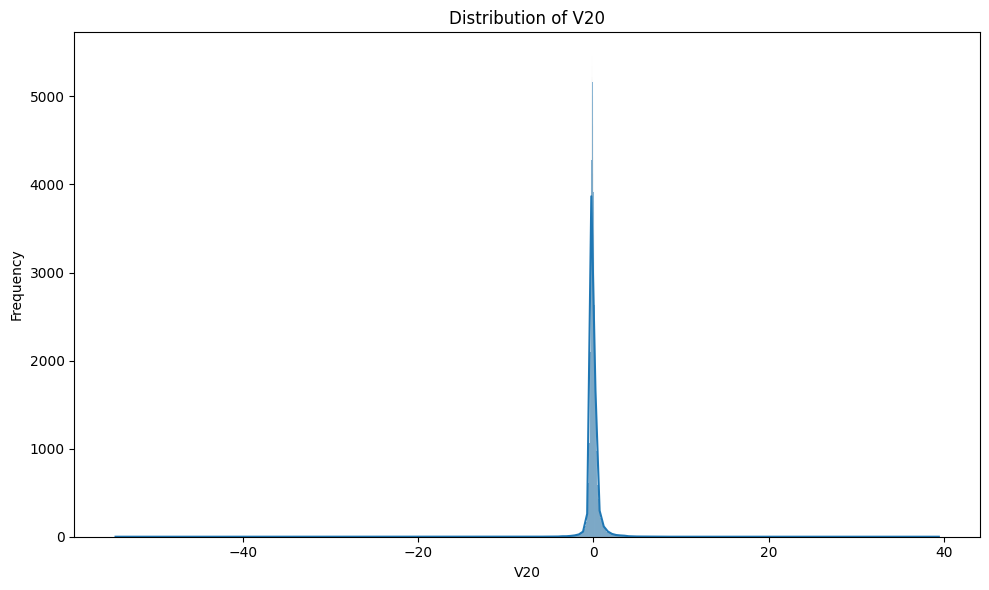

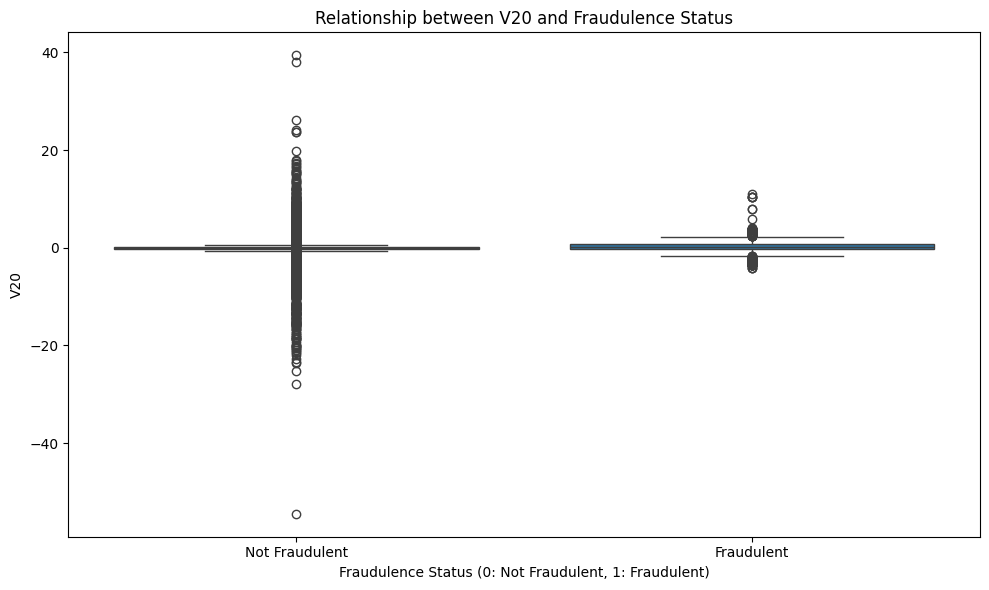


Analysis for column: V21

Descriptive statistics:


count    286068.000000
mean          0.005266
std           0.793289
min         -34.830382
25%          -0.228167
50%          -0.028538
75%           0.188568
max          27.202839
Name: V21, dtype: float64

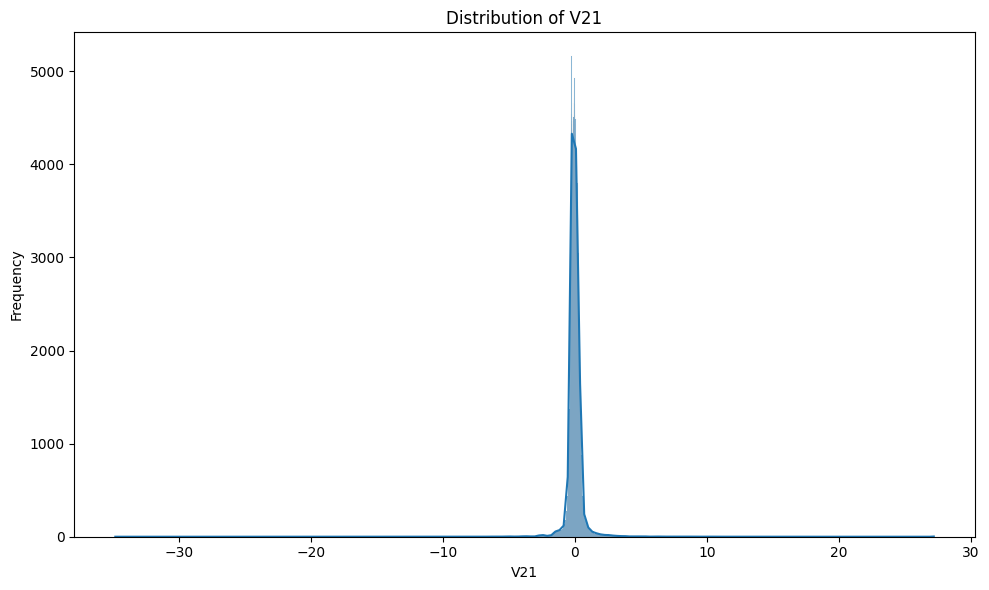

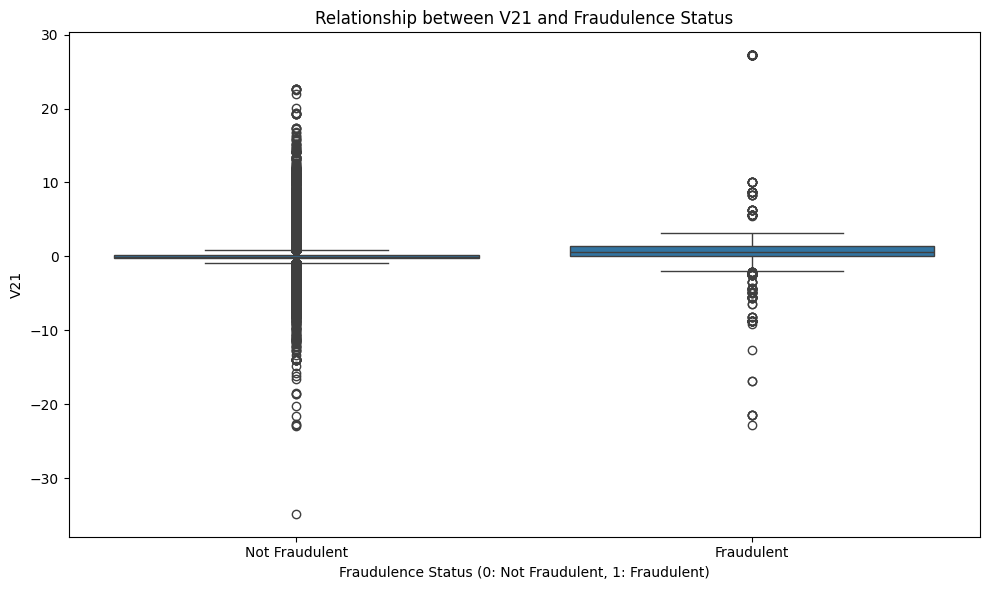


Analysis for column: V22

Descriptive statistics:


count    286068.000000
mean         -0.000308
std           0.732201
min         -10.933144
25%          -0.542407
50%           0.006971
75%           0.529063
max          10.503090
Name: V22, dtype: float64

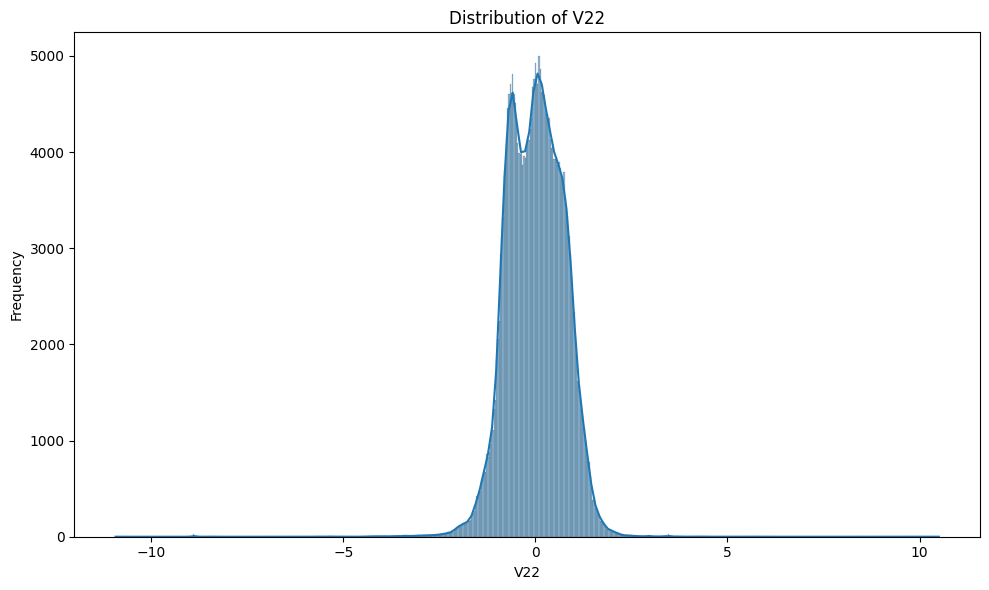

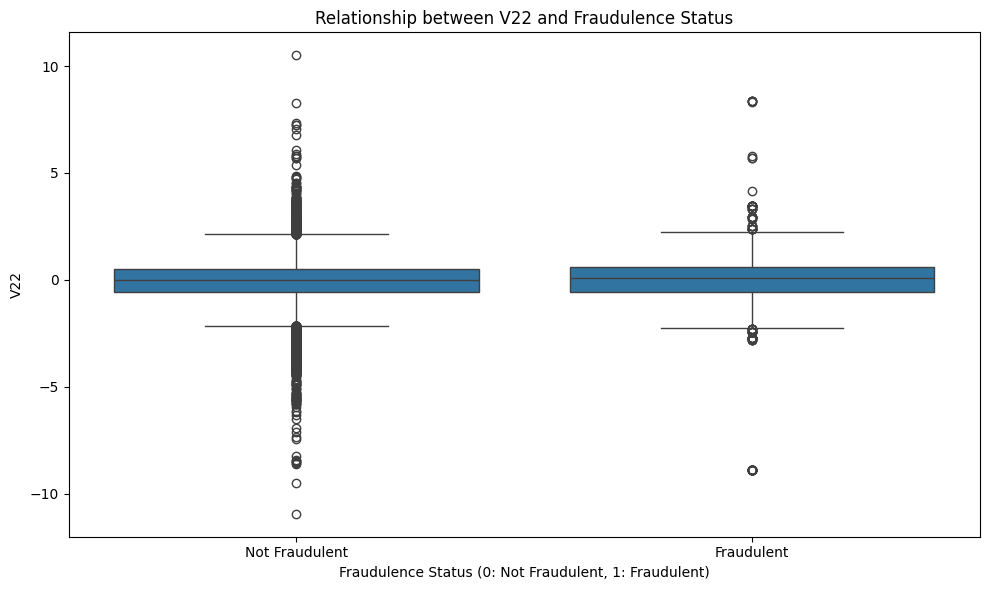


Analysis for column: V23

Descriptive statistics:


count    286068.000000
mean          0.000169
std           0.631294
min         -44.807735
25%          -0.162296
50%          -0.011291
75%           0.148189
max          22.528412
Name: V23, dtype: float64

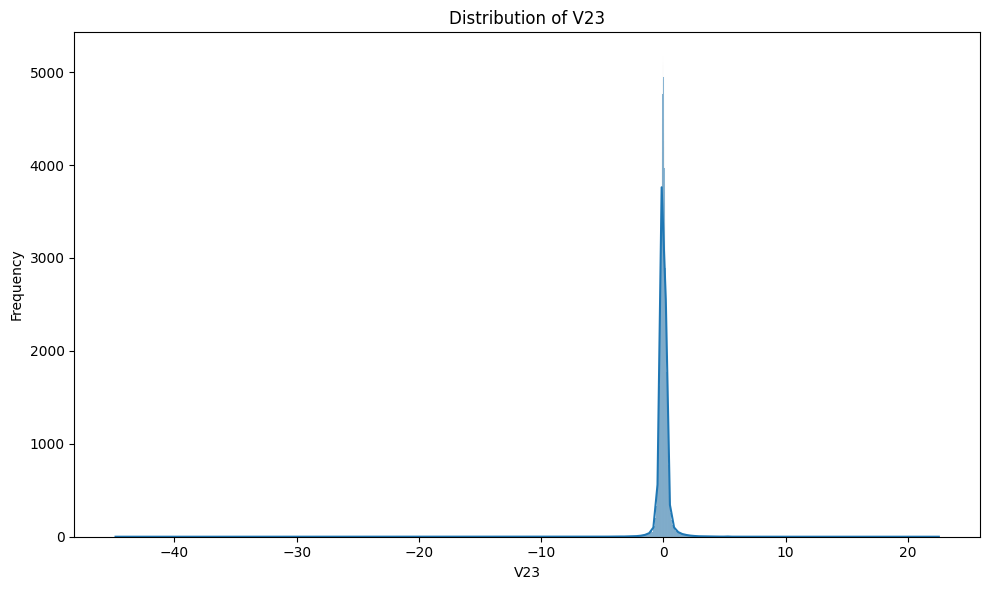

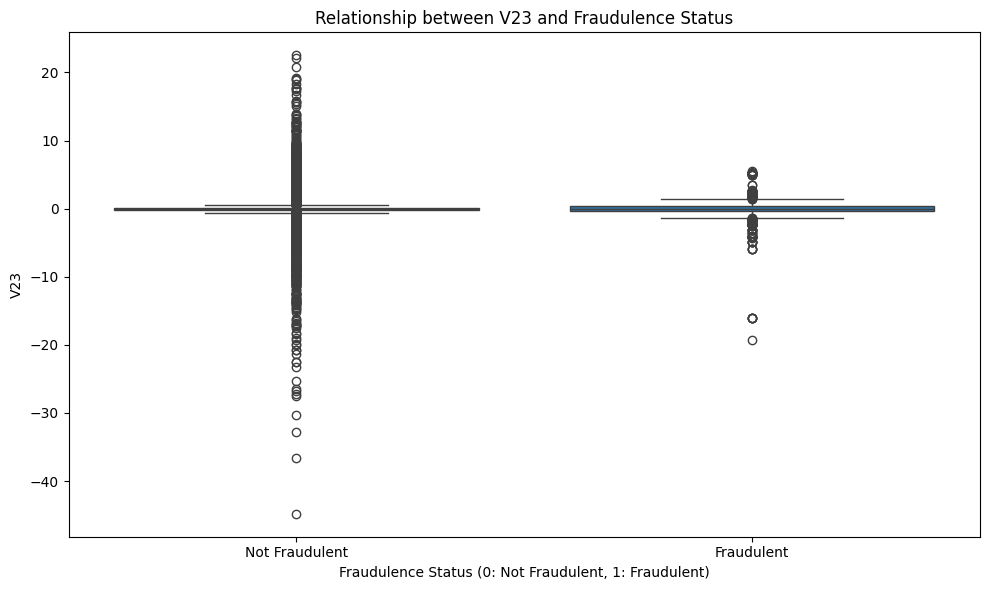


Analysis for column: V24

Descriptive statistics:


count    286068.000000
mean         -0.000632
std           0.605360
min          -2.836627
25%          -0.355356
50%           0.040646
75%           0.438740
max           4.584549
Name: V24, dtype: float64

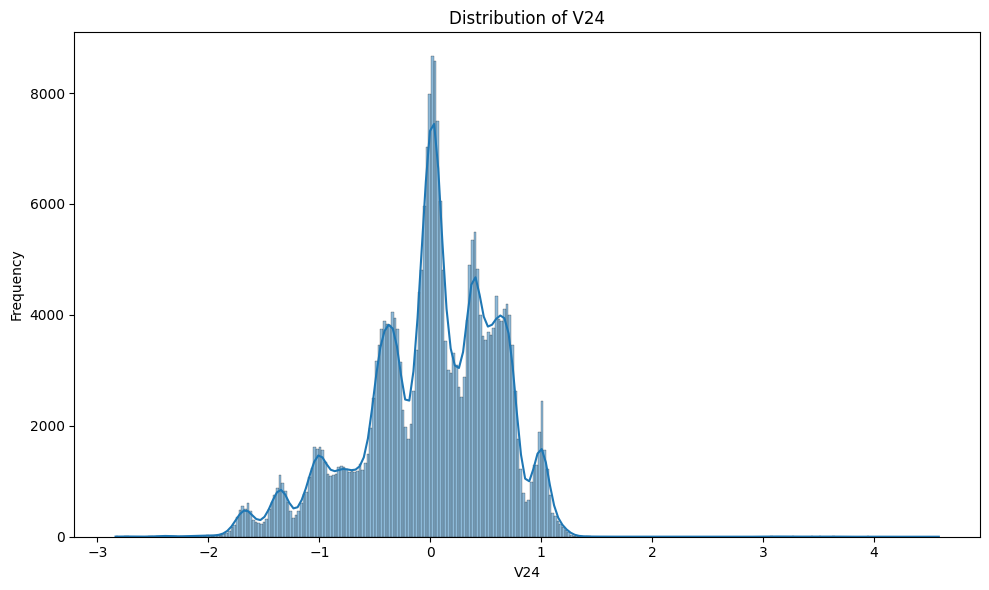

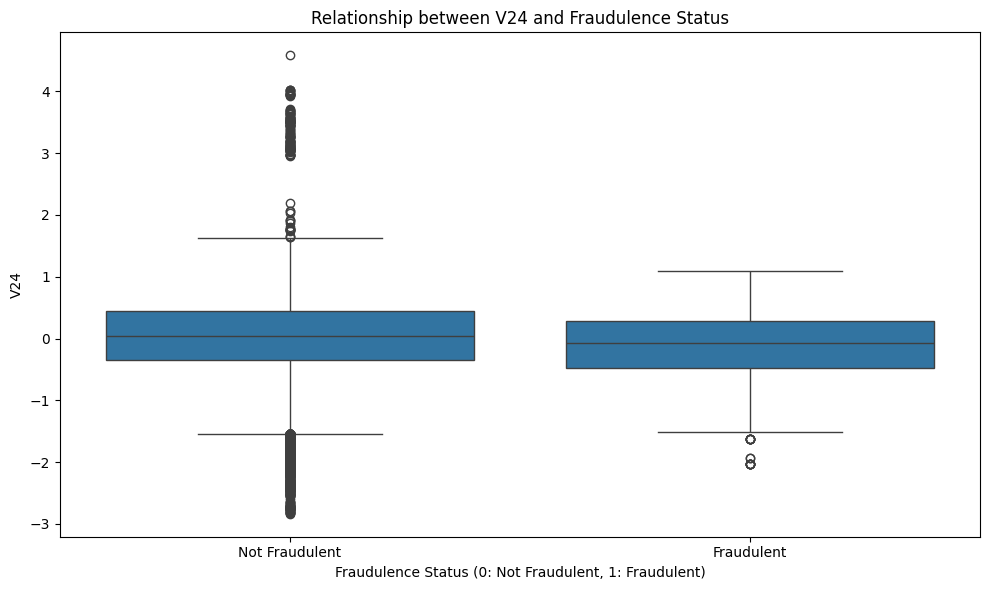


Analysis for column: V25

Descriptive statistics:


count    286068.000000
mean          0.000074
std           0.522754
min         -10.295397
25%          -0.317212
50%           0.016919
75%           0.351182
max           7.519589
Name: V25, dtype: float64

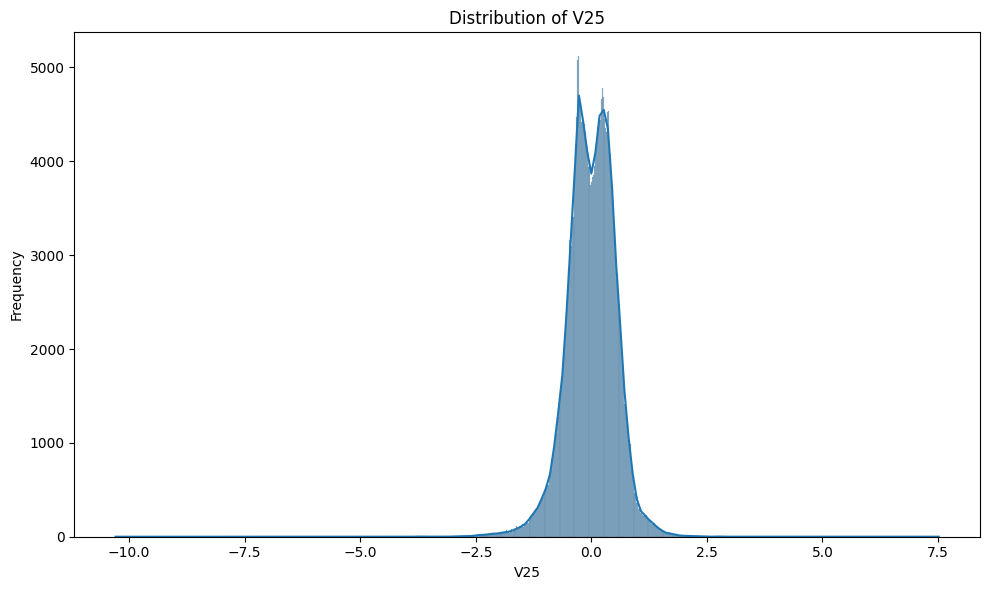

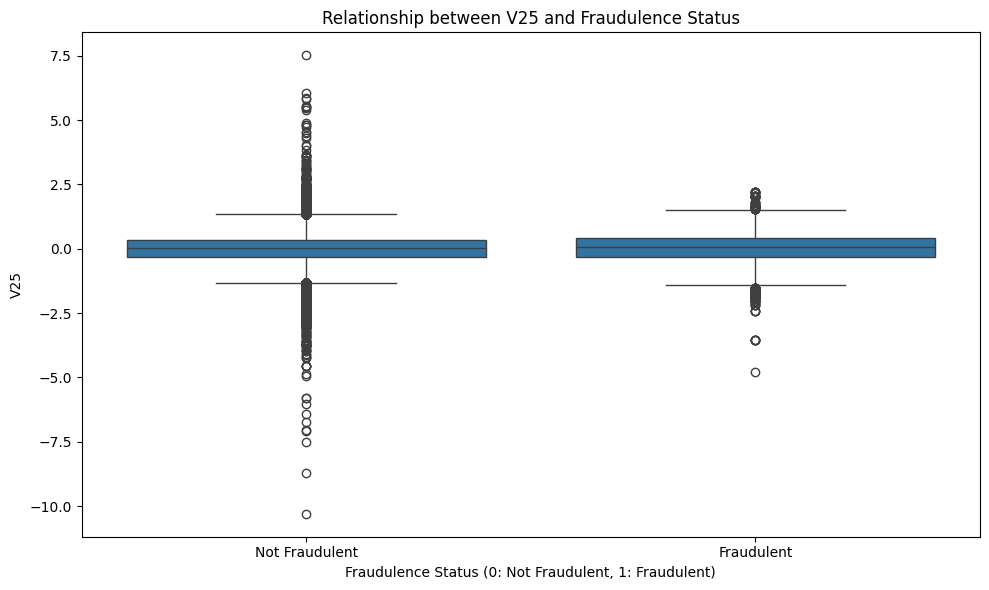


Analysis for column: V26

Descriptive statistics:


count    286068.000000
mean          0.000250
std           0.482295
min          -2.604551
25%          -0.326834
50%          -0.051773
75%           0.241867
max           3.517346
Name: V26, dtype: float64

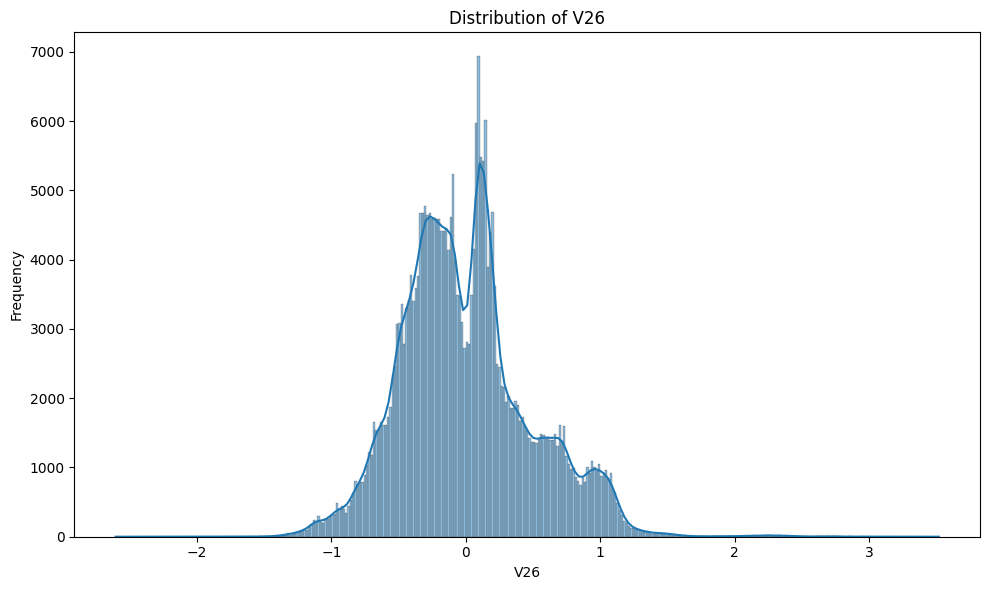

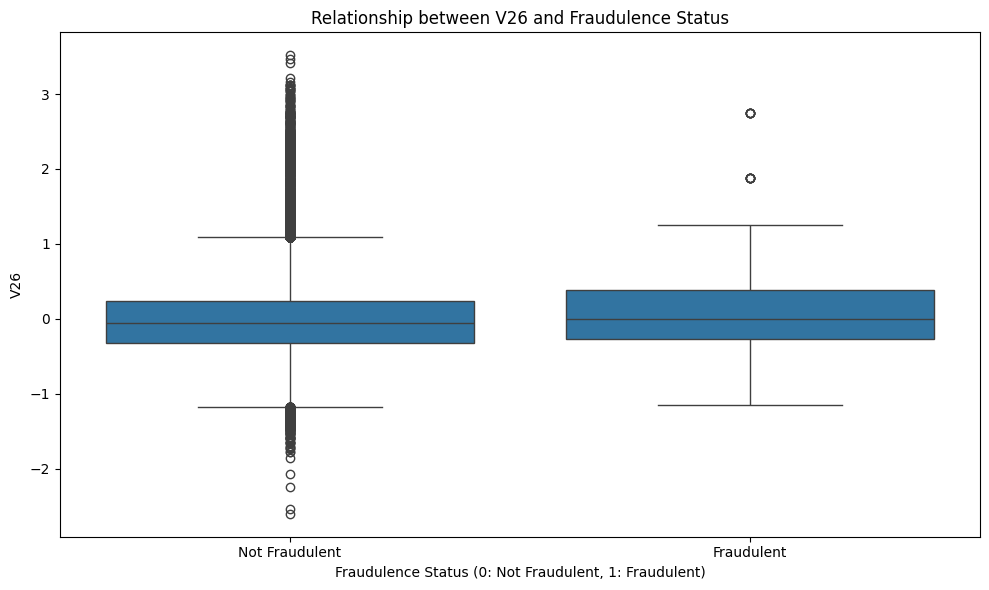


Analysis for column: V27

Descriptive statistics:


count    286068.000000
mean          0.000772
std           0.415446
min         -22.565679
25%          -0.070834
50%           0.001638
75%           0.092413
max          31.612198
Name: V27, dtype: float64

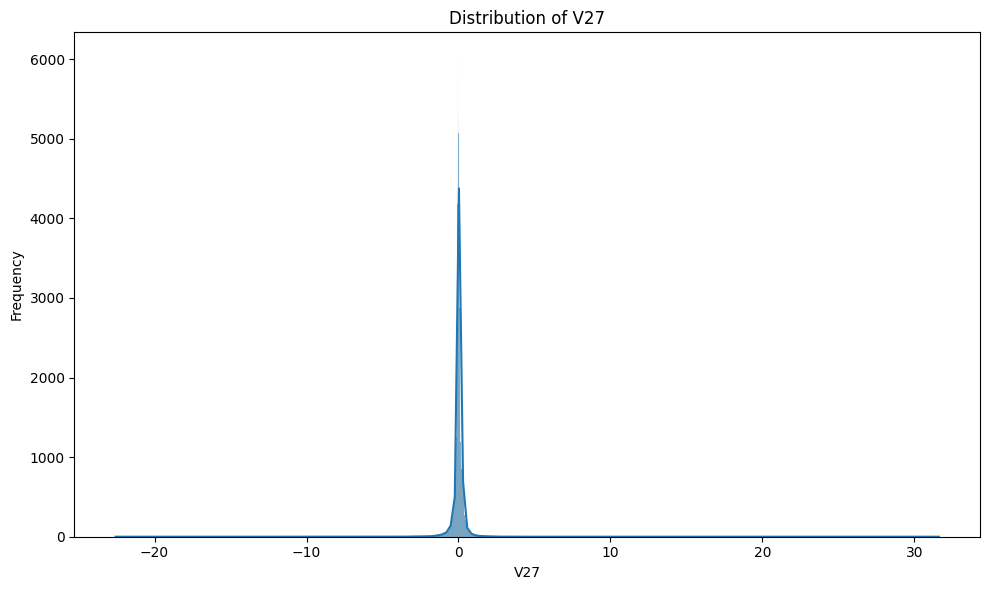

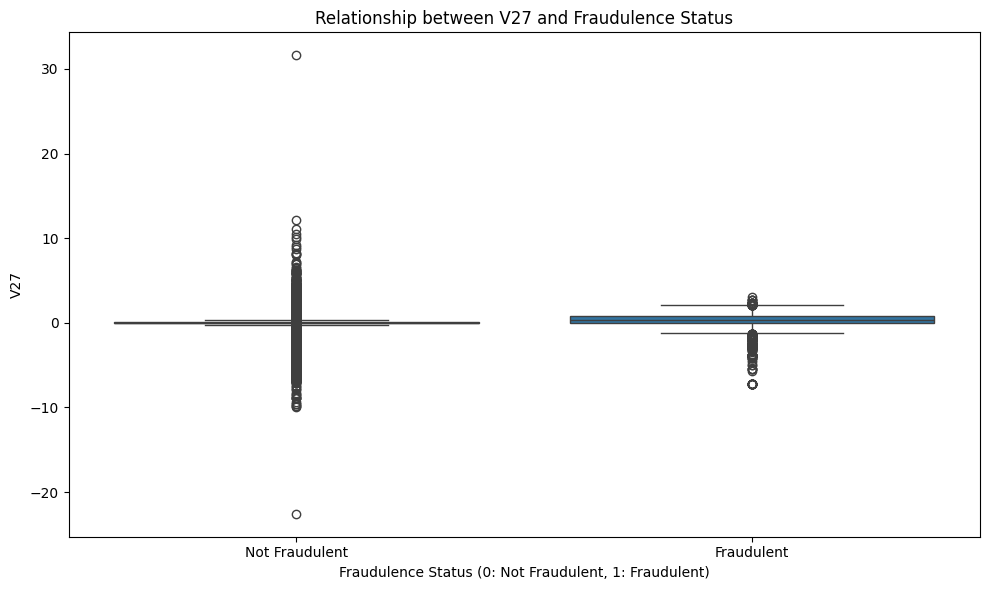


Analysis for column: V28

Descriptive statistics:


count    286068.000000
mean          0.000248
std           0.332091
min         -15.430084
25%          -0.053030
50%           0.011364
75%           0.079120
max          33.847808
Name: V28, dtype: float64

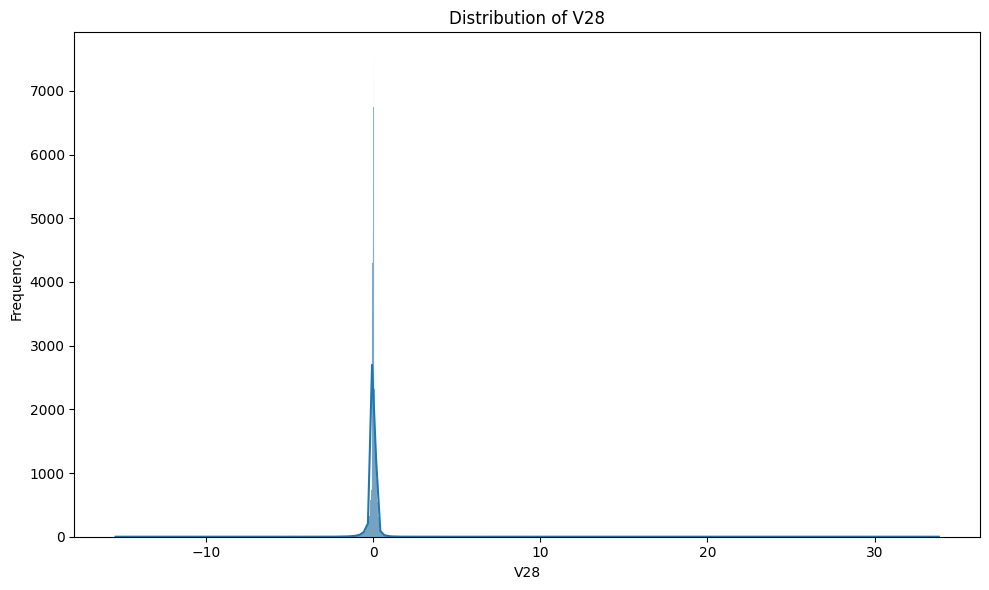

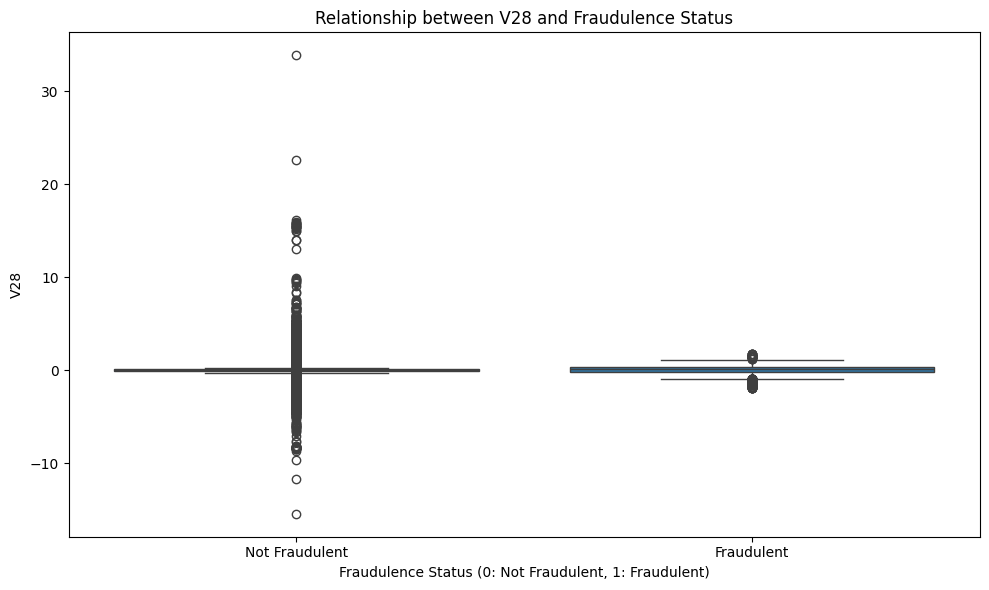


Analysis for column: Amount

Descriptive statistics:


count    286068.000000
mean         92.608524
std         367.107551
min           0.000000
25%           5.490000
50%          22.000000
75%          77.650000
max       25691.160000
Name: Amount, dtype: float64

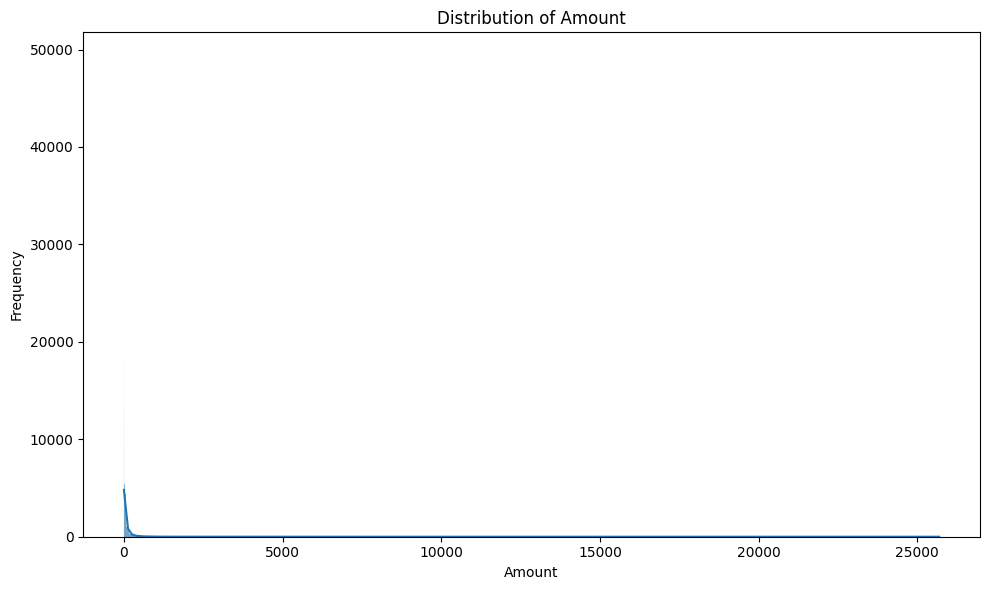

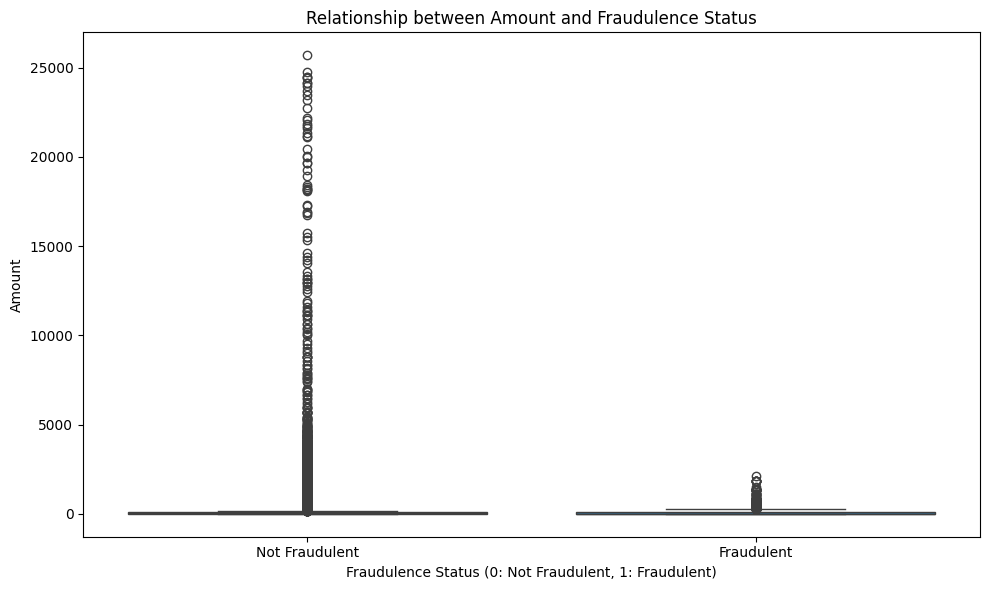


Analysis for column: Class

Descriptive statistics:


count    286068.000000
mean          0.006991
std           0.083322
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Class, dtype: float64

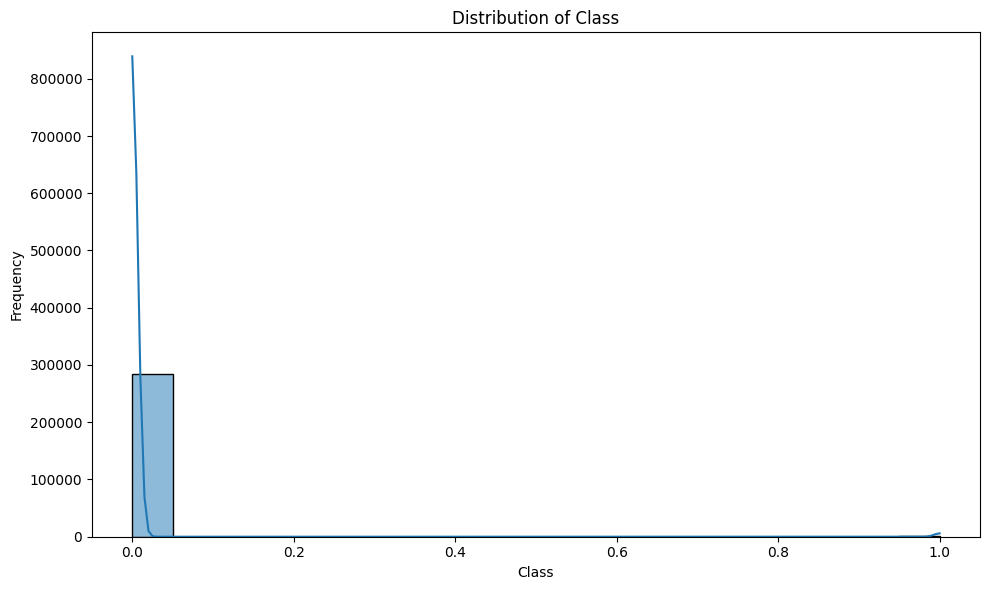

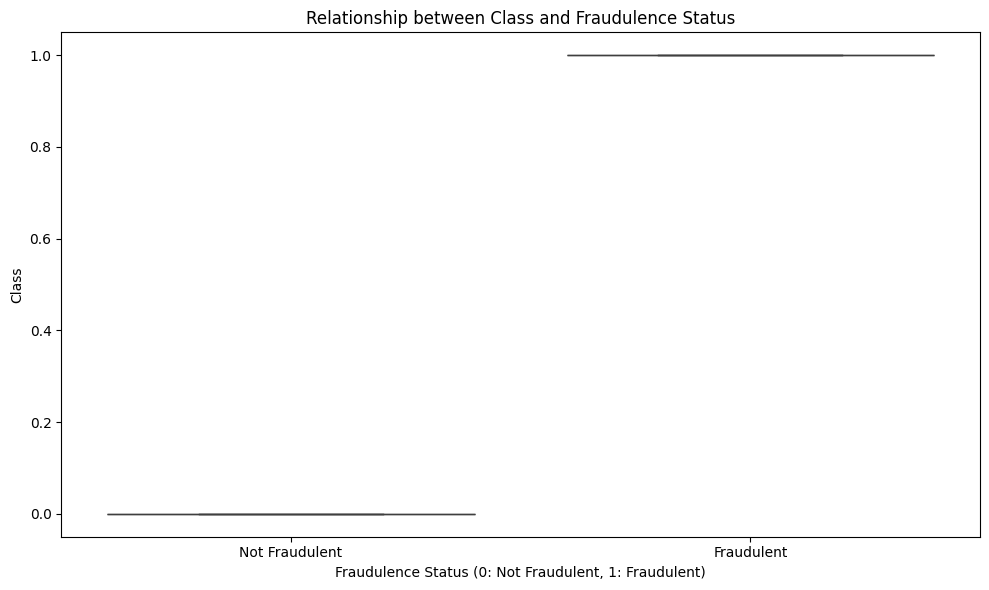


Analysis for column: age

Descriptive statistics:


count    286068.000000
mean         49.844261
std          18.113252
min          18.000000
25%          35.000000
50%          50.000000
75%          66.000000
max          79.000000
Name: age, dtype: float64

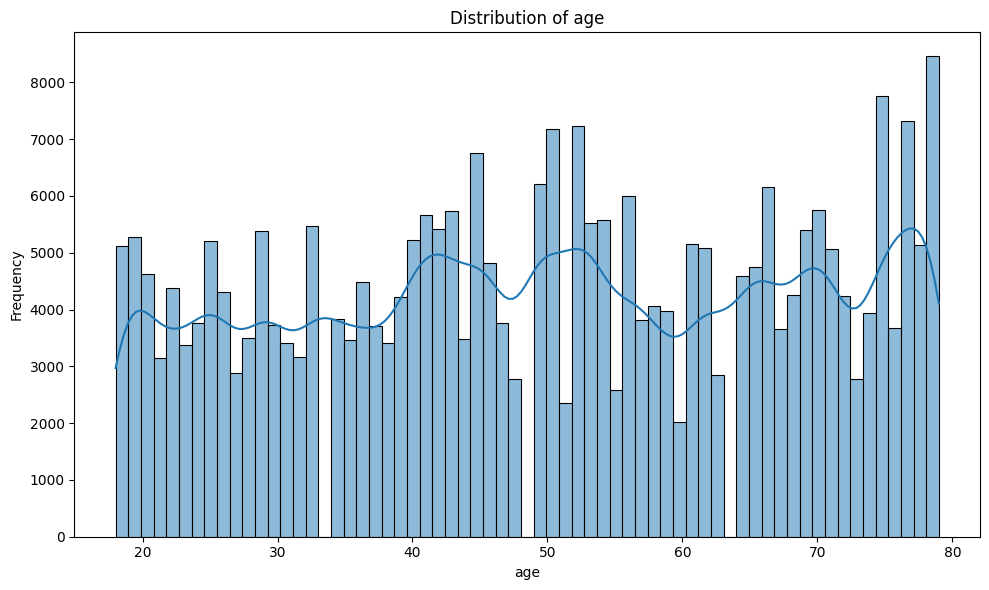

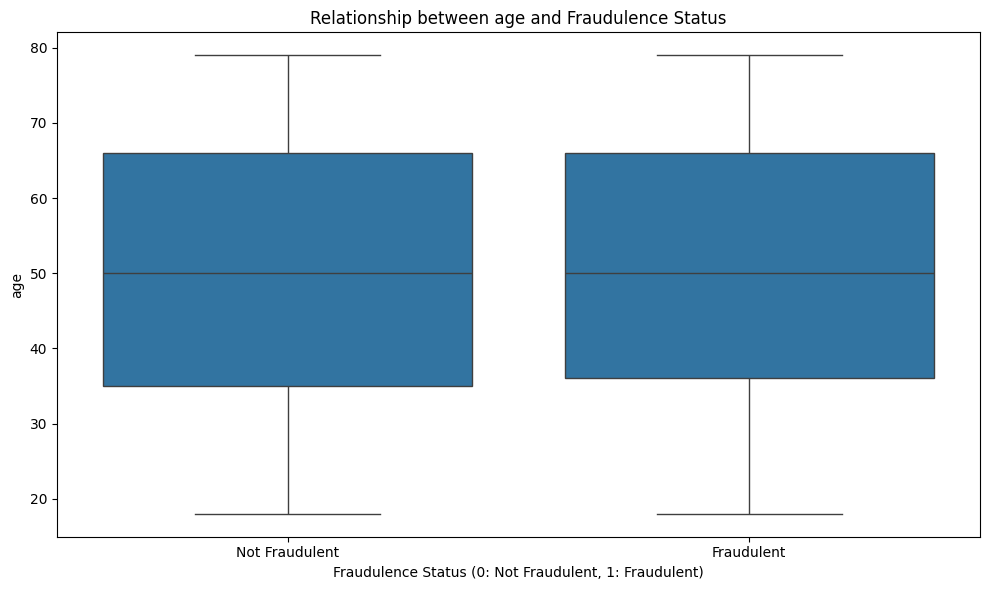


Analysis for column: credit_score

Descriptive statistics:


count    286068.000000
mean        652.938343
std         103.595359
min         300.000000
25%         587.000000
50%         657.000000
75%         726.000000
max         850.000000
Name: credit_score, dtype: float64

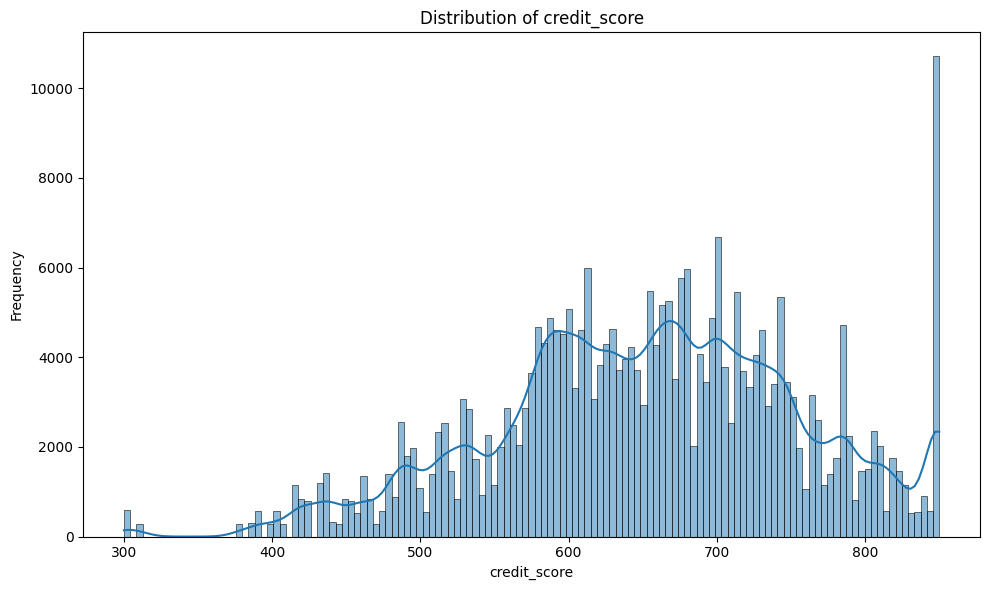

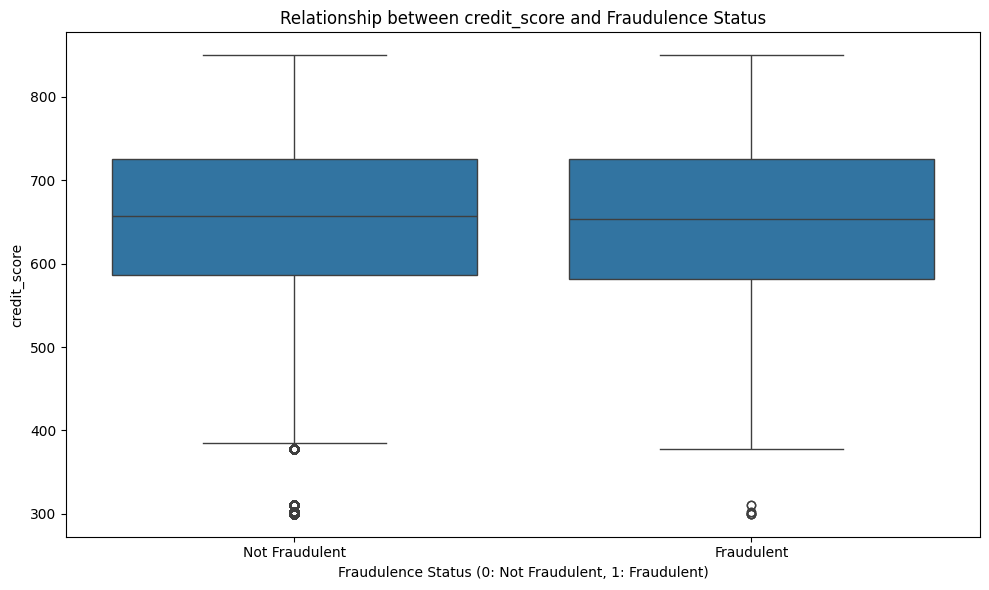

In [ ]:
for col in numeric_df:
    print(f"\nAnalysis for column: {col}")

    # Calculate descriptive statistics
    print("\nDescriptive statistics:")
    display(df[col].describe())

    # Visualize distribution of the numeric variable
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Analyze relationship with survival_status
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Class', y=col)
    plt.title(f'Relationship between {col} and Fraudulence Status')
    plt.xlabel('Fraudulence Status (0: Not Fraudulent, 1: Fraudulent)')
    plt.ylabel(col)
    plt.xticks([0, 1], ['Not Fraudulent', 'Fraudulent'])
    plt.tight_layout()
    plt.show()

## Categorical and Binary Variables


Analysis for column: merchant_country

Frequency of each category:


merchant_country
Australia    35977
Germany      35955
Spain        35870
Japan        35837
USA          35727
UK           35611
Italy        35552
France       35539
Name: count, dtype: int64


Frequency by merchant_country and fraudulence_status:


Class                 0    1
merchant_country            
Australia         35725  252
France            35269  270
Germany           35725  230
Italy             35310  242
Japan             35597  240
Spain             35601  269
UK                35360  251
USA               35481  246

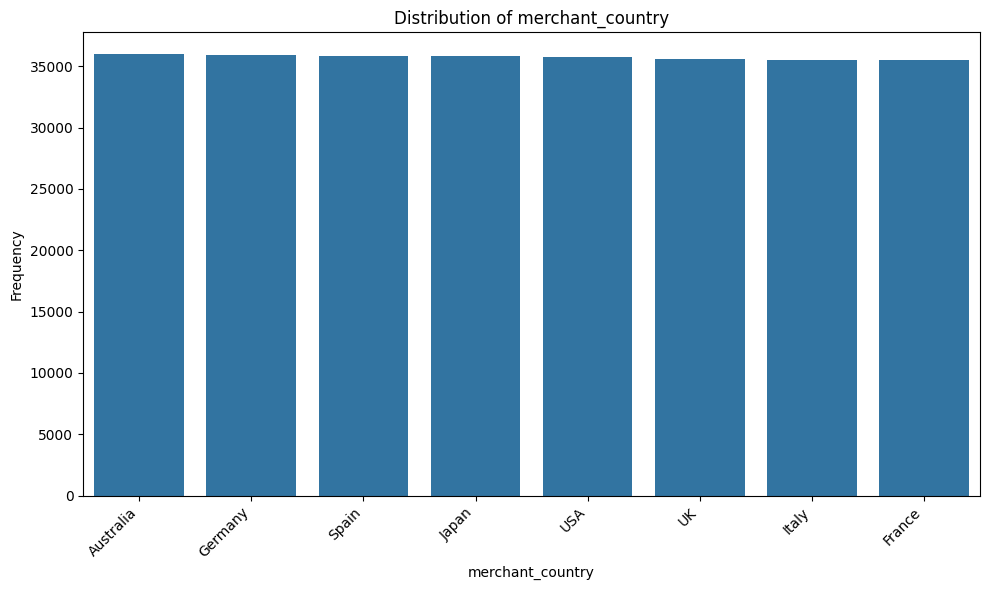

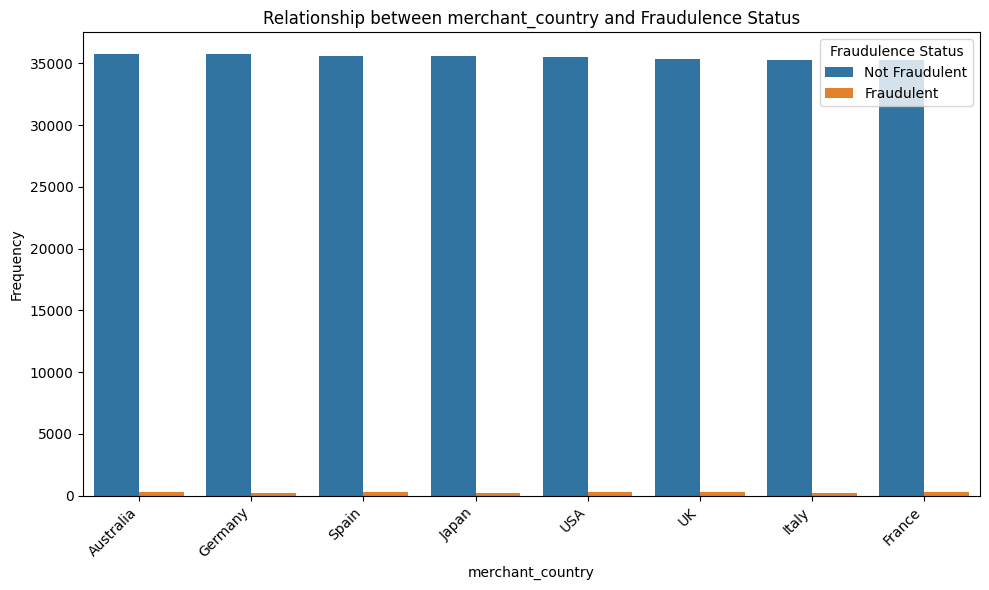


Analysis for column: customer_country

Frequency of each category:


customer_country
Australia         2596
Togo              2585
Congo             2550
Korea             2504
New Zealand       2348
                  ... 
Bahamas            275
American Samoa     275
Chad               274
Mexico             272
Saudi Arabia       272
Name: count, Length: 236, dtype: int64


Frequency by customer_country and fraudulence_status:


Class                 0   1
customer_country           
Afghanistan         896   6
Algeria            2269  14
American Samoa      274   1
Andorra            1771  11
Angola             1146   5
...                 ...  ..
Wallis and Futuna   854   8
Western Sahara     1430  11
Yemen              1671   8
Zambia              863   5
Zimbabwe            850   6

[236 rows x 2 columns]

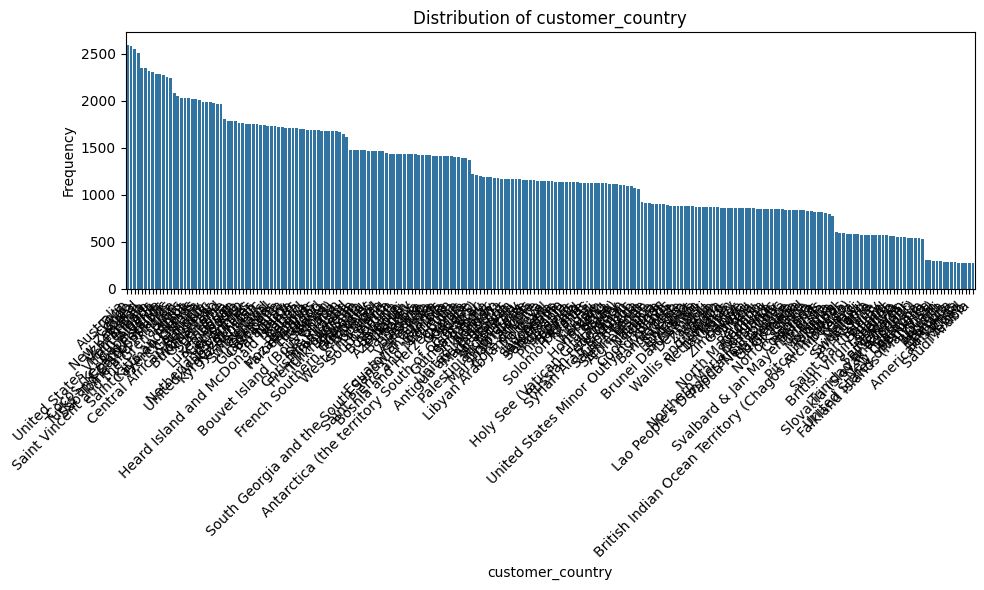

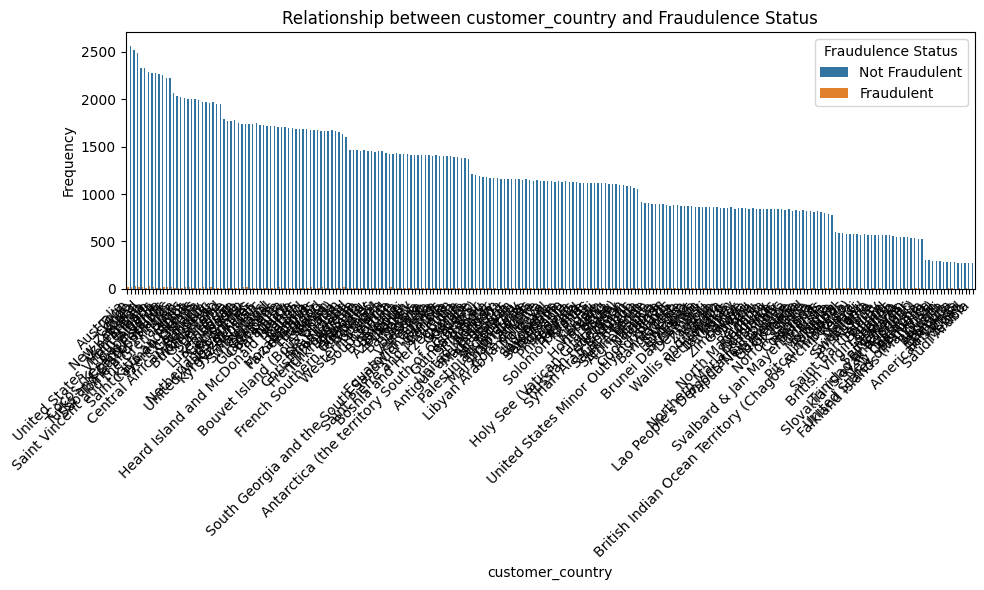


Analysis for column: city

Frequency of each category:


city
Hamburg        12145
Perth          12130
Madrid         12026
Tokyo          12012
Sydney         11989
Marseille      11972
Valencia       11941
London         11938
Osaka          11917
Berlin         11915
Kyoto          11908
Barcelona      11903
Munich         11895
Venice         11885
Milan          11864
Melbourne      11858
Manchester     11854
Lyon           11846
Edinburgh      11819
Rome           11803
Paris          11721
New York        9033
Los Angeles     9016
Chicago         8945
Miami           8733
Name: count, dtype: int64


Frequency by city and fraudulence_status:


Class            0   1
city                  
Barcelona    11808  95
Berlin       11847  68
Chicago       8875  70
Edinburgh    11741  78
Hamburg      12066  79
Kyoto        11820  88
London       11843  95
Los Angeles   8963  53
Lyon         11757  89
Madrid       11939  87
Manchester   11776  78
Marseille    11885  87
Melbourne    11779  79
Miami         8676  57
Milan        11781  83
Munich       11812  83
New York      8967  66
Osaka        11845  72
Paris        11627  94
Perth        12041  89
Rome         11729  74
Sydney       11905  84
Tokyo        11932  80
Valencia     11854  87
Venice       11800  85

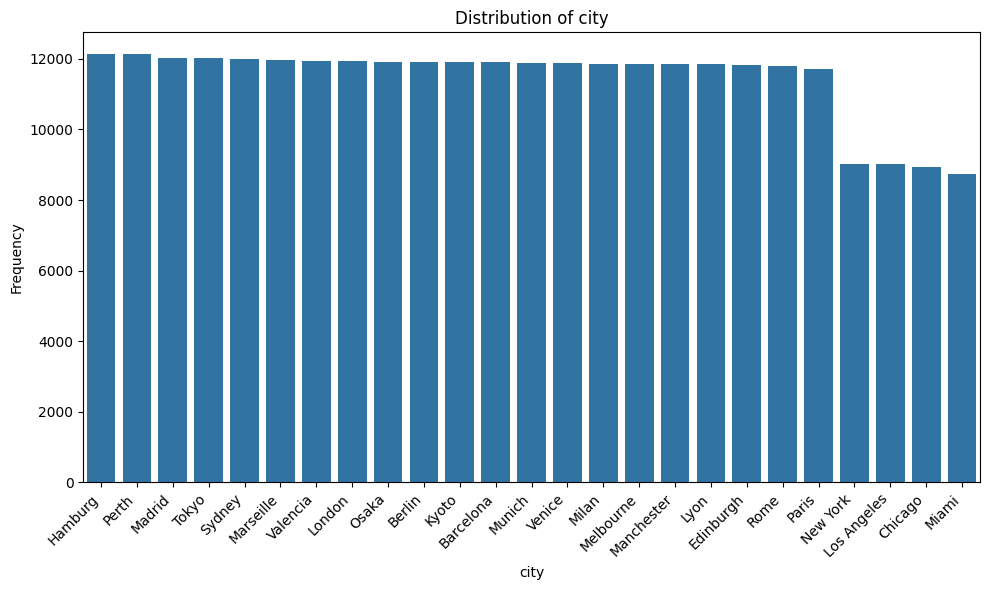

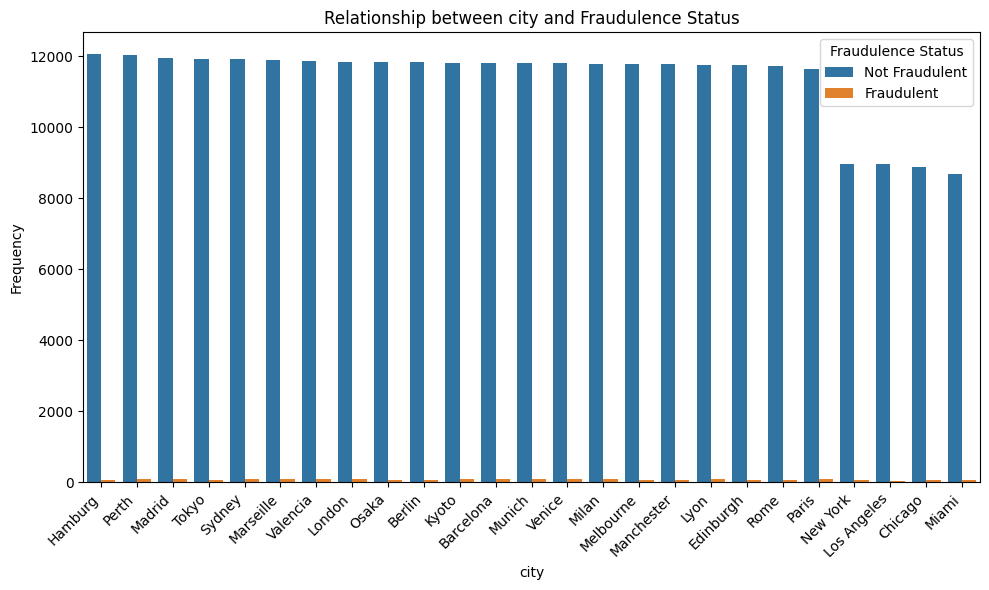

In [ ]:
# From the variable info, some columns are described as binary or categorical
# but are stored as integers. We should also include these based on the description.
all_categorical_cols = ["merchant_country", "customer_country", 'city']

for col in all_categorical_cols:
    print(f"\nAnalysis for column: {col}")

    # Calculate frequency of each category
    print("\nFrequency of each category:")
    display(df[col].value_counts())

    # Calculate frequency of each category in relation to fraudulence_status
    print(f"\nFrequency by {col} and fraudulence_status:")
    display(pd.crosstab(df[col], df['Class']))

    # Visualize distribution of categorical variables
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Visualize relationship between categorical variable and fraudulence_status
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue='Class', order=df[col].value_counts().index)
    plt.title(f'Relationship between {col} and Fraudulence Status')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Fraudulence Status', labels=['Not Fraudulent', 'Fraudulent'])
    plt.tight_layout()
    plt.show()

## Handle Missing Values

Missing Values  Percentage
zip_code           28549    9.979795
email              14214    4.968749
phone               5616    1.963170

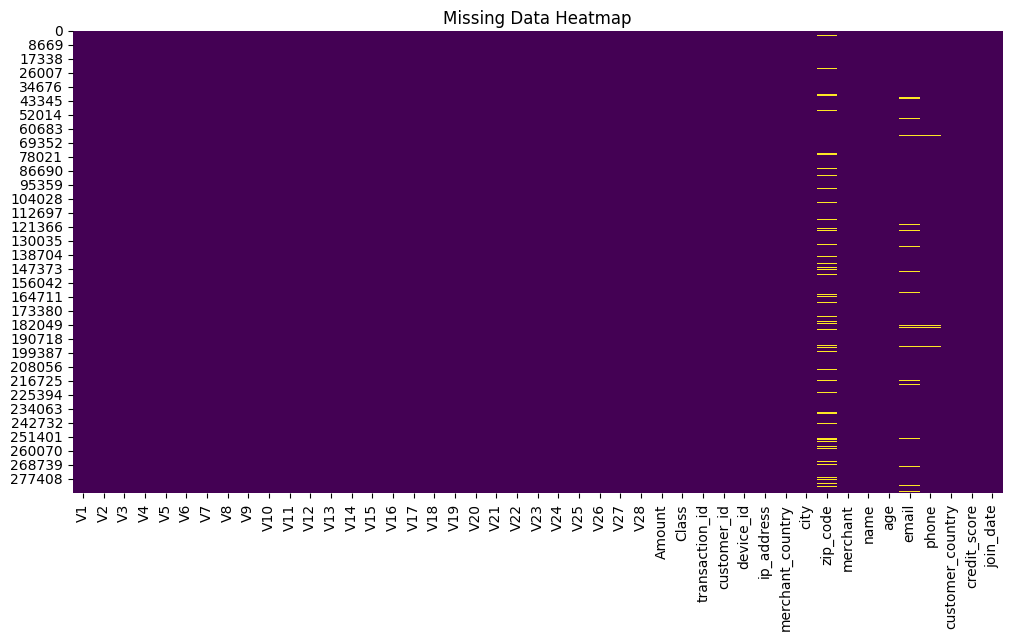

In [ ]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

missing_info = missing_info[missing_info['Missing Values'] > 0].sort_values(by='Percentage', ascending=False)
display(missing_info)

plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [ ]:
df["email"] = df["email"].fillna('Unknown', inplace=True)
df["phone"] = df["phone"].fillna('Unknown', inplace=True)
df["zip_code"] = df["zip_code"].fillna('Unknown', inplace=True)
#customers_df['phone'].fillna('Unknown', inplace=True)

/tmp/ipython-input-120176510.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["email"] = df["email"].fillna('Unknown', inplace=True)
/tmp/ipython-input-120176510.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

## Correlation analysis (Multivariate EDA)

After exploring each variable individually, this section focuses on examining the relationships between numerical features.  
Understanding correlations helps identify redundant variables (those that provide similar information) and detect potential dependencies between features that may influence the model’s performance.  
First, we compute the correlation among all numeric variables to visualize how strongly they are related to each other.


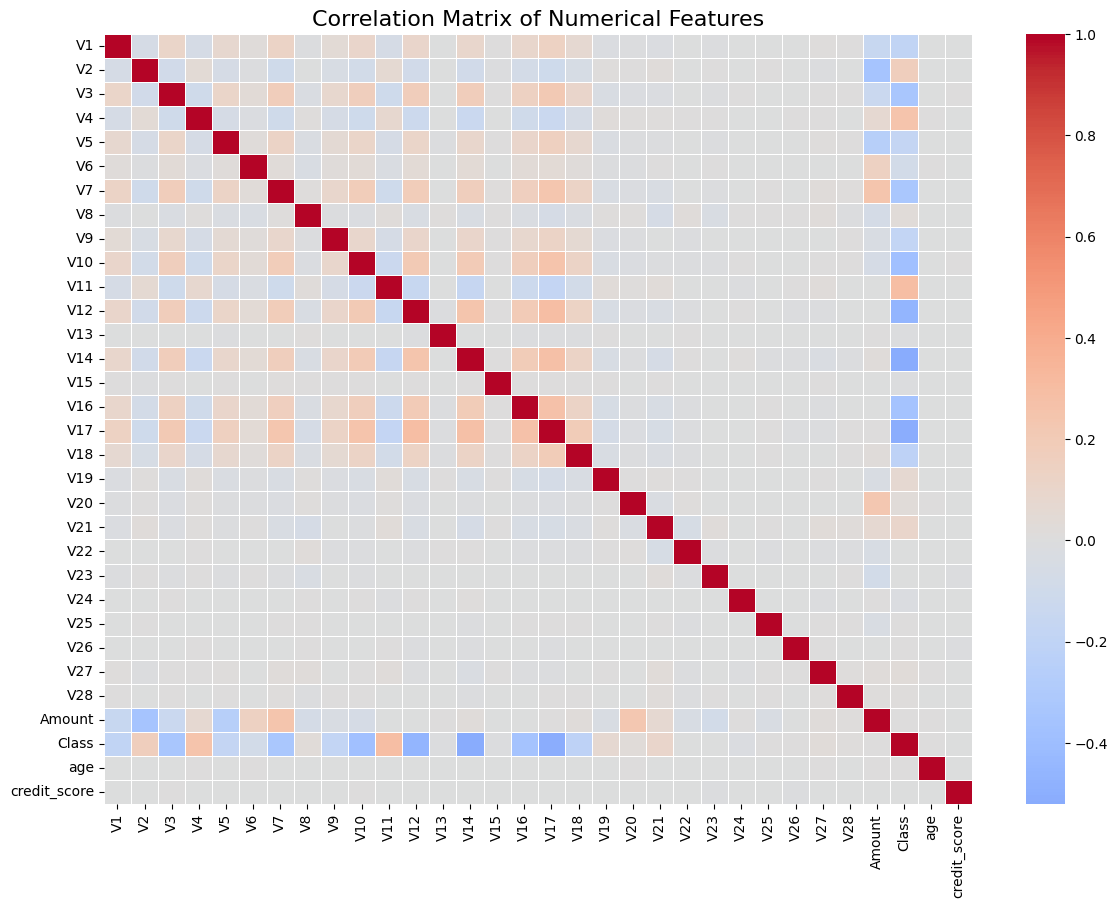

In [ ]:
# Compute correlation matrix for all numeric variables
corr_matrix = df.corr(numeric_only=True)

# Display correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    annot=False
)
plt.title("Correlation Matrix of Numerical Features", fontsize=16)
plt.show()

The correlation heatmap shows that the anonymized features (V1–V28) have very low correlations between each other.
This means that each variable provides unique information.
Similarly, Amount, age, and credit_score are also independent from those features, so they add complementary information to the dataset.
Since no strong correlations are observed, we don’t have multicollinearity problems — this is positive for the model training.

Correlation with the target variable `Class`.

corr_with_Class
V14        -0.520908
V17        -0.505913
V12        -0.456149
V10        -0.384570
V16        -0.359038
V3         -0.341715
V7         -0.325747
V11         0.297107
V4          0.257246
V18        -0.212939
V1         -0.190232
V9         -0.186133
V5         -0.173574
V2          0.172225
V21         0.098384

corr_with_Class
V19                  0.072329
V20                  0.031425
V27                  0.031355
V8                   0.025944
V24                 -0.016820
V28                  0.013559
V15                 -0.007688
V26                  0.007491
Amount               0.006472
V13                 -0.005856
V22                 -0.003491
V25                  0.003312
age                  0.002940
credit_score        -0.002856
V23                  0.001457

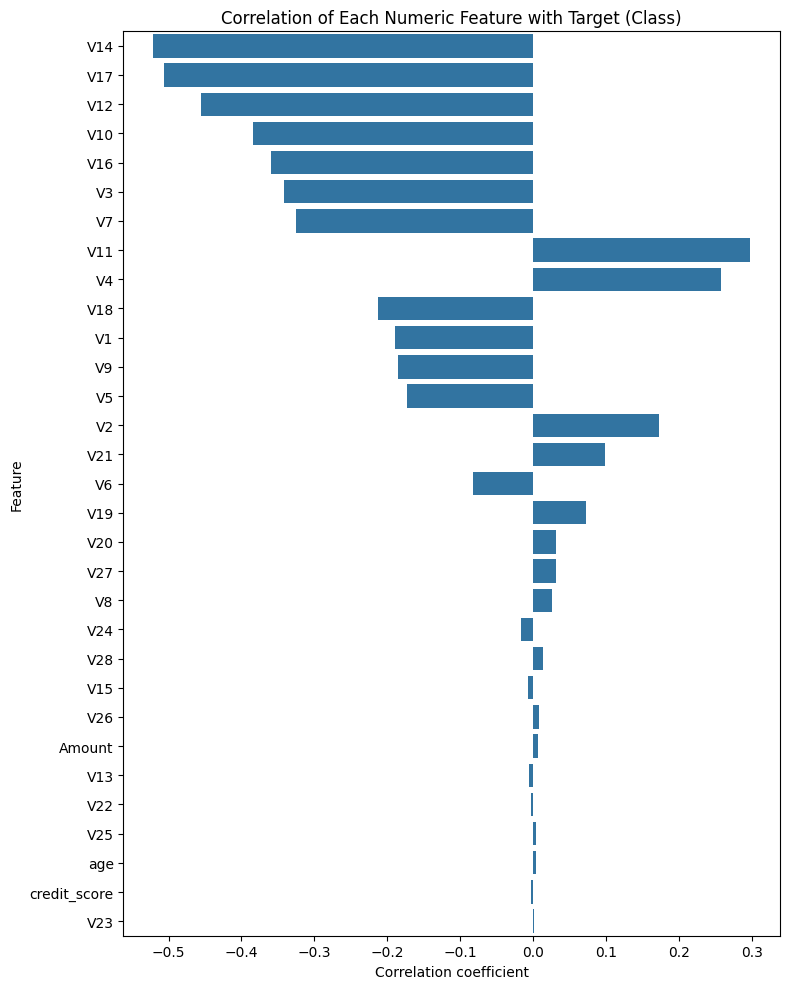

In [ ]:
# Keep only numeric columns (Class must be numeric 0/1)
num_df = df.select_dtypes(include="number").copy()

# Correlation matrix and correlation vs target
corr = num_df.corr()
target_corr = corr['Class'].drop(labels=['Class'])

# Sort by absolute correlation magnitude (most informative first)
target_corr_sorted = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)

# Show top/bottom features
display(target_corr_sorted.head(15).to_frame('corr_with_Class'))
display(target_corr_sorted.tail(15).to_frame('corr_with_Class'))

# Plot
plt.figure(figsize=(8, 10))
sns.barplot(
    x=target_corr_sorted.values,
    y=target_corr_sorted.index
)
plt.title("Correlation of Each Numeric Feature with Target (Class)")
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
"""print("Class dtype:", df['Class'].dtype)
print("Class unique values:", df['Class'].unique()[:10])
print("Class value counts:\n", df['Class'].value_counts(dropna=False))
print("Class null %:", df['Class'].isna().mean()*100, "%")

# % de columnas numéricas constantes (varianza 0)
num_df = df.select_dtypes(include="number")
const_cols = [c for c in num_df.columns if num_df[c].nunique(dropna=True) <= 1]
print("Constant numeric columns:", const_cols[:20], f"(total={len(const_cols)})")"""


'print("Class dtype:", df[\'Class\'].dtype)\nprint("Class unique values:", df[\'Class\'].unique()[:10])\nprint("Class value counts:\n", df[\'Class\'].value_counts(dropna=False))\nprint("Class null %:", df[\'Class\'].isna().mean()*100, "%")\n\n# % de columnas numéricas constantes (varianza 0)\nnum_df = df.select_dtypes(include="number")\nconst_cols = [c for c in num_df.columns if num_df[c].nunique(dropna=True) <= 1]\nprint("Constant numeric columns:", const_cols[:20], f"(total={len(const_cols)})")'

## Outliers analysis

In [ ]:
outlier_summary = []

for col in numeric_df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    n_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_summary.append((col, n_outliers, n_outliers/len(df)*100))

outlier_df = pd.DataFrame(outlier_summary, columns=["Feature", "Outliers", "% Outliers"]).sort_values(by="% Outliers", ascending=False)
display(outlier_df.head(15))

Feature  Outliers  % Outliers
26     V27     39666   13.865934
28  Amount     32038   11.199435
27     V28     30830   10.777158
19     V20     28214    9.862690
7       V8     24624    8.607744
5       V6     23320    8.151908
22     V23     18890    6.603325
11     V12     16290    5.694450
13     V14     15190    5.309926
20     V21     15169    5.302585
1       V2     14171    4.953717
4       V5     12829    4.484598
3       V4     11839    4.138527
9      V10     10622    3.713103
18     V19     10498    3.669757

## Duplicate and uniqueness check

In [ ]:
print(f"Total duplicated rows: {df.duplicated().sum()}")

id_cols = ['transaction_id', 'customer_id', 'device_id']
for col in id_cols:
    if col in df.columns:
        unique_count = df[col].nunique()
        print(f"{col}: {unique_count} unique values out of {len(df)} ({unique_count/len(df)*100:.2f}% unique)")

Total duplicated rows: 0
transaction_id: 286068 unique values out of 286068 (100.00% unique)
customer_id: 1000 unique values out of 286068 (0.35% unique)
device_id: 100 unique values out of 286068 (0.03% unique)


# PCA
Apply PCA to the numerical features of the dataset, analyze the eigenvalues and eigenvectors, and evaluate the performance of a model trained on the PCA-transformed data.

## Select numerical features

Select the numerical features from the DataFrame for PCA.


**Reasoning**:
Create a new DataFrame containing only numerical columns for PCA.



In [ ]:
df_numerical = df.select_dtypes(include=['float64', 'int64']).copy()
display(df_numerical.head())

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V23       V24       V25       V26  \
0  0.098698  0.363787  0.090794  ... -0.110474  0.066928  0.128539 -0.189115   
1  0.085102 -0.255425 -0.166974  ...  0.101288 -0.339846  0.167170  0.125895   
2  0.247676 -1.514654  0.207643  ...  0.909412 -0.689281 -0.327642 -0.139097   
3  0.377436 -1.387024 -0.054952  ... -0.190321 -1.175575  0.647376 -0.221929   
4 -0.270533  0.817739  0.753074  ... -0.137458  0.141267 -0.206010  0.502292   

        V27       V28  Amount  Class  age  credit_score  
0  0.133558 -0.021053  149.62      0   56           787  
1 -0.008983  0.014724    2.69      0   69           582  
2 -0.055353 -0.059752  378.66      0   46           765  
3  0.062723  0.061458  123.50      0   32           612  
4  0.219422  0.215153   69.99      0   60           580  

[5 rows x 32 columns]

## Scale the data

Standardize the selected numerical features before applying PCA.


**Reasoning**:
Standardize the numerical features using StandardScaler as requested by the subtask.



In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_numeric_data = scaler.fit_transform(df_numerical)
scaled_numeric_df = pd.DataFrame(scaled_numeric_data, columns=df_numerical.columns)
display(scaled_numeric_df.head())

V1        V2        V3        V4        V5        V6        V7  \
0 -0.656978 -0.053742  1.545420  0.924425 -0.224289  0.350595  0.193557   
1  0.598057  0.146602  0.121400  0.289675  0.052393 -0.056309 -0.036539   
2 -0.656263 -0.802894  1.086861  0.243007 -0.338812  1.350107  0.592367   
3 -0.463418 -0.120208  1.098749 -0.605421  0.003545  0.936819  0.192120   
4 -0.557834  0.508111  0.951967  0.258879 -0.272127  0.076861  0.448904   

         V8        V9       V10  ...       V23       V24       V25       V26  \
0  0.075373  0.334973  0.099221  ... -0.175264  0.111603  0.245747 -0.392634   
1  0.064798 -0.215475 -0.113889  ...  0.160178 -0.560353  0.319647  0.260514   
2  0.191254 -1.334865  0.195826  ...  1.440288 -1.137588 -0.626904 -0.288925   
3  0.292186 -1.221408 -0.021275  ... -0.301745 -1.940904  1.238255 -0.460671   
4 -0.211828  0.738513  0.646761  ... -0.218008  0.234404 -0.394228  1.040946   

        V27       V28    Amount     Class       age  credit_score  
0  0.319624 -0.064143  0.155299 -0.083908  0.339848      1.294092  
1 -0.023481  0.043590 -0.244938 -0.083908  1.057556     -0.684765  
2 -0.135096 -0.180674  0.779205 -0.083908 -0.212235      1.081727  
3  0.149119  0.184315  0.084148 -0.083908 -0.985151     -0.395176  
4  0.526303  0.647126 -0.061613 -0.083908  0.560681     -0.704071  

[5 rows x 32 columns]

## Apply pca

Apply PCA to the scaled data, keeping all components initially to analyze the variance explained by each component.


## Apply pca with selected components

### Subtask:
Apply PCA again, this time specifying the number of components to retain based on the analysis.


**Reasoning**:
Apply PCA again, this time specifying the number of components to retain based on the analysis from the previous step, and then fit the PCA model to the scaled data. From the cumulative explained variance plot, it appears that retaining approximately 10 components explains a significant portion of the variance, and the curve starts to flatten around this point.



In [ ]:
from sklearn.decomposition import PCA
pca_final = PCA(n_components=10)
pca_final.fit(scaled_numeric_df)

PCA(n_components=10)

## Analyze eigenvectors

### Subtask:
Examine the eigenvectors to understand the relationship between original features and principal components.


**Reasoning**:
Access the principal components (eigenvectors) from the fitted PCA object and create a DataFrame to show the contribution of original features to each principal component.



V1        V2        V3        V4        V5        V6        V7  \
PC1  -0.152067  0.131481 -0.247461  0.171653 -0.154738 -0.057532 -0.252175   
PC2  -0.165733 -0.403173 -0.123756  0.067757 -0.274256  0.178667  0.225345   
PC3   0.014420  0.051062  0.042717 -0.003295  0.096630  0.169121 -0.013386   
PC4   0.264482 -0.239613  0.119723  0.068335  0.243583 -0.209478  0.247909   
PC5  -0.098889 -0.092565  0.023565 -0.158748 -0.187222  0.056284 -0.009466   
PC6  -0.137114  0.102075 -0.068338 -0.007641 -0.100835 -0.162326 -0.038394   
PC7  -0.011427  0.024524 -0.007620  0.006115 -0.017415  0.135128 -0.015758   
PC8  -0.099230  0.110888 -0.046000 -0.079219 -0.145187 -0.015896 -0.014397   
PC9   0.010252  0.074501  0.012863 -0.012610 -0.005024  0.070698 -0.018778   
PC10  0.109796  0.049042  0.043298 -0.005273  0.054611  0.063018  0.005801   

            V8        V9       V10  ...       V23       V24       V25  \
PC1   0.033864 -0.140372 -0.273219  ...  0.004875 -0.006816  0.000879   
PC2  -0.063268 -0.030056 -0.055104  ... -0.088699  0.005910 -0.036686   
PC3  -0.496685  0.092704  0.049089  ...  0.237611 -0.053359  0.017594   
PC4   0.350476  0.036797  0.057118  ... -0.267031 -0.083742  0.096447   
PC5   0.140373  0.105160  0.034598  ... -0.132825  0.449146 -0.094050   
PC6   0.075606  0.021827  0.009340  ... -0.315312 -0.003015  0.350279   
PC7   0.036930 -0.005782  0.017641  ... -0.031742 -0.168373 -0.019507   
PC8   0.123788  0.000999  0.007184  ...  0.190326  0.207914  0.761686   
PC9  -0.013750 -0.019624  0.011934  ...  0.160810  0.025390  0.189357   
PC10 -0.030898  0.000005  0.002531  ...  0.268431  0.148486 -0.058662   

           V26       V27       V28    Amount     Class       age  credit_score  
PC1   0.006383  0.011022  0.000090  0.003715  0.464617  0.002157     -0.002430  
PC2  -0.003144  0.021630  0.007631  0.726200 -0.001337  0.006790     -0.005739  
PC3   0.008122  0.164375  0.164496  0.010283  0.057375 -0.000640     -0.017746  
PC4   0.108725  0.547091  0.211730  0.009463  0.079976 -0.005104      0.034554  
PC5  -0.157820 -0.009971 -0.096465  0.005991 -0.056625 -0.127892      0.010074  
PC6  -0.361603 -0.019514 -0.070893  0.003562 -0.007329  0.168187      0.546301  
PC7   0.352679  0.123962 -0.371895 -0.006179 -0.019141  0.636026     -0.150925  
PC8   0.235698  0.064249  0.097238 -0.001103 -0.026918 -0.172696     -0.346469  
PC9  -0.042415 -0.011342  0.083534 -0.009530 -0.007240  0.528736      0.224586  
PC10 -0.242214  0.033528  0.528214 -0.007983 -0.000771  0.139352      0.185899  

[10 rows x 32 columns]

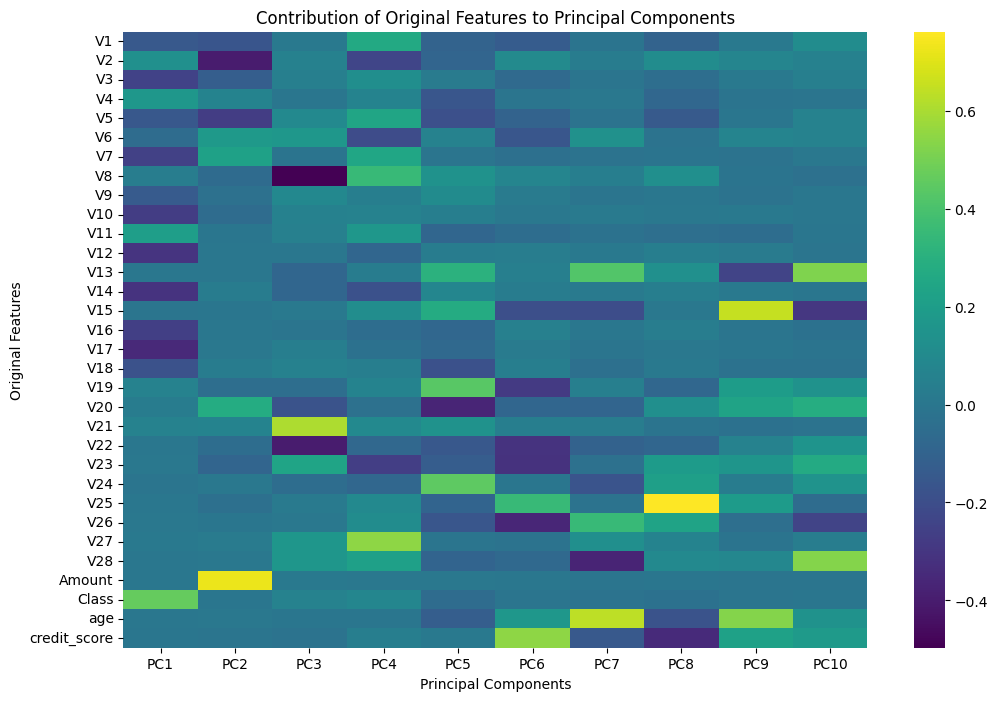

In [ ]:
principal_components = pca_final.components_
feature_names = scaled_numeric_df.columns
pc_df = pd.DataFrame(principal_components, columns=feature_names, index=[f'PC{i+1}' for i in range(principal_components.shape[0])])
display(pc_df)

plt.figure(figsize=(12, 8))
sns.heatmap(pc_df.T, cmap='viridis', annot=False)
plt.title('Contribution of Original Features to Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.show()

# Mutual Information

Calculate mutual information scores between features and the target variable.

**Reasoning**:
Calculate the mutual information between each numerical feature and the target variable 'Class' to understand their dependency.

Mutual Information Scores (sorted):


V17             0.036908
V14             0.036755
V12             0.036242
V10             0.036077
V11             0.035290
V16             0.034726
V4              0.033635
V3              0.033383
V18             0.033311
V9              0.033309
V7              0.032573
V2              0.032025
V21             0.031291
V6              0.031211
V27             0.031137
V5              0.030990
V8              0.030955
V1              0.030937
V28             0.030767
V19             0.030579
V20             0.030156
V13             0.029869
V26             0.029847
V25             0.029831
V23             0.029738
V15             0.029699
V22             0.029503
V24             0.029373
Amount          0.017787
age             0.001081
credit_score    0.000420
dtype: float64

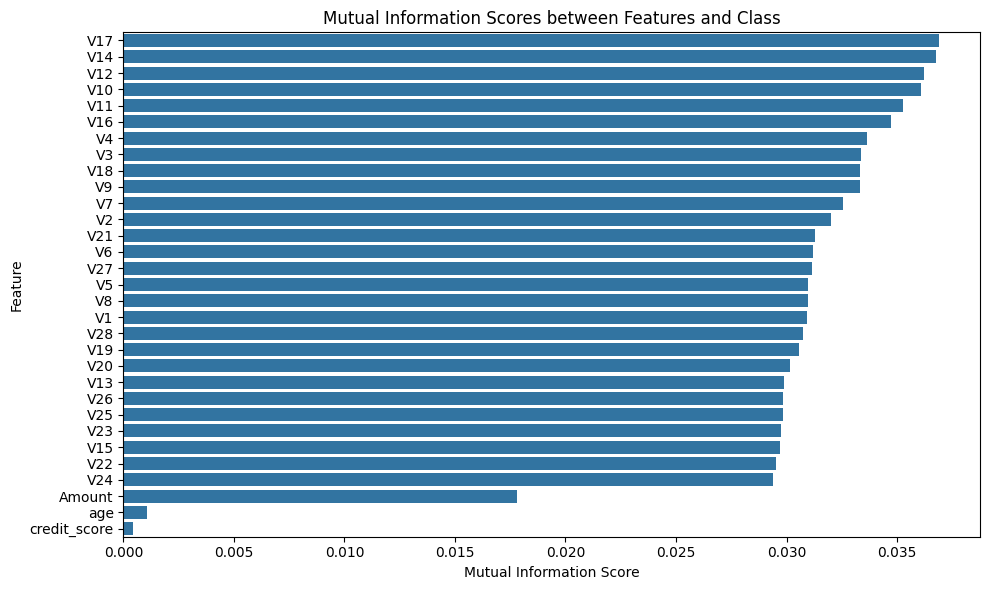

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Separate features (X) and target (y)
X = df_numerical.drop('Class', axis=1)
y = df_numerical['Class']

# Calculate mutual information scores
mutual_info_scores = mutual_info_classif(X, y, random_state=123)

# Create a Series with feature names and scores
mutual_info_series = pd.Series(mutual_info_scores, index=X.columns)

# Sort the scores in descending order
mutual_info_series_sorted = mutual_info_series.sort_values(ascending=False)

print("Mutual Information Scores (sorted):")
display(mutual_info_series_sorted)

# Visualize the mutual information scores
plt.figure(figsize=(10, 6))
sns.barplot(x=mutual_info_series_sorted.values, y=mutual_info_series_sorted.index)
plt.title('Mutual Information Scores between Features and Class')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# MRmr

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np
import pandas as pd

# Assuming X and y are already defined from previous steps and are pandas DataFrames/Series

# Variable initialization
n_var = X.shape[1]
var_sel = np.empty(0,dtype=int) # subset of selected features
var_cand = np.arange(n_var) # subset of candidate features
feature_names = X.columns # Get original feature names

# Precompute relevances using mutual information for classification
# We need to handle potential discrete features if any exist in X.
# For now, assuming all features in X are continuous.
# If you have discrete features, you would need to provide a 'discrete_features' mask.
relevances = mutual_info_classif(X, y, random_state=123)


# Precompute redundancies (correlation among all input variables)
# Using absolute correlation as a measure of redundancy
redundancies = np.abs(X.corr())
# Convert to numpy array for easier indexing with np.ix_
redundancies_np = redundancies.values


# Select the most relevant feature (with highest mutual information)
sel = np.argmax(relevances)
# Add it to the subset of selected features
var_sel = np.hstack([var_sel,sel])
# Remove it from the subset of candidate features
var_cand = np.delete(var_cand,sel)

MRmr_values= [relevances[sel]]
selected_features = [feature_names[sel]] # Keep track of selected feature names

# Iteratively select variables
for i in range(n_var-1):
    if len(var_cand) == 0:
        break # Stop if no more candidate features

    # Get relevance values of the var_cand variables
    relevances_cand=relevances[var_cand]

    # Compute redundancies with selected features:
    # from the redundancies matrix select the rows of var_sel and the columns of var_cand
    # Ensure indexing is correct for numpy array
    redundancy_sel = redundancies_np[np.ix_(var_sel,var_cand)]
    # Average the redundancy values over the selected features (rows)
    # to get a redundancy value for each candidate variables
    redundancy_cand=np.mean(redundancy_sel,axis=0)

    # Compute MRmr = relevances_cand - redundancy_cand
    MRmr=relevances_cand-redundancy_cand

    # Select the new feature as the one with the maximum MRmr value
    # Handle cases where MRmr might be all negative or zero
    if np.all(MRmr <= 0):
        # If no positive MRmr, select the one with the least negative/closest to zero
        sel = np.argmax(MRmr) # argmax will return the index of the first occurrence of the maximum value
    else:
         sel = np.argmax(MRmr)

    MRmr_values.append(MRmr[sel])
    # Add it to the subset of selected features
    var_sel=np.hstack([var_sel,var_cand[sel]])
    # Keep track of selected feature names
    selected_features.append(feature_names[var_cand[sel]])
    # Remove it from the subset of candidate features
    var_cand= np.delete(var_cand,sel)


# The indices of the relevant features in the original DataFrame X
ind_rel_feat_indices = var_sel
selected_feature_names = selected_features

print("Indices of selected features (in order of selection):", ind_rel_feat_indices)
print("Names of selected features (in order of selection):", selected_feature_names)
print("MRmr values at each selection step:", MRmr_values)

# You can now use selected_feature_names to select columns from your original DataFrame X
# X_mrmr = X[selected_feature_names]

Indices of selected features (in order of selection): [16 23 27 22 24 25 14 12 19 26 21  5 18  1  8  7  3 20  0 10  4 17 29 30
  2  9 15  6 13 11 28]
Names of selected features (in order of selection): ['V17', 'V24', 'V28', 'V23', 'V25', 'V26', 'V15', 'V13', 'V20', 'V27', 'V22', 'V6', 'V19', 'V2', 'V9', 'V8', 'V4', 'V21', 'V1', 'V11', 'V5', 'V18', 'age', 'credit_score', 'V3', 'V10', 'V16', 'V7', 'V14', 'V12', 'Amount']
MRmr values at each selection step: [np.float64(0.036908282167455675), np.float64(0.028380928142055385), np.float64(0.02930149736097193), np.float64(0.028204114601633957), np.float64(0.028156326030653635), np.float64(0.028229376365181996), np.float64(0.02834582793260305), np.float64(0.027838303471453663), np.float64(0.027191627434744743), np.float64(0.02628157988958113), np.float64(0.024466562503098303), np.float64(0.02475322344757668), np.float64(0.022548228435487563), np.float64(0.0190454869607162), np.float64(0.01647197860924893), np.float64(0.016067455571958947), np.

In [ ]:
mi_scores_MRmr = pd.Series(MRmr_values, index =X.columns[ind_rel_feat_indices])
mi_scores_MRmr

V17             0.036908
V24             0.028381
V28             0.029301
V23             0.028204
V25             0.028156
V26             0.028229
V15             0.028346
V13             0.027838
V20             0.027192
V27             0.026282
V22             0.024467
V6              0.024753
V19             0.022548
V2              0.019045
V9              0.016472
V8              0.016067
V4              0.012852
V21             0.013192
V1              0.009305
V11             0.005291
V5              0.002443
V18             0.000080
age            -0.000526
credit_score   -0.001154
V3             -0.011339
V10            -0.016881
V16            -0.021711
V7             -0.029131
V14            -0.036505
V12            -0.043453
Amount         -0.051338
dtype: float64

In [ ]:
def plot_utility_scores(scores, title):
    y = scores.sort_values(ascending=True)
    width = np.arange(len(y))
    ticks = list(y.index)
    plt.barh(width, y)
    plt.yticks(width, ticks)
    plt.title(title)

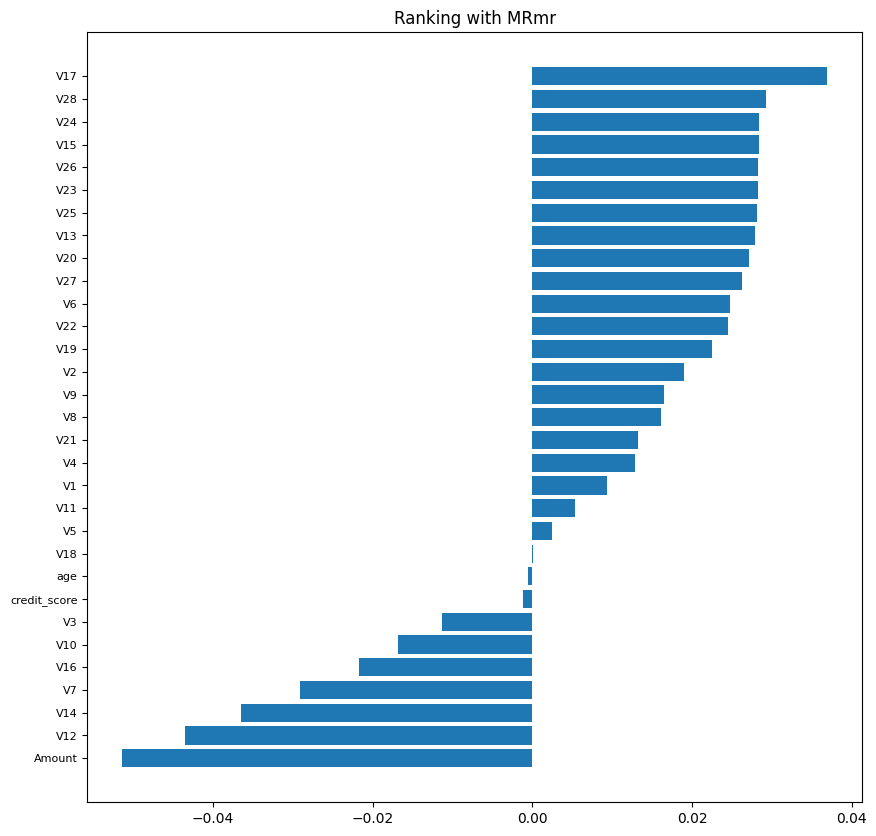

In [ ]:
plt.figure(dpi=100, figsize=(10, 10))

plt.rc('ytick', labelsize=8)
plot_utility_scores(mi_scores_MRmr, title="Ranking with MRmr")


In [ ]:
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
import pandas as pd

def center_K(K):
    """Center a kernel matrix K, i.e., removes the data mean in the feature space.

    Args:
        K: kernel matrix
    """
    size_1,size_2 = K.shape;
    D1 = K.sum(axis=0)/size_1
    D2 = K.sum(axis=1)/size_2
    E = D2.sum(axis=0)/size_1

    K_n = K + np.tile(E,[size_1,size_2]) - np.tile(D1,[size_1,1]) - np.tile(D2,[size_2,1]).T
    return K_n

def HSIC_rbf(X_data, Y_data):
    """Compute HSIC value between input and output data using a RBF kernel

    Args:
        X_data: input data (features)
        Y_data: output data (target)
    """
    # Ensure X_data and Y_data are 2D arrays
    if X_data.ndim==1:
        X_data=X_data[:,np.newaxis]
    if Y_data.ndim==1:
        Y_data=Y_data[:,np.newaxis]

    # 2. Compute kernel matrices
    K_x = rbf_kernel(X_data)
    K_y = rbf_kernel(Y_data)

    # 3. Center kernel matrices
    K_xc = center_K(K_x)
    K_yc = center_K(K_y)

    # 4. Compute HSIC value
    HSIC= float(np.multiply(K_xc,K_yc).sum().sum())/(K_x.shape[0]**2) ;
    #HSIC= float(np.trace(np.dot(K_xc,K_yc)))/(K_x.shape[0]**2)
    return HSIC




# Compute HSIC relevances
importances=np.zeros(X.shape[1])
for i in range(X.shape[1]):
    # We need to pass a 2D array for X_data and Y_data to rbf_kernel
    importances[i]=HSIC_rbf(X.iloc[:,i].values.reshape(-1, 1), y.values.reshape(-1, 1))

# Obtain the positions of the sorted features (the most relevant first)
ind_rel_feat = np.argsort(importances)[::-1]

HSIC_scores = pd.Series(importances[ind_rel_feat], index =X.columns[ind_rel_feat])
display(HSIC_scores)

plt.figure(figsize=(10, 6))
sns.barplot(x=HSIC_scores.values, y=HSIC_scores.index)
plt.title('HSIC Scores between Features and Class (RBF Kernel)')
plt.xlabel('HSIC Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()